In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 290035575


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 290035575

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 6 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 14 2019   SPOC     120   290035575      0.0     G022062
  1 TESS Sector 15 2019   SPOC     120   290035575      0.0     G022062
  2 TESS Sector 40 2021   SPOC     120   290035575      0.0      G04171
  3 TESS Sector 41 2021   SPOC     120   290035575      0.0      G04171
  4 TESS Sector 54 2022   SPOC     120   290035575      0.0      G04171
  5 TESS Sector 55 2022   SPOC     120   290035575      0.0      G04171

110887

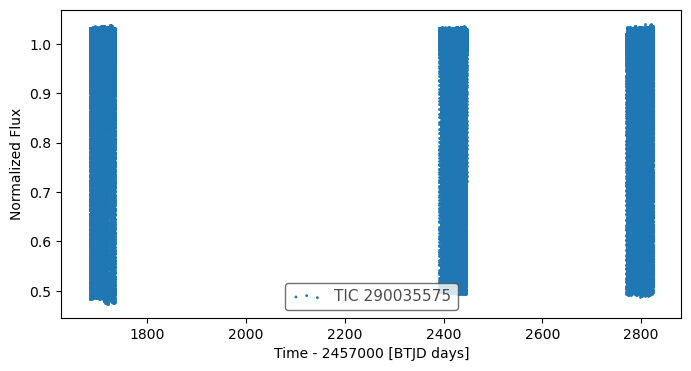

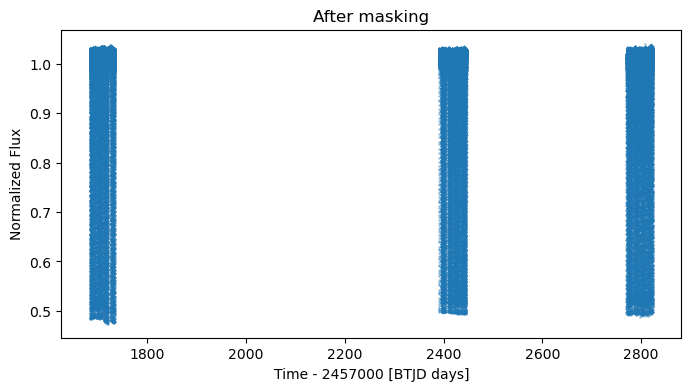

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# mask = flux < 0.85    # remove occasional outliers
# mask = (
#     ( flux < 0.95 ) | # remove occasional lone outliers
#     # cadences where scattered light effect is prevalent
#     ( (time > 2718)   & (time < 2744) ) 
# )

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,                    
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )
         
    pg.show_properties();
    print(pg.period_at_max_power);
    
    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);
    
    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");  

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg, 
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [8]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

In [9]:
0.47618474291249396 * 2

0.9523694858249879

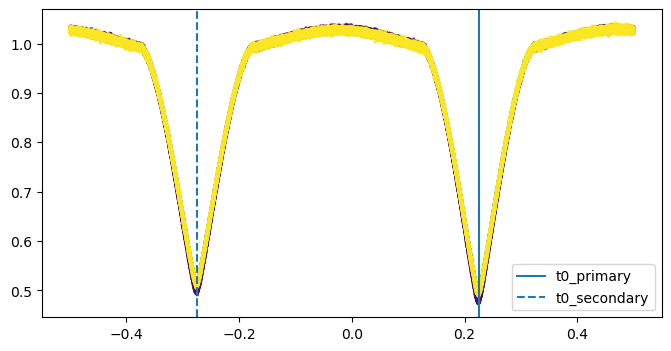

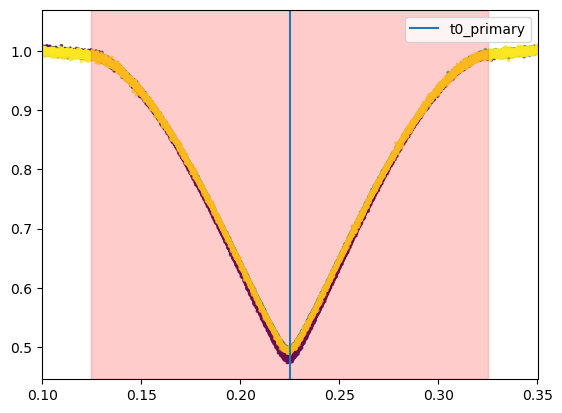

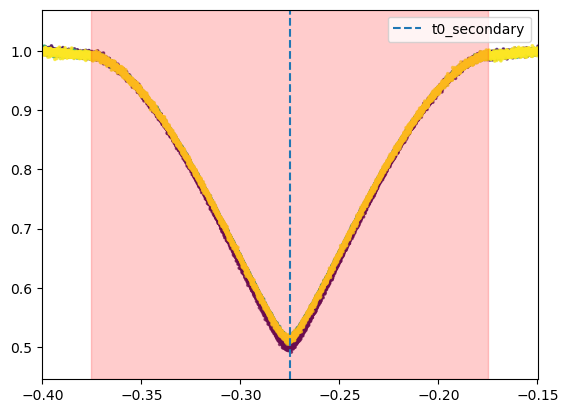

In [10]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1683.42, duration_hr=4.58363, period=0.47618474291249396, label="s0014s0055tce1", transit_depth_percent=41.6343,  # P_err: 4e-7
# VSX: 0.952377636 
# TESS EB: 0.9523769  (2 sectors)
# MCMC on df_primary: 

# FILL-IN THE eclipse epoch / period, 
period = 0.952377636  # VSX


t0_primary = 1683.418  # TESS EB
t0_secondary = t0_primary + period /2

duration_hr_primary = 4.58363
duration_hr_secondary = 4.58363

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

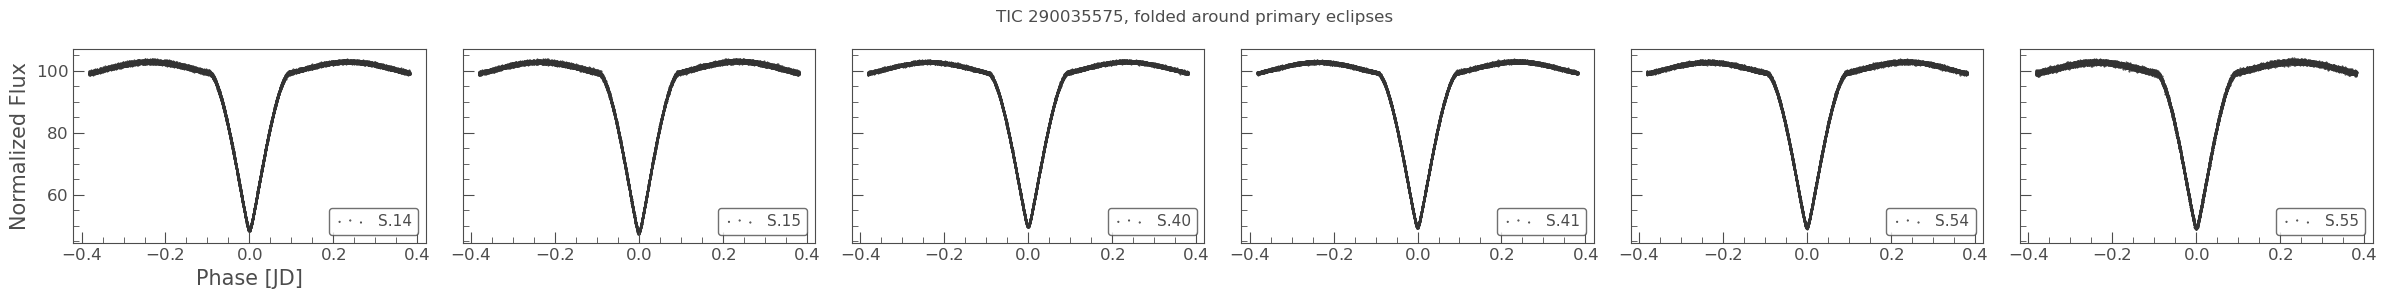

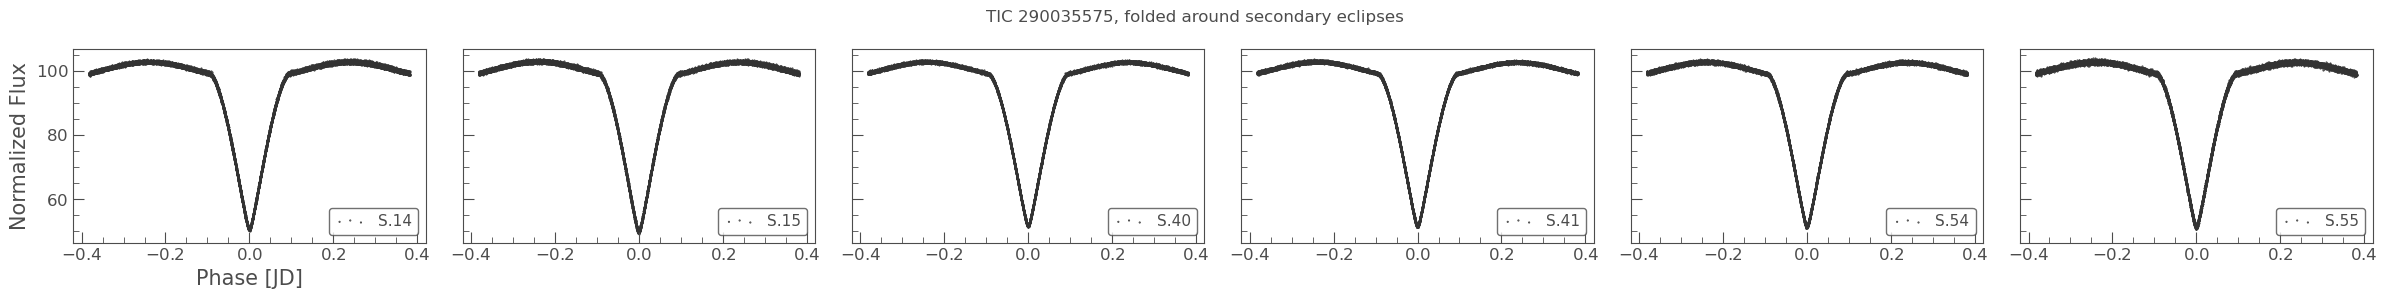

In [11]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [12]:
# show data to visualize what's changed in each step below
data  

time      flux       err     phase
0       1683.355963  0.879424  0.001469  0.159861
1       1683.357352  0.871556  0.001461  0.161319
2       1683.358741  0.864480  0.001458  0.162778
3       1683.360130  0.857328  0.001455  0.164236
4       1683.361519  0.846622  0.001449  0.165694
...             ...       ...       ...       ...
103365  2824.259414  0.996527  0.001397  0.112656
103366  2824.260803  0.993880  0.001396  0.114115
103367  2824.262192  0.999620  0.001398  0.115573
103368  2824.263581  0.993098  0.001397  0.117031
103369  2824.264970  0.992519  0.001397  0.118490

[103370 rows x 4 columns]

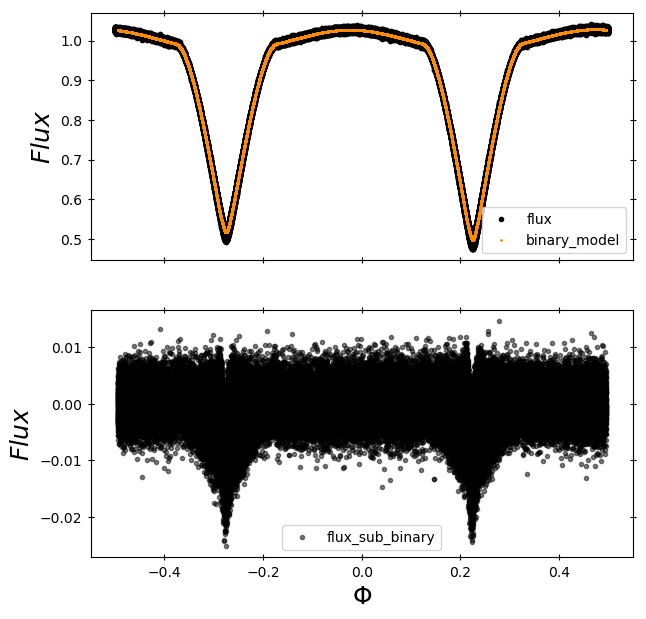

time      flux       err     phase  flux_sub_binary  \
0       1683.355963  0.879424  0.001469  0.159861        -0.005484   
1       1683.357352  0.871556  0.001461  0.161319        -0.006038   
2       1683.358741  0.864480  0.001458  0.162778        -0.005641   
3       1683.360130  0.857328  0.001455  0.164236        -0.005189   
4       1683.361519  0.846622  0.001449  0.165694        -0.008171   
...             ...       ...       ...       ...              ...   
103365  2824.259414  0.996527  0.001397  0.112656         0.000531   
103366  2824.260803  0.993880  0.001396  0.114115        -0.001639   
103367  2824.262192  0.999620  0.001398  0.115573         0.004589   
103368  2824.263581  0.993098  0.001397  0.117031        -0.001482   
103369  2824.264970  0.992519  0.001397  0.118490        -0.001628   

        binary_model  
0           0.884908  
1           0.877594  
2           0.870121  
3           0.862517  
4           0.854793  
...              ...  
103365      0.995996  
103366      0.995520  
103367      0.995031  
103368      0.994579  
103369      0.994147  

[103370 rows x 6 columns]

In [13]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 102347 901
reached the end
10 100730 901
reached the end
10 100476 901
reached the end
10 100433 901
reached the end
10 100428 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0       1683.355963  0.879424  0.001469  0.159861        -0.005484   
1       1683.357352  0.871556  0.001461  0.161319        -0.006038   
2       1683.358741  0.864480  0.001458  0.162778        -0.005641   
3       1683.360130  0.857328  0.001455  0.164236        -0.005189   
4       1683.361519  0.846622  0.001449  0.165694        -0.008171   
...             ...       ...       ...       ...              ...   
103365  2824.259414  0.996527  0.001397  0.112656         0.000531   
103366  2824.260803  0.993880  0.001396  0.114115        -0.001639   
103367  2824.262192  0.999620  0.001398  0.115573         0.004589   
103368  2824.263581  0.993098  0.001397  0.117031        -0.001482   
103369  2824.264970  0.992519  0.001397  0.118490        -0.001628   

        binary_model  flux_detrended  
0           0.884908        0.885024  
1           0.877594        0.877139  
2           0.870121        0.870045  
3           0.862517        0.862875  
4           0.854793        0.852150  
...              ...             ...  
103365      0.995996        0.996501  
103366      0.995520        0.993853  
103367      0.995031        0.999591  
103368      0.994579        0.993067  
103369      0.994147        0.992485  

[103370 rows x 7 columns]

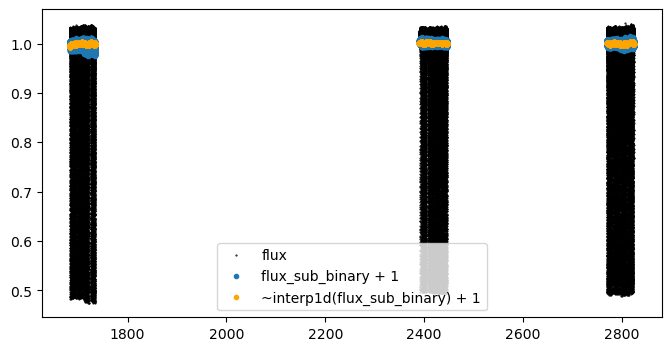

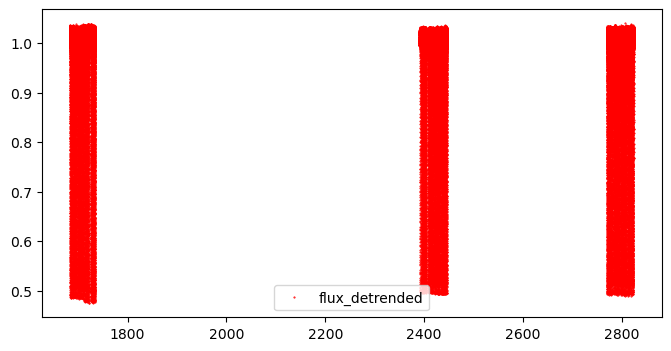

In [14]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

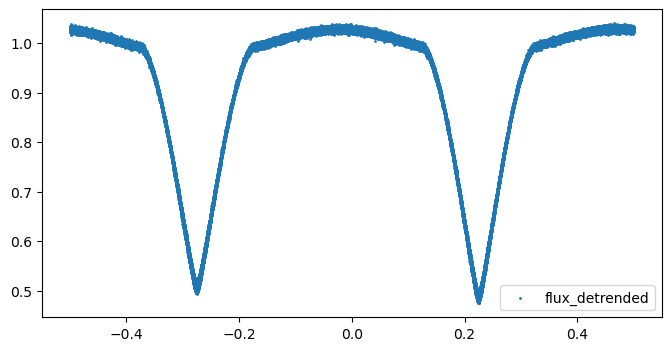

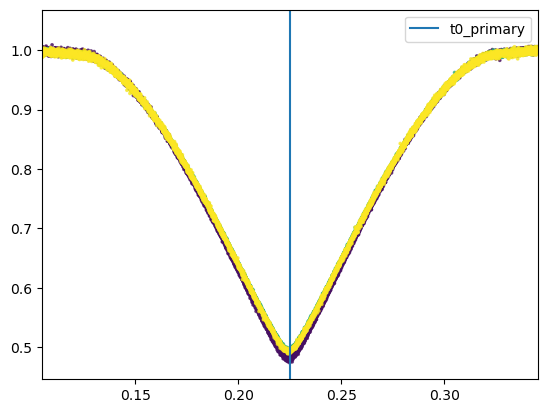

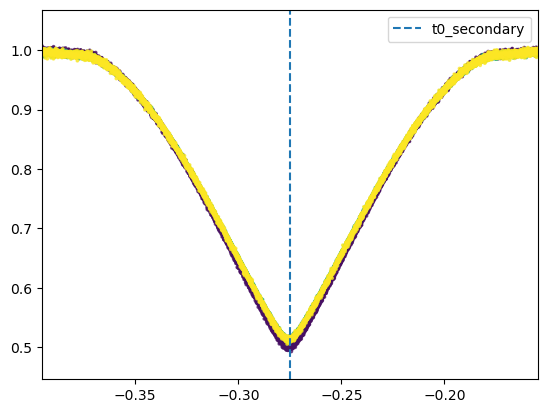

In [15]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [16]:
from importlib import reload
reload(etv_functions)

# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.2 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.2 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.0, -0.5, midpoint_p, 0.045, 0.6]
start_vals_s = [1.0, -0.5, midpoint_s, 0.045, 0.6]

# -- -- -- -- -- -- -- -- -- 
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, t0_primary, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1683.418 0.22499999999994347
window_width_p (phase): 0.24064141296152822
Secondary: 1683.894188818 -0.27499999999997005
window_width_s (phase): 0.24064141296152822


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.0, -0.5, t0_primary, 0.045, 0.6, 0.952377636],


In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

In [ ]:
# use MCMC to refine the period

use_mcmc_to_fit_period = False


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()
        
    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [0.97, -0.46, t0_primary, 0.030, 1.0, period],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.14it/s]


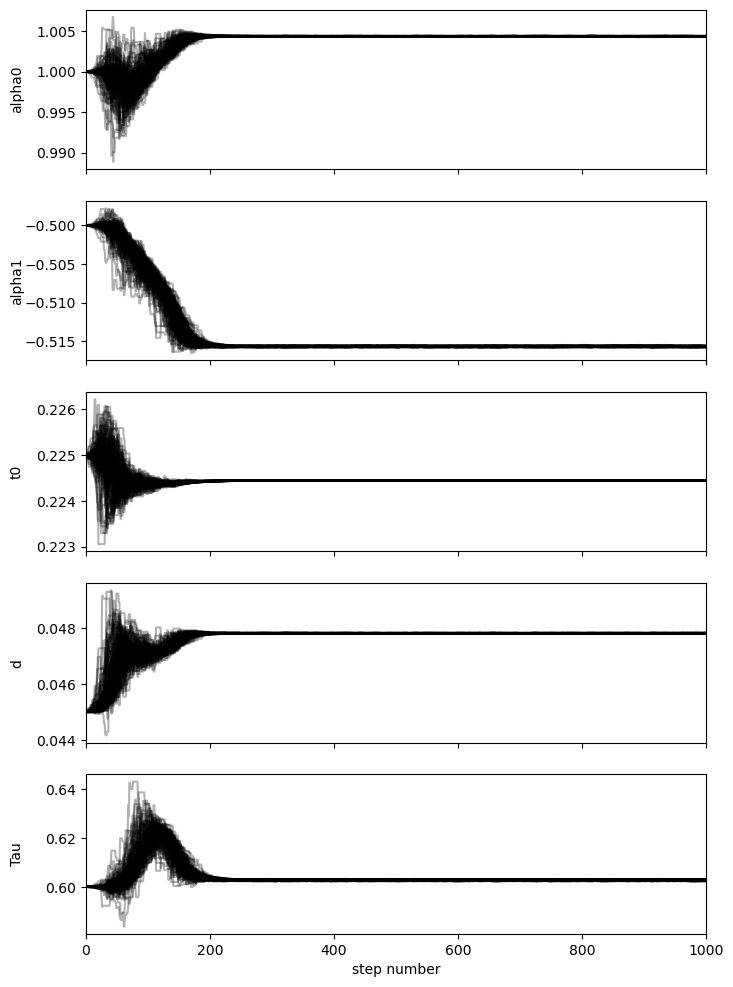

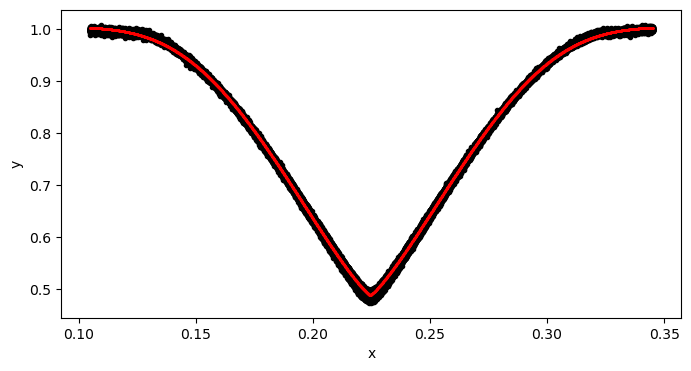

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.85it/s]


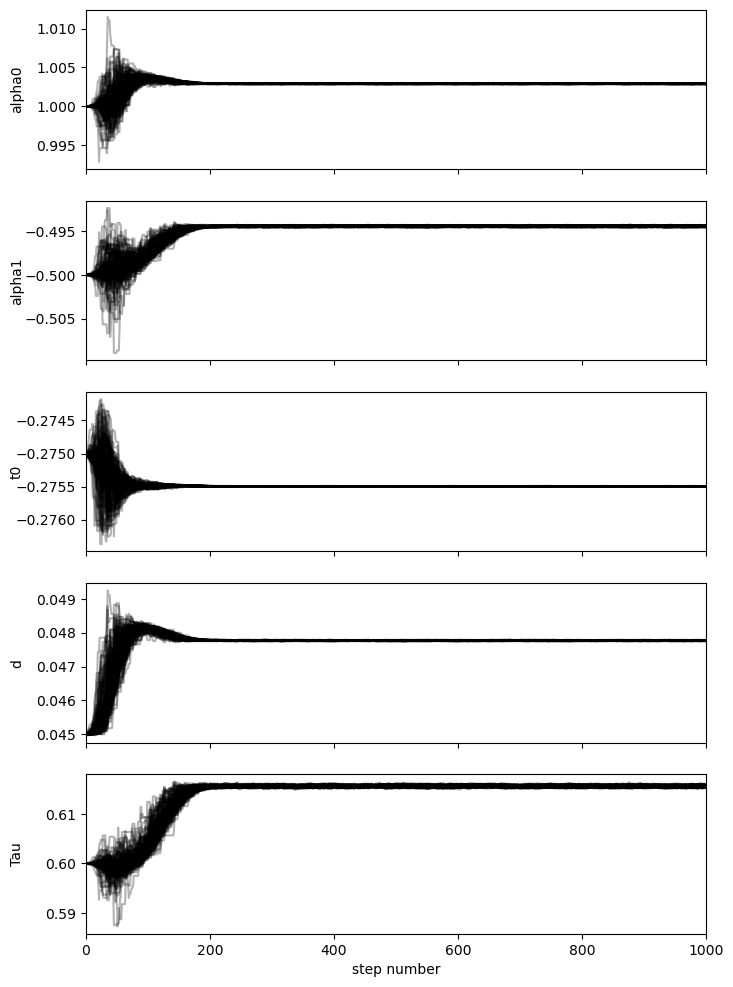

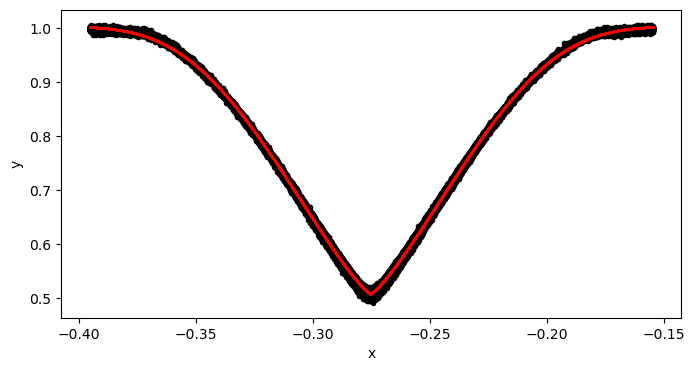

In [38]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0043642112402706, -0.5156728157898436, 0.22443987809231702, 0.04780910669819097, 0.6027377805341326
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.002908556131359, -0.4944476052966029, -0.2754963204417742, 0.04776624615226714, 0.615624976032206

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [42]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0043642112402706, -0.5156728157898436, 0.22443987809231702, 0.04780910669819097, 0.6027377805341326
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.002908556131359, -0.4944476052966029, -0.2754963204417742, 0.04776624615226714, 0.615624976032206


1197

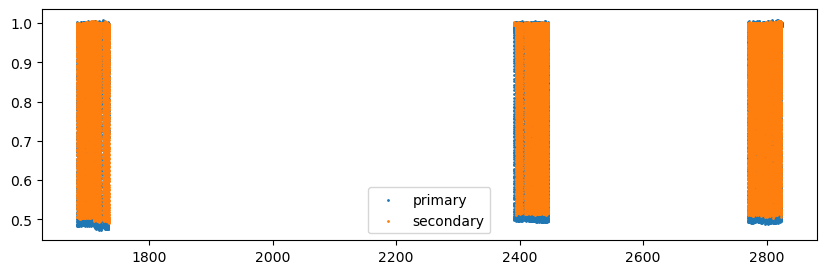

In [43]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1683.418 0.952377636 1683.418


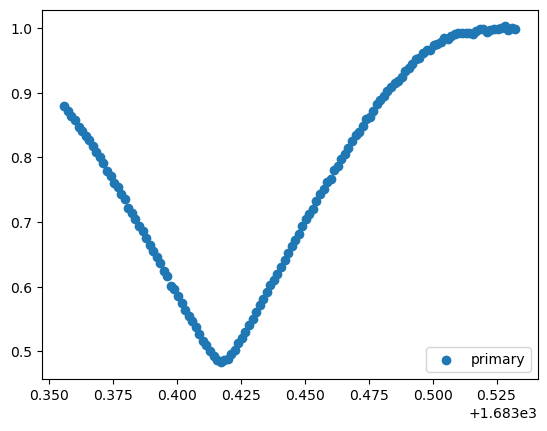

1683.418 0.952377636 1684.3703776359998


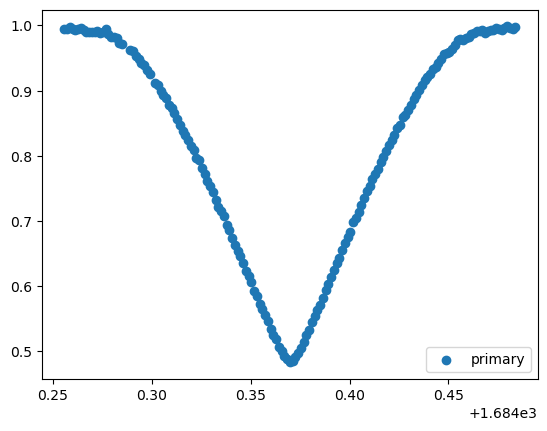

1683.418 0.952377636 1685.322755272


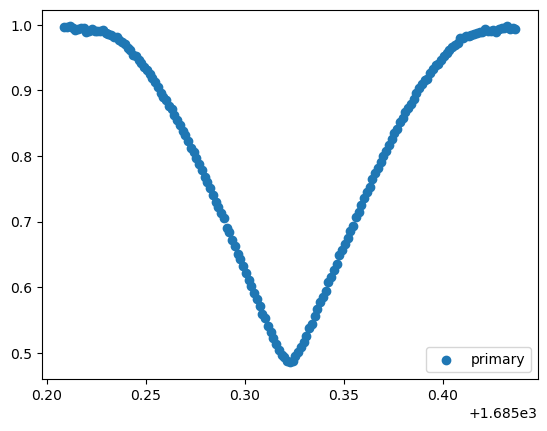

1683.894188818 0.952377636 1683.894188818


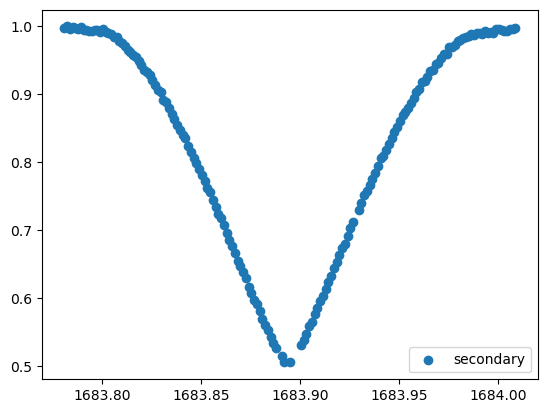

1683.894188818 0.952377636 1684.846566454


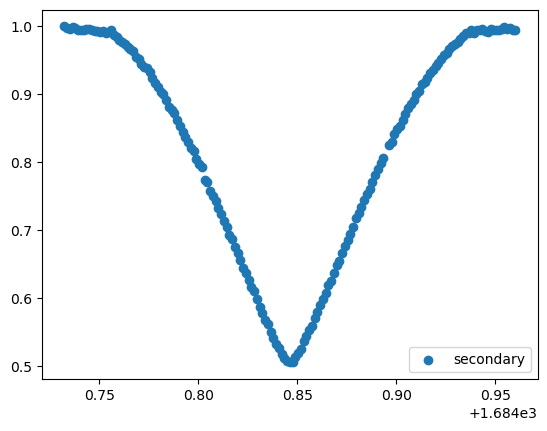

1683.894188818 0.952377636 1685.79894409


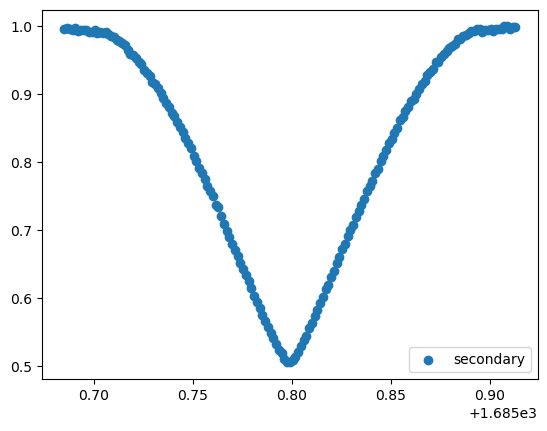

In [44]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
1685.322755272 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.53it/s]


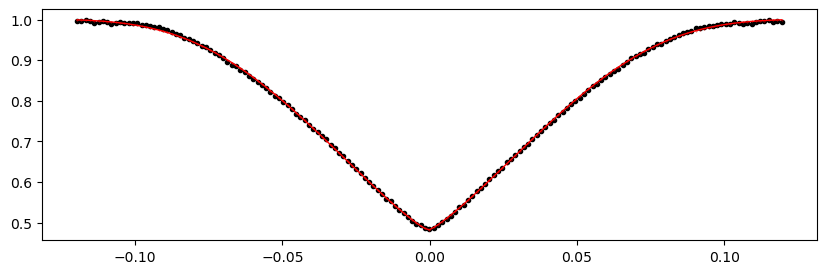

1686.275132908 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.96it/s]


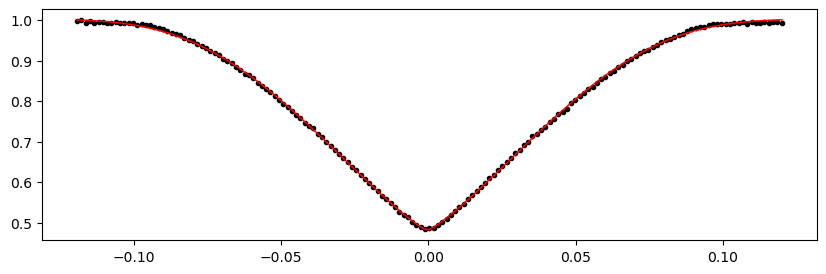

1687.2275105439999 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.24it/s]


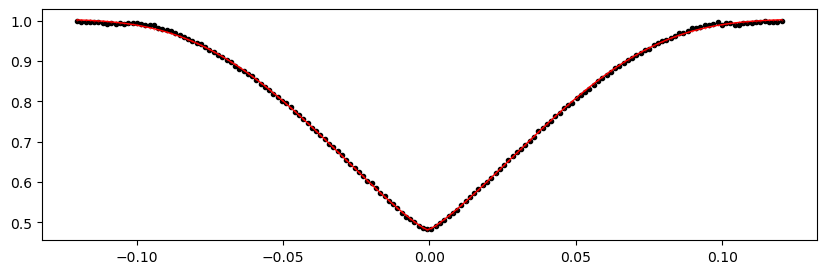

1688.1798881799998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.94it/s]


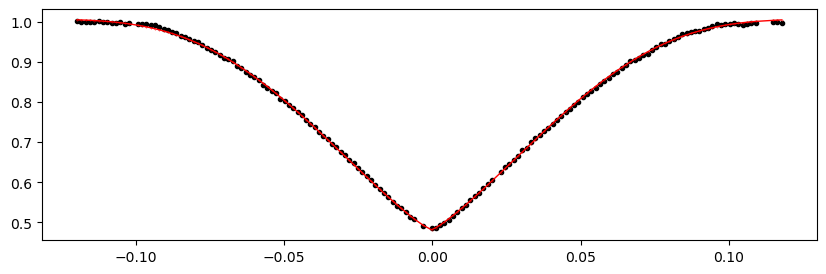

1689.132265816 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.71it/s]


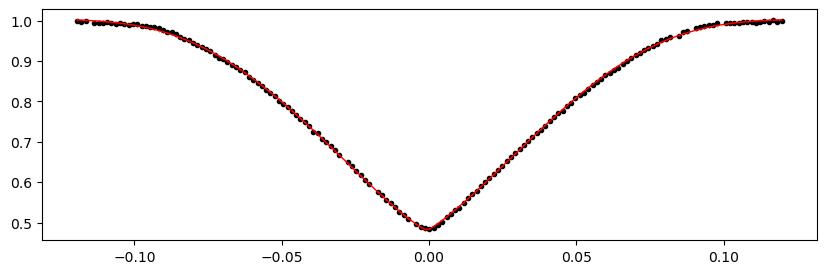

1690.084643452 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.66it/s]


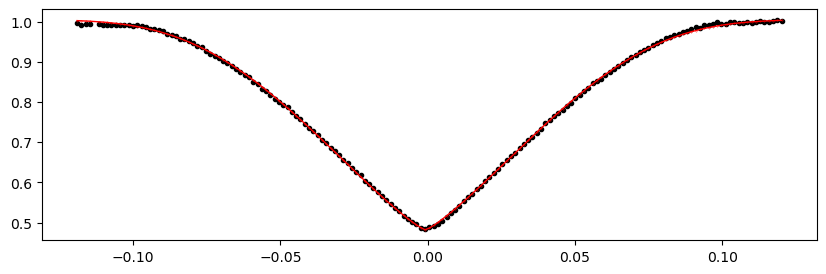

1691.0370210879998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.27it/s]


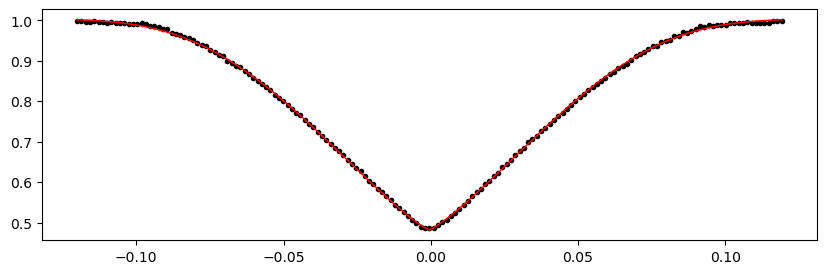

1691.9893987239998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.47it/s]


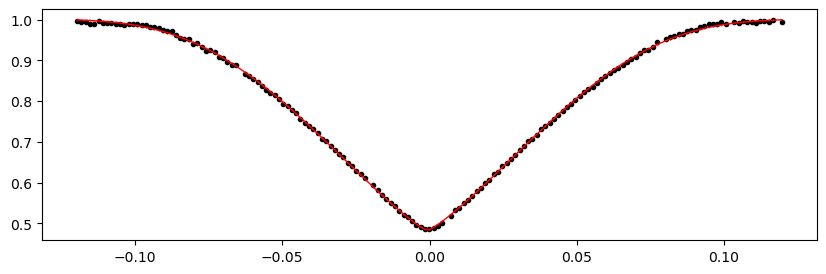

1692.94177636 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.88it/s]


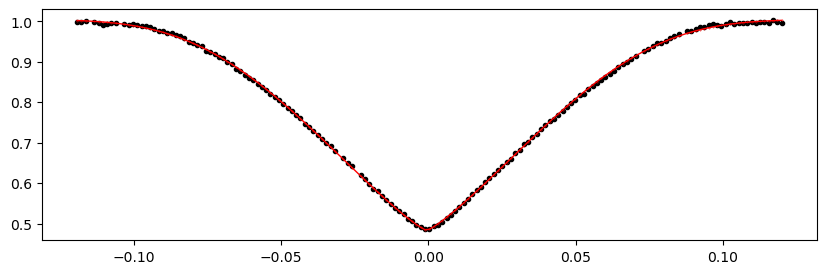

1693.894153996 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.90it/s]


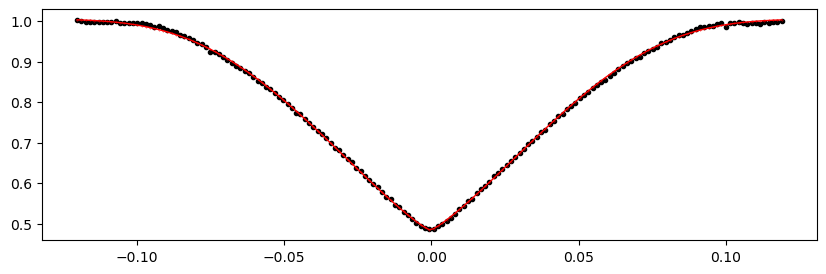

1694.8465316319998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.31it/s]


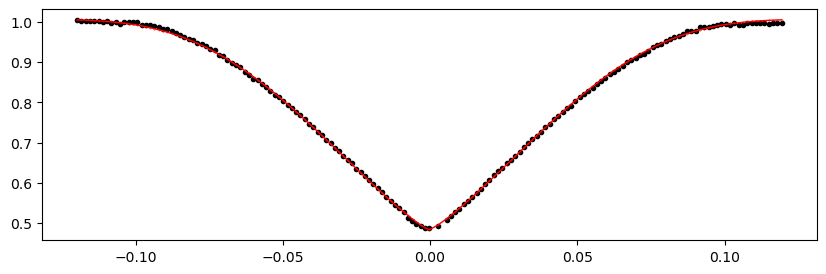

1695.798909268 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.67it/s]


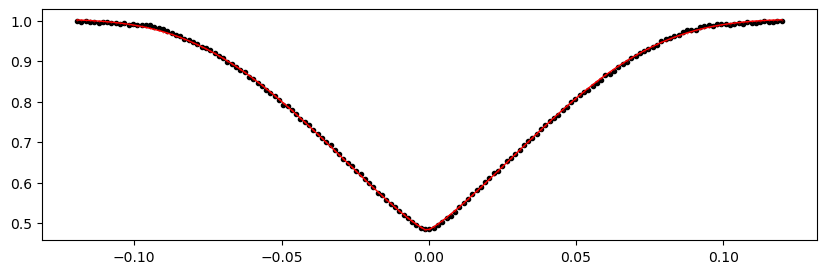

1697.7036645399999 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.16it/s]


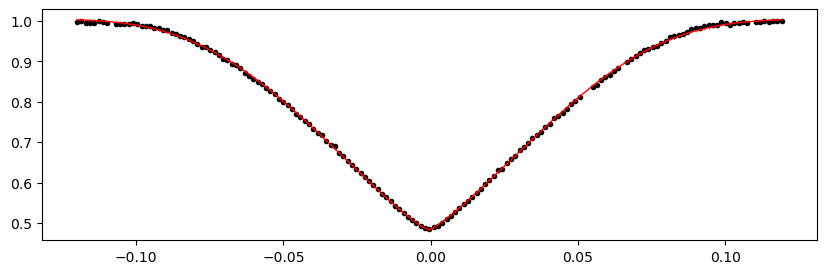

1698.6560421759998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.62it/s]


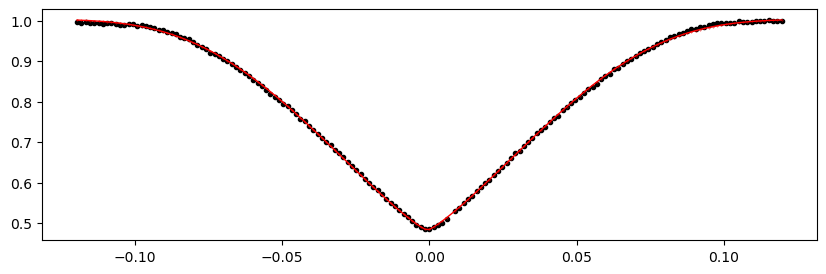

1699.608419812 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.53it/s]


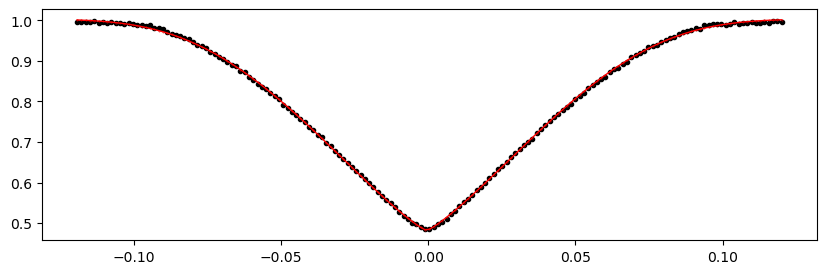

1700.560797448 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.43it/s]


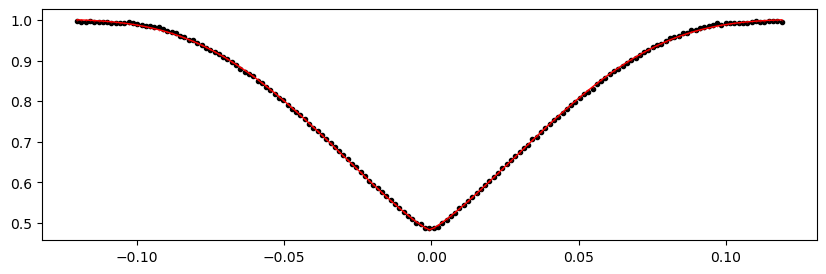

1701.5131750839998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.35it/s]


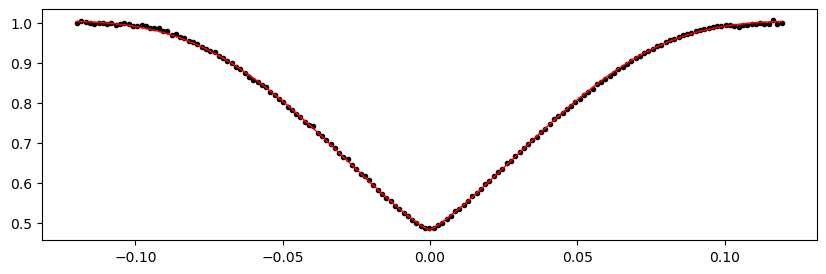

1702.4655527199998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.75it/s]


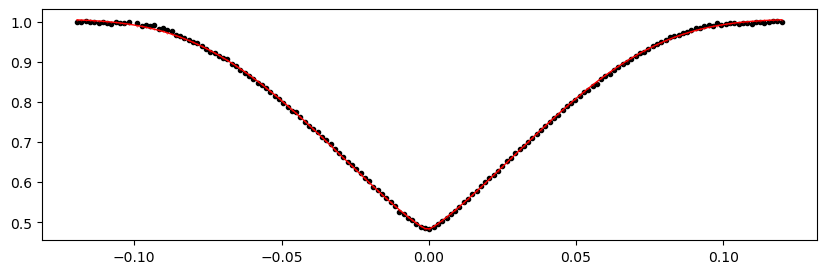

1703.417930356 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.77it/s]


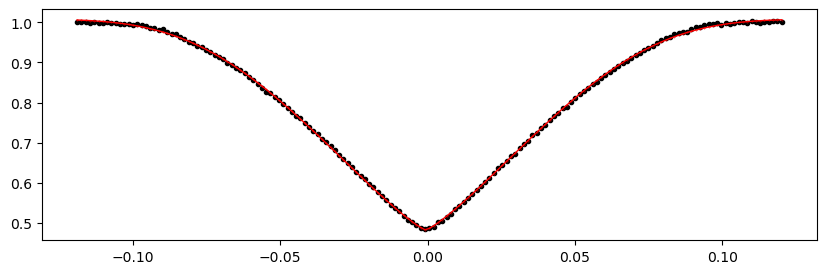

1704.3703079919999 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.35it/s]


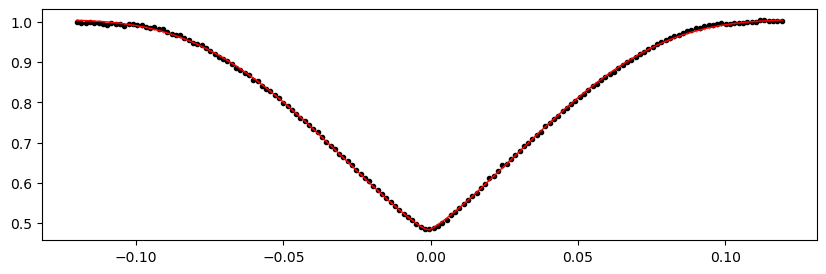

1705.3226856279998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 344.98it/s]


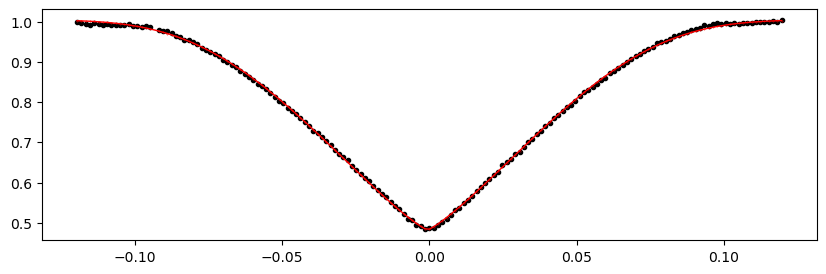

1706.275063264 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.22it/s]


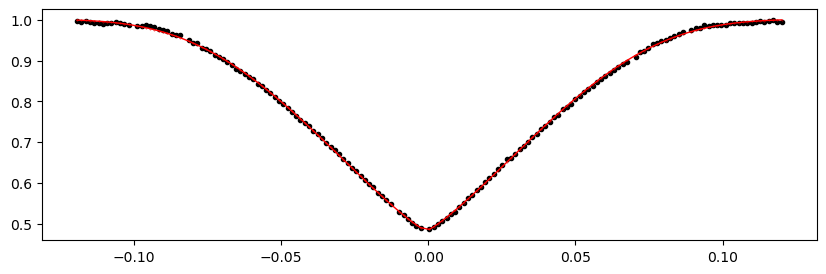

1707.2274409 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.62it/s]


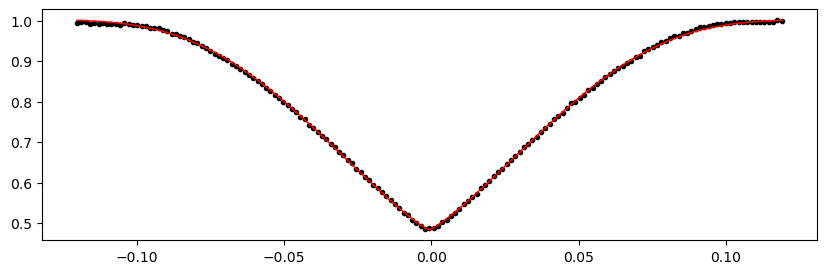

1708.1798185359999 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.20it/s]


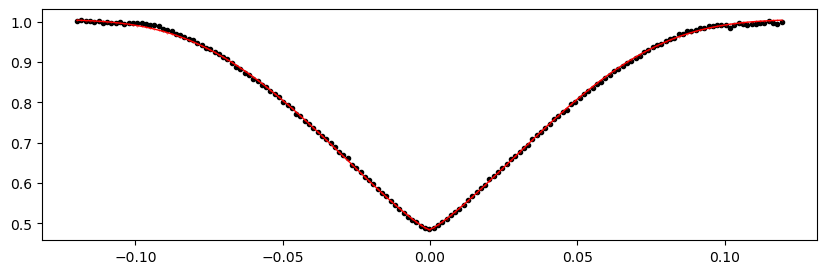

1709.1321961719998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.74it/s]


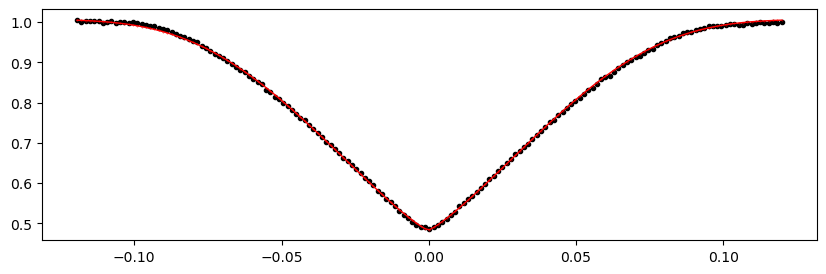

1710.084573808 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.21it/s]


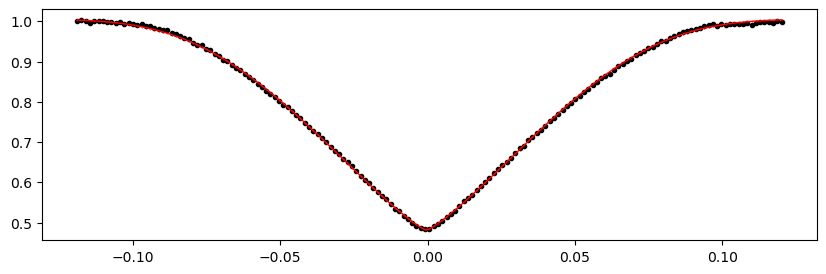

1711.9893290799998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.40it/s]


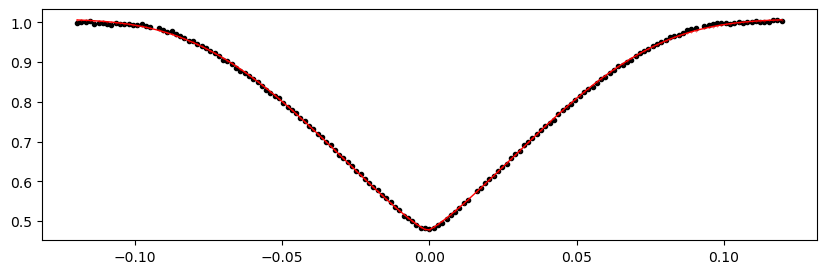

1712.941706716 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.18it/s]


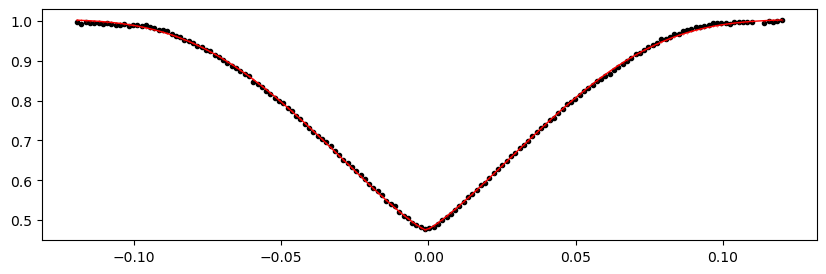

1713.894084352 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.99it/s]


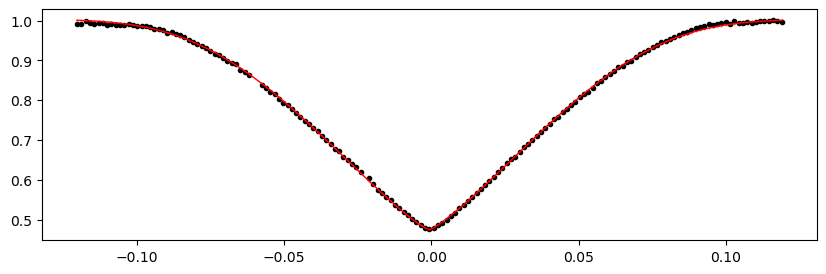

1714.8464619879999 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.34it/s]


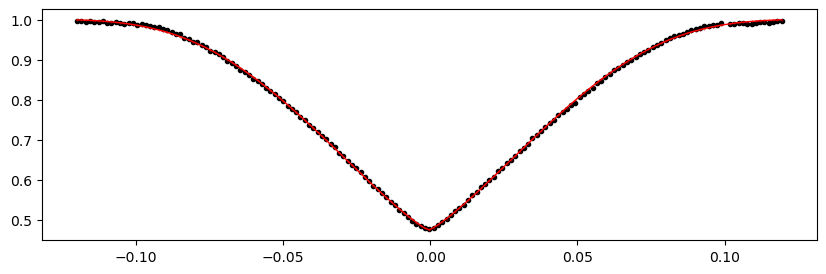

1715.7988396239998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.61it/s]


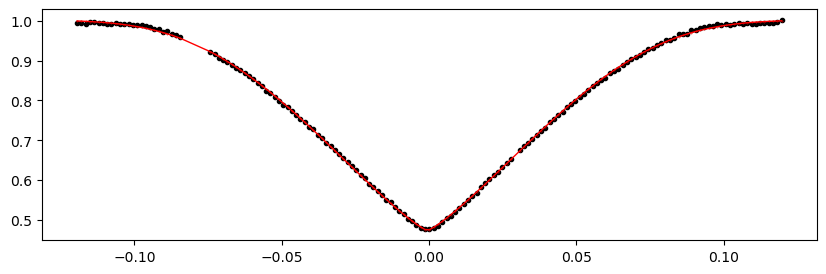

1716.75121726 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.95it/s]


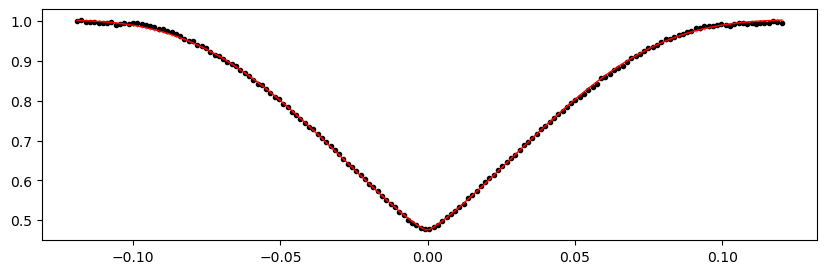

1717.703594896 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.65it/s]


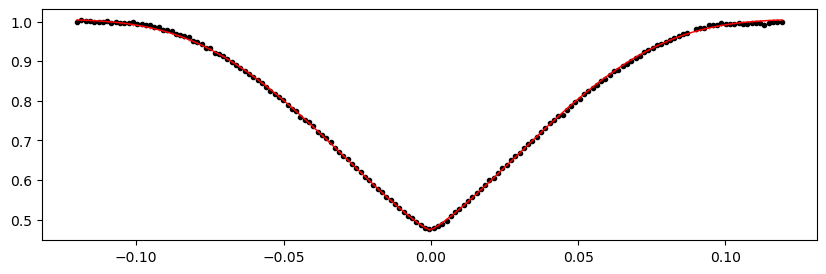

1718.6559725319999 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.59it/s]


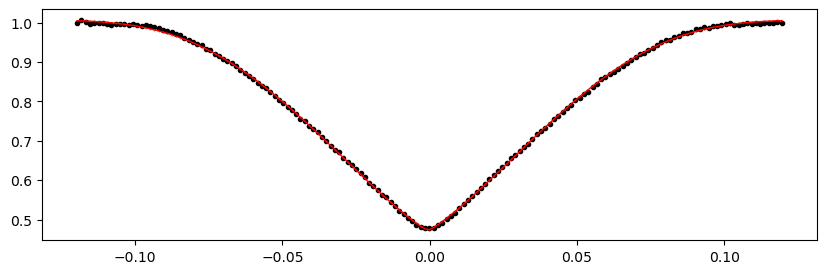

1719.6083501679998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.03it/s]


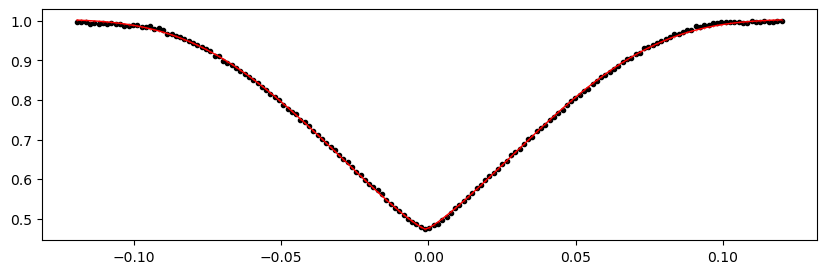

1720.560727804 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.50it/s]


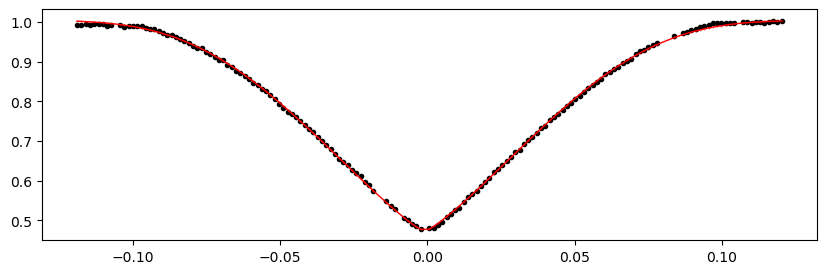

1721.51310544 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.35it/s]


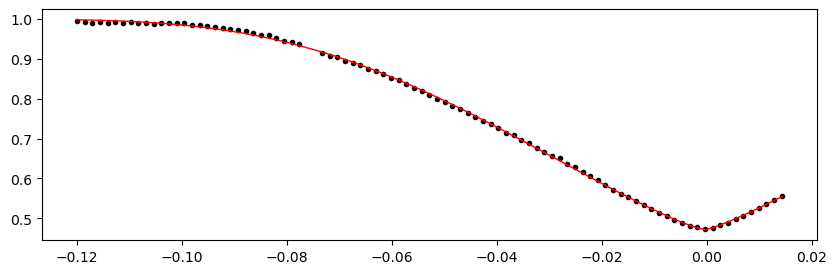

1725.3226159839999 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.03it/s]


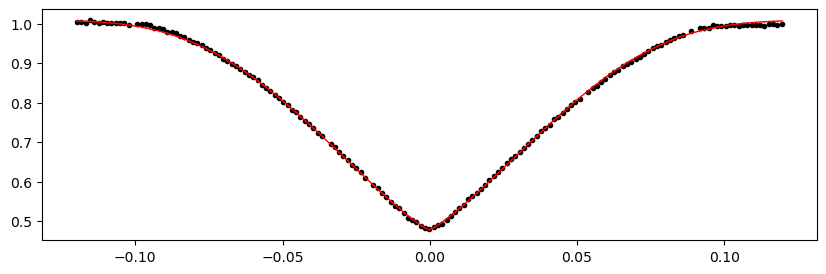

1726.2749936199998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.34it/s]


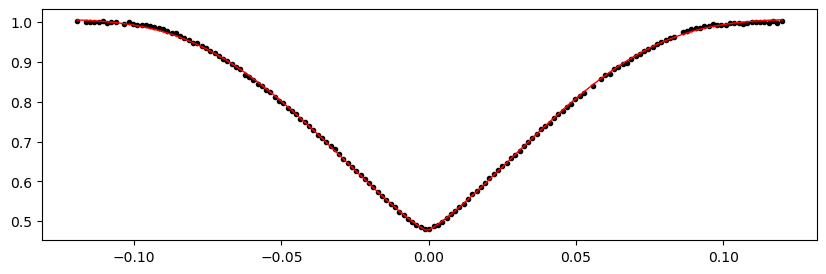

1727.227371256 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.46it/s]


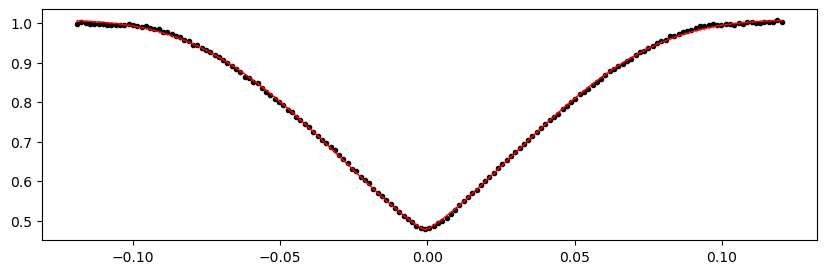

1728.179748892 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.26it/s]


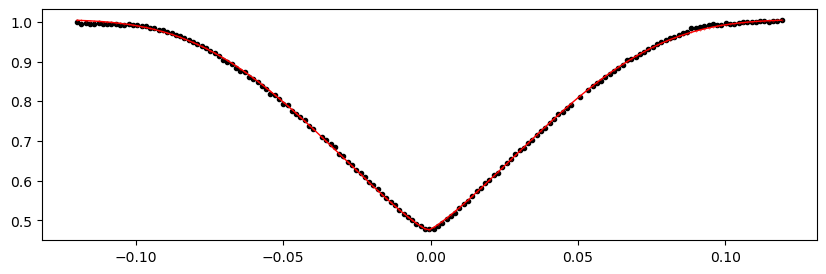

1729.1321265279998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.15it/s]


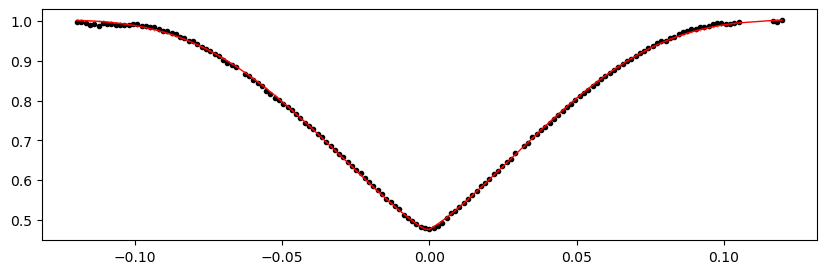

1730.084504164 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.28it/s]


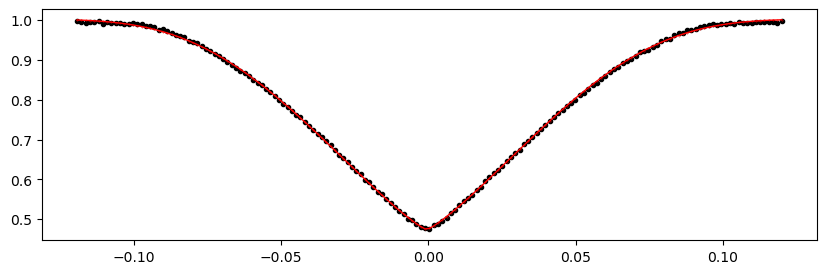

1731.0368818 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.18it/s]


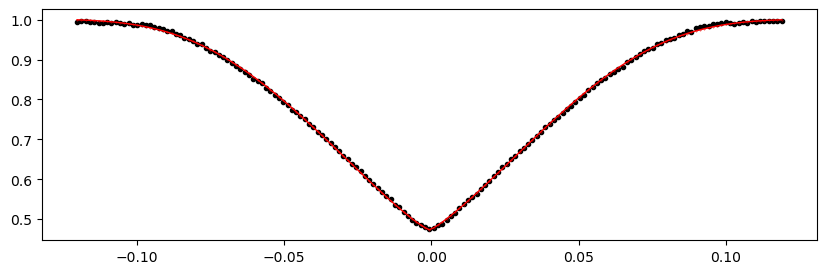

1731.9892594359999 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.30it/s]


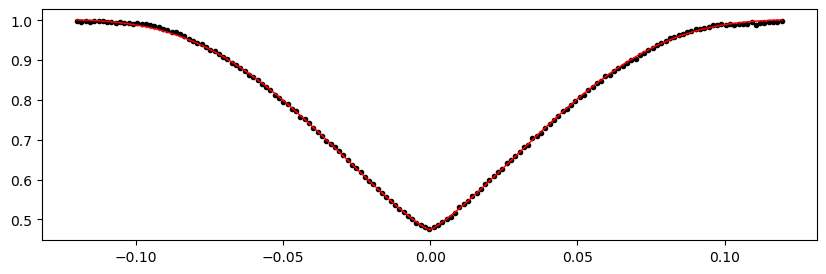

1732.9416370719998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.64it/s]


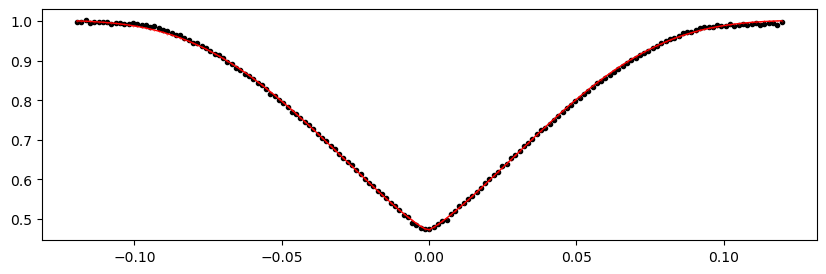

1733.894014708 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.12it/s]


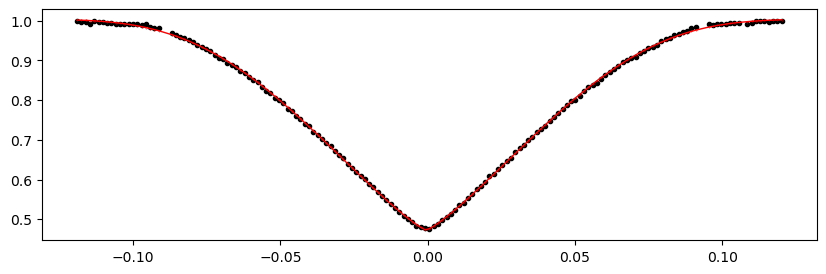

1734.846392344 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.62it/s]


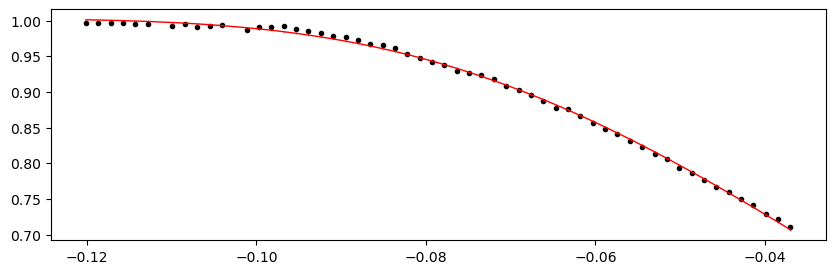

2391.034583548 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.32it/s]


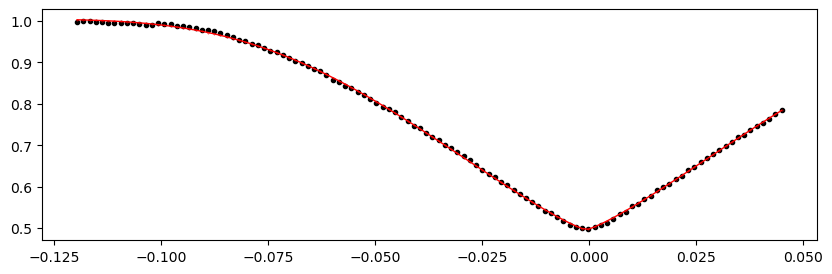

2393.891716456 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.76it/s]


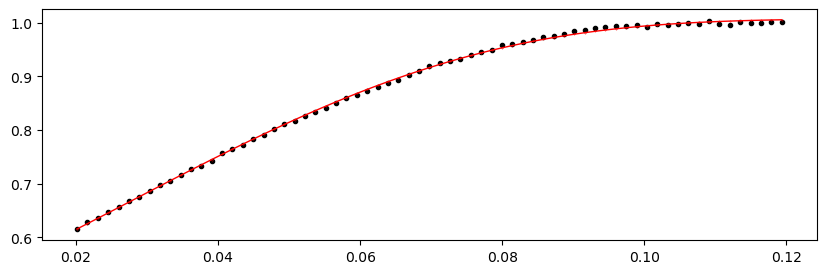

2394.844094092 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.09it/s]


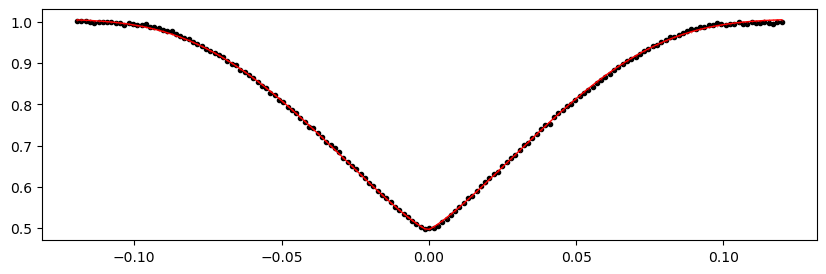

2395.796471728 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.39it/s]


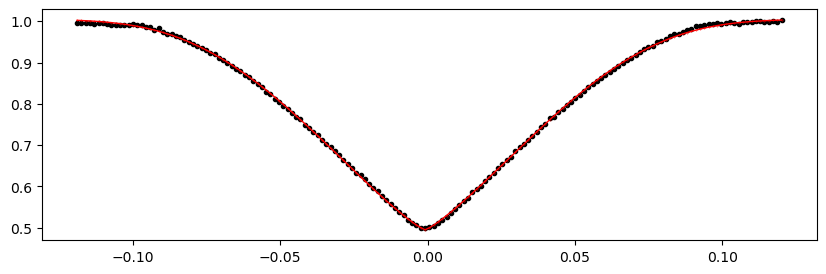

2396.748849364 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.51it/s]


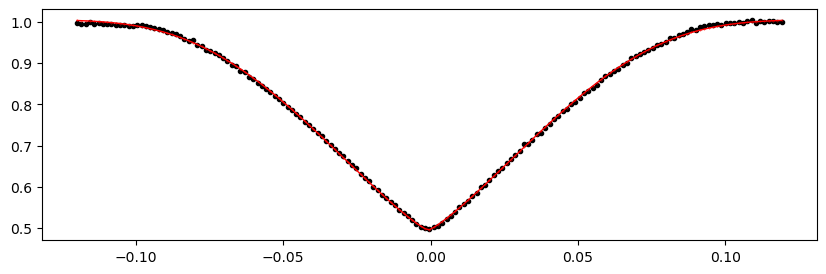

2397.701227 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.84it/s]


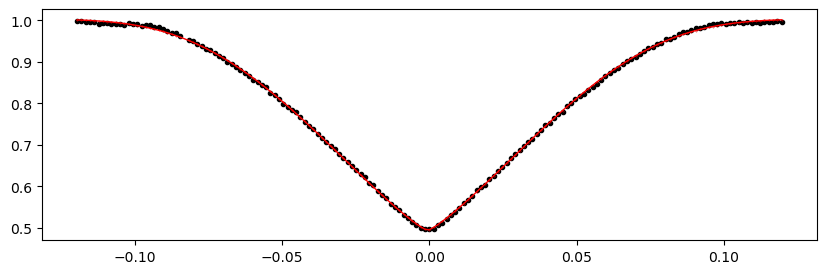

2398.6536046359997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.75it/s]


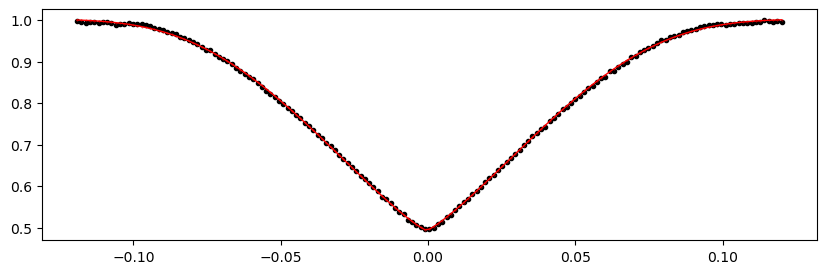

2399.605982272 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.79it/s]


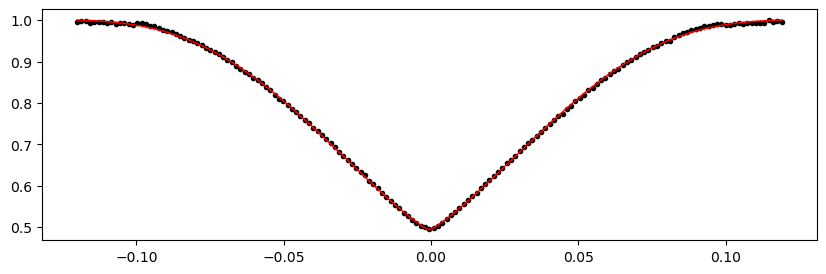

2400.558359908 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.24it/s]


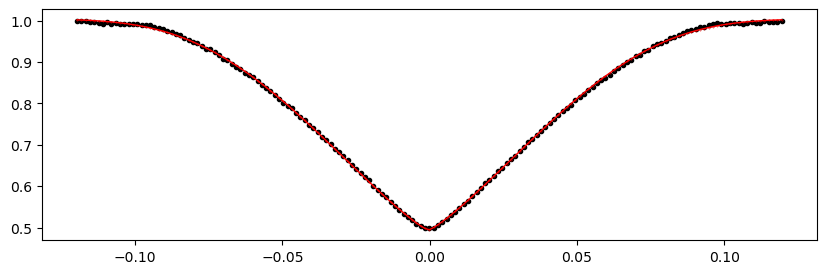

2401.5107375439998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.66it/s]


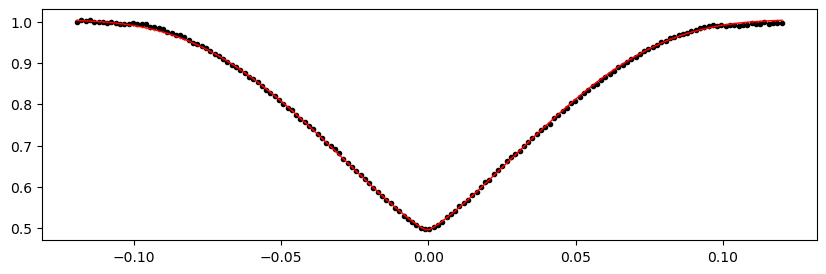

2402.46311518 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.64it/s]


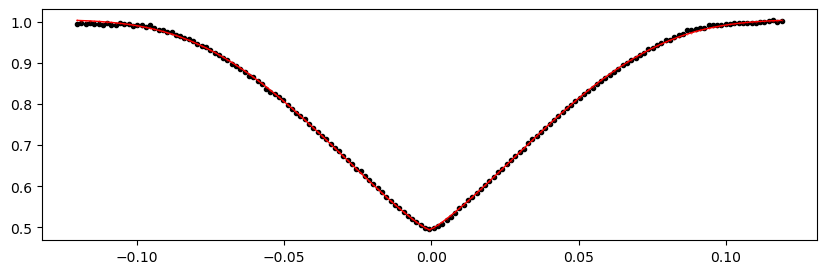

2403.4154928159996 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.62it/s]


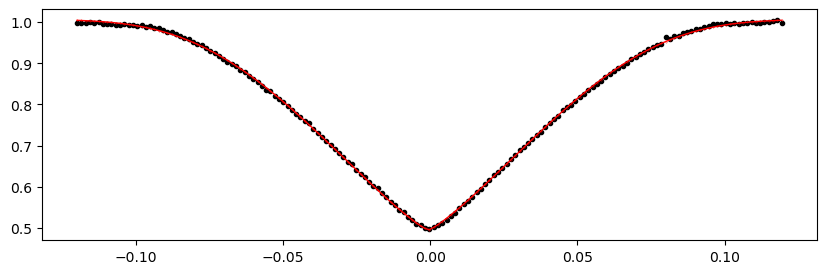

2404.367870452 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.01it/s]


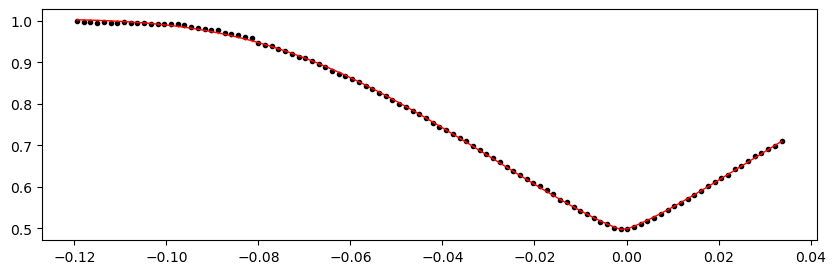

2408.177380996 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.81it/s]


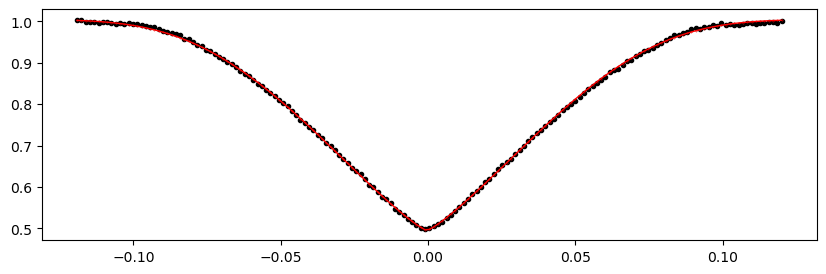

2409.1297586319997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.30it/s]


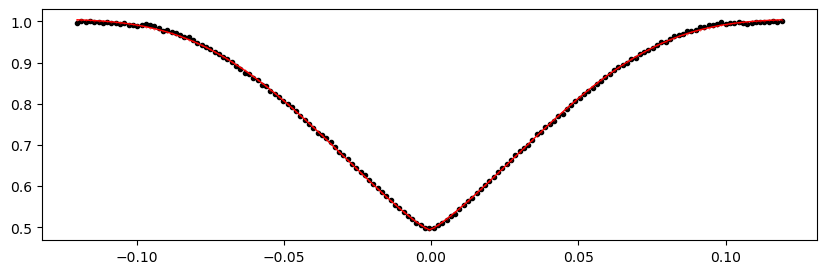

2410.082136268 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.29it/s]


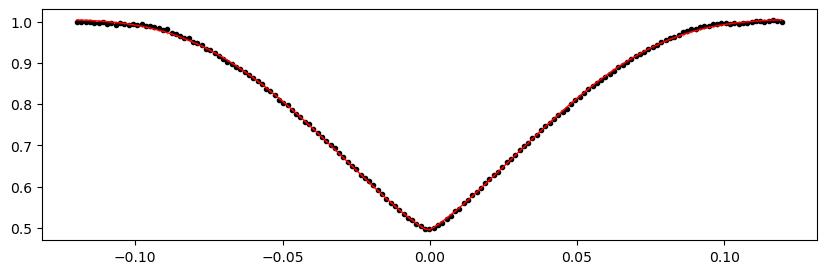

2411.034513904 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.61it/s]


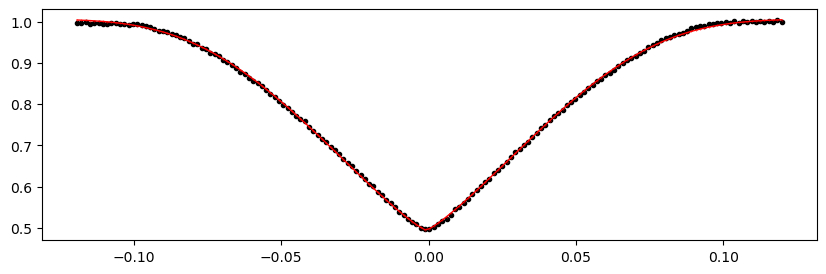

2411.9868915399998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.08it/s]


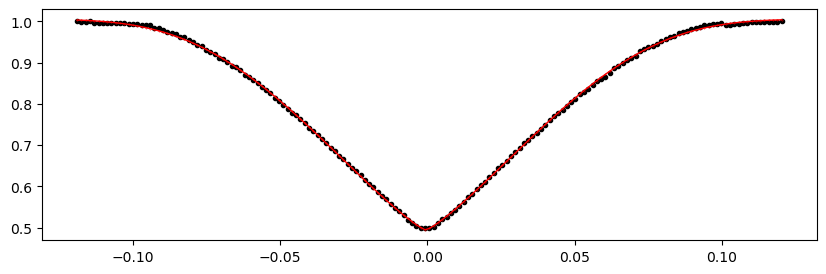

2412.939269176 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.76it/s]


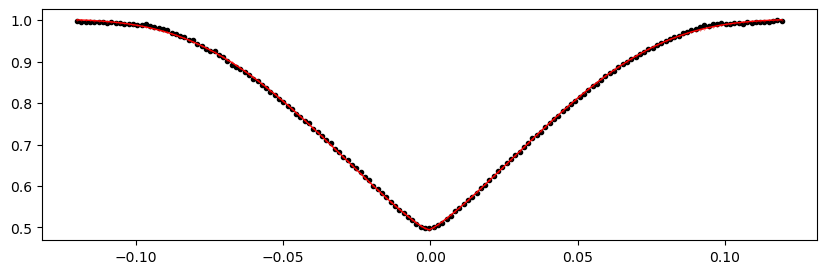

2413.8916468119996 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.64it/s]


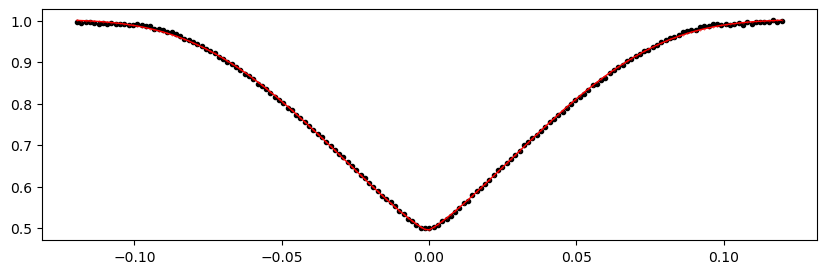

2414.844024448 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.44it/s]


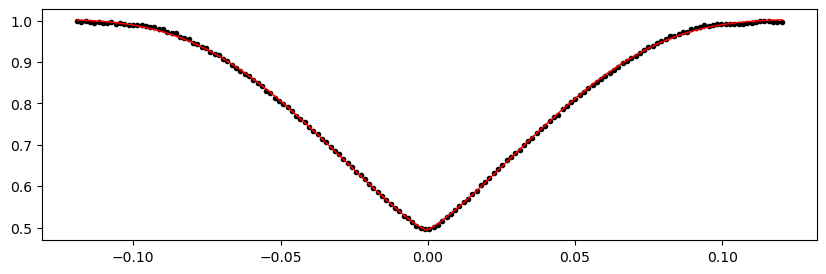

2415.796402084 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.45it/s]


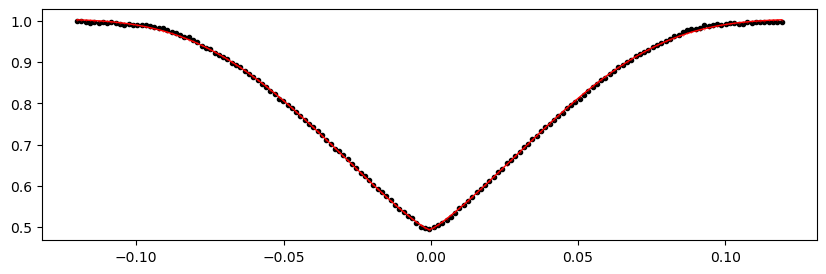

2416.74877972 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.04it/s]


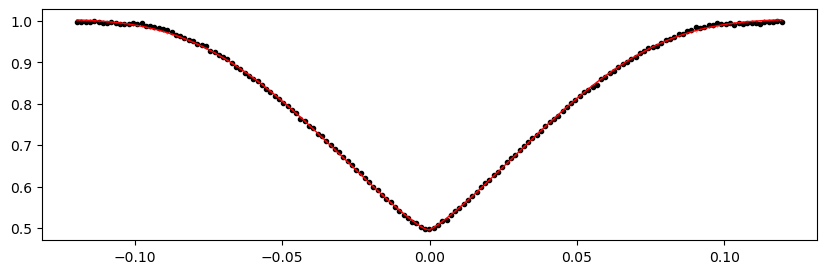

2417.701157356 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.03it/s]


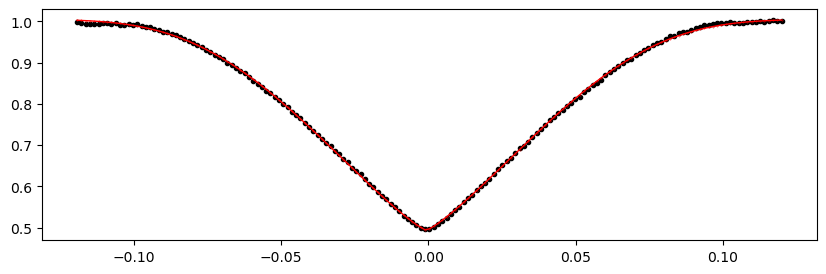

2418.653534992 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.47it/s]


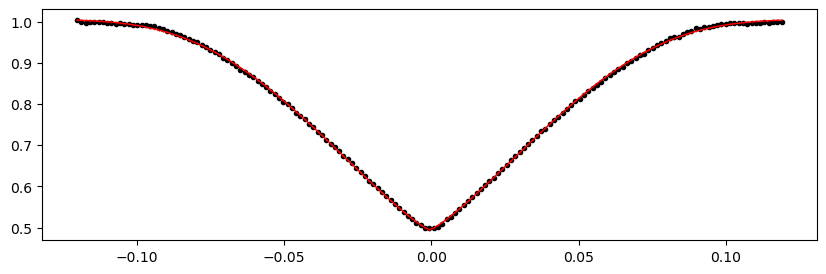

2420.558290264 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.62it/s]


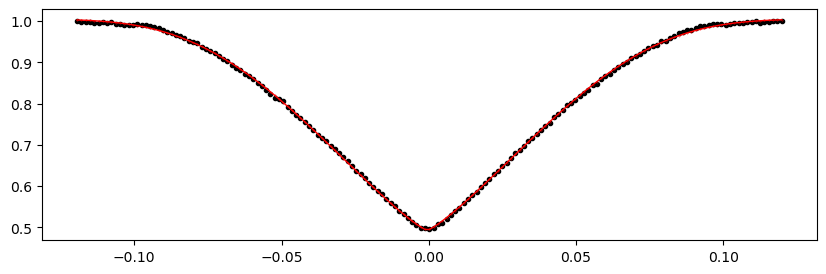

2421.5106679 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.16it/s]


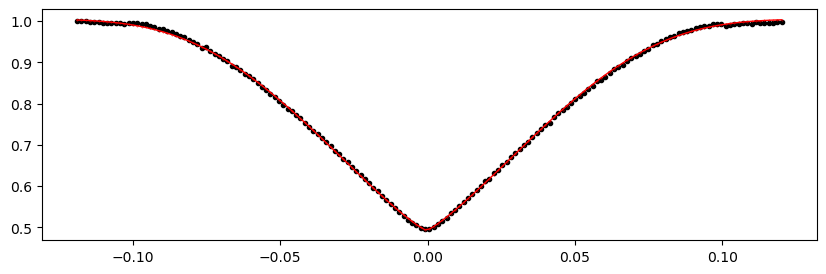

2422.4630455359998 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.48it/s]


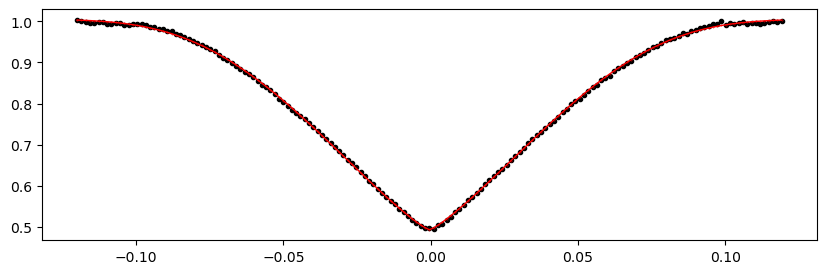

2423.415423172 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.08it/s]


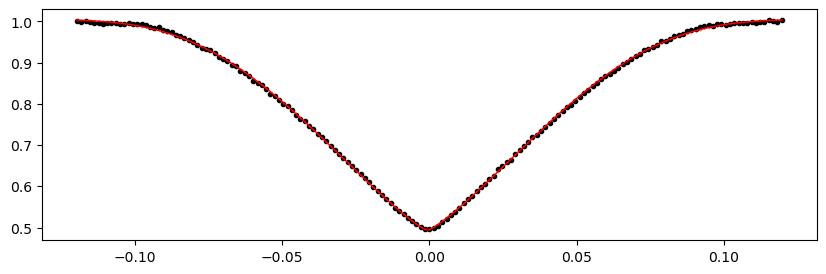

2424.367800808 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.48it/s]


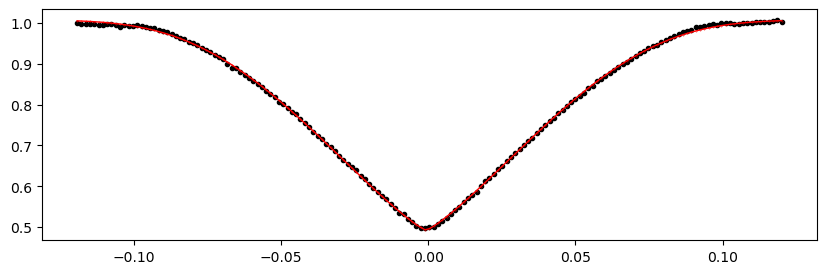

2425.320178444 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.54it/s]


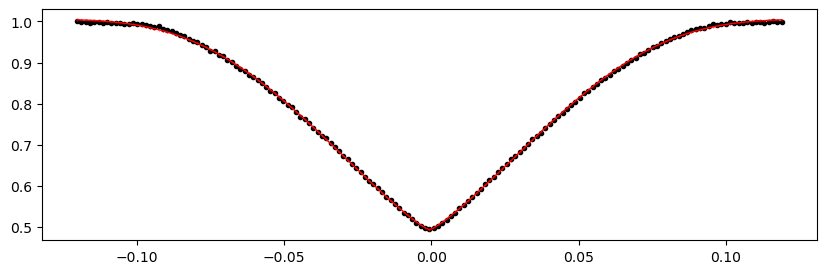

2426.27255608 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.55it/s]


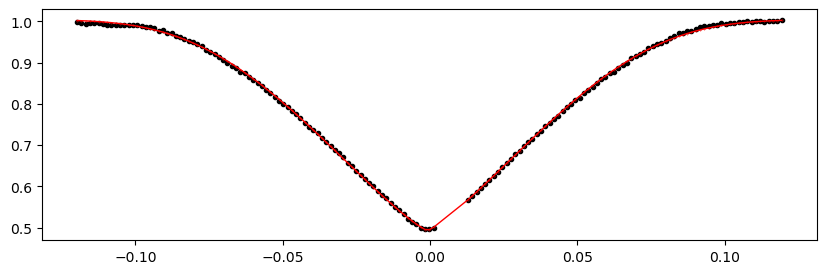

2427.224933716 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.85it/s]


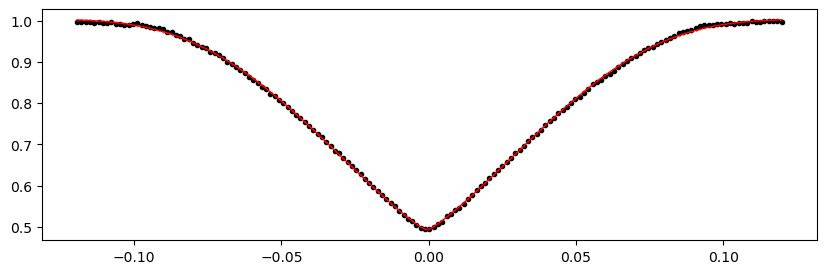

2428.177311352 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.94it/s]


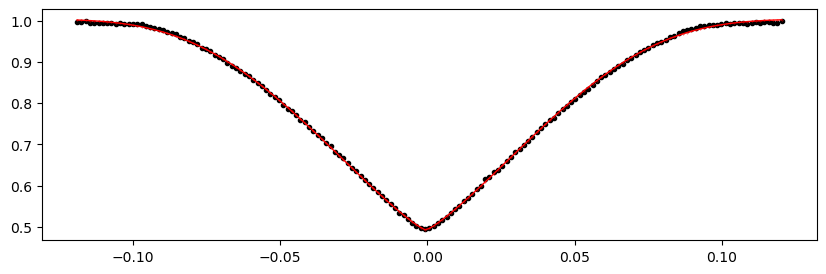

2429.129688988 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.15it/s]


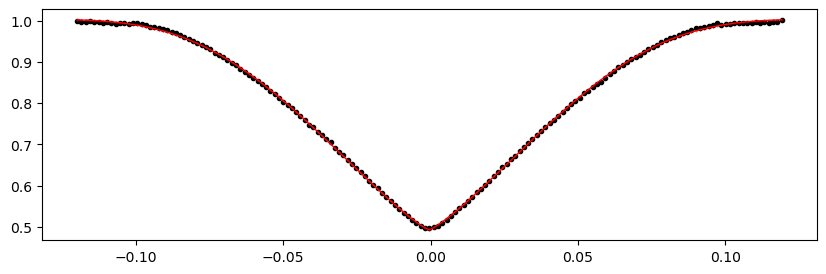

2430.0820666239997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.11it/s]


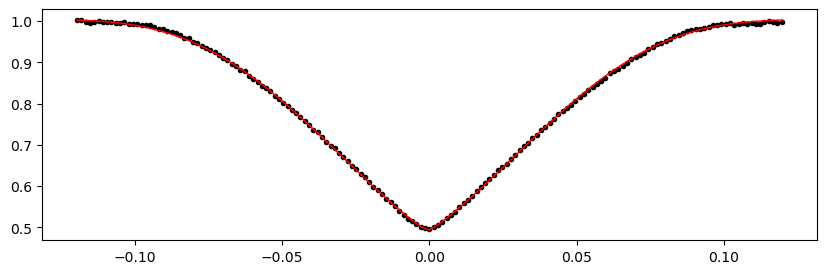

2431.03444426 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.92it/s]


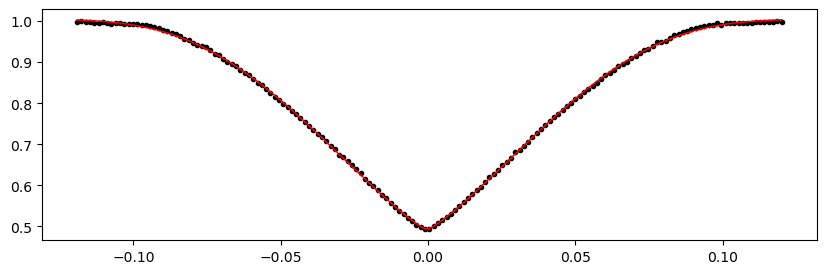

2431.986821896 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.52it/s]


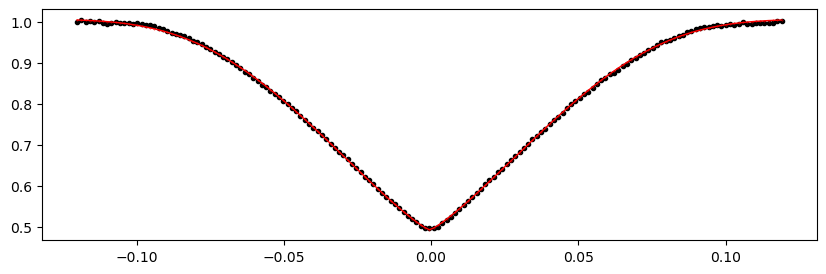

2433.891577168 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.82it/s]


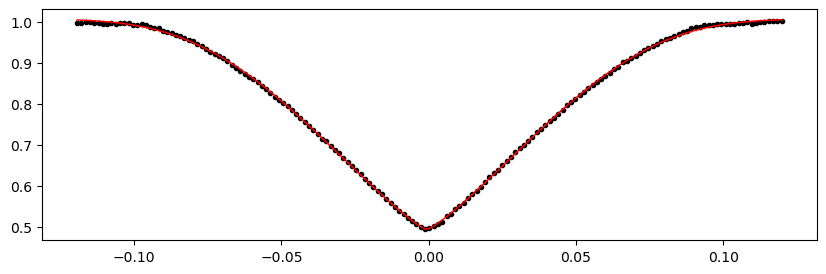

2434.843954804 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.04it/s]


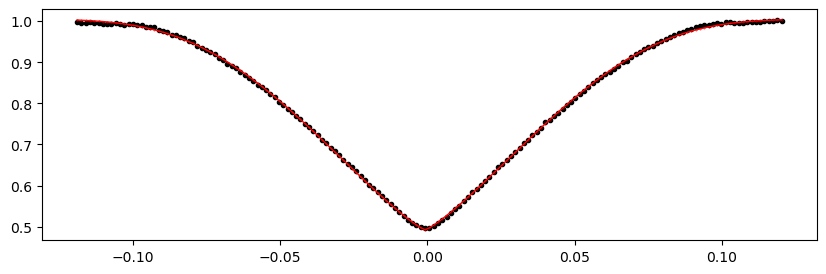

2435.79633244 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.67it/s]


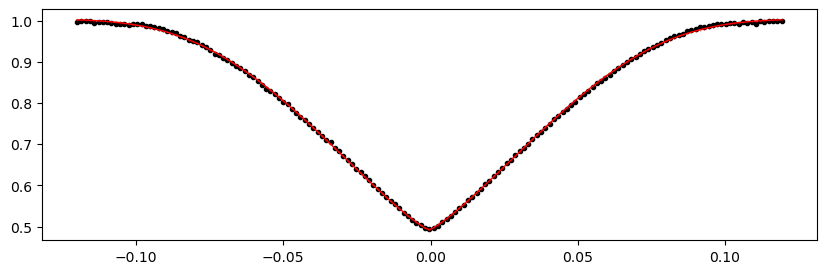

2436.748710076 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.04it/s]


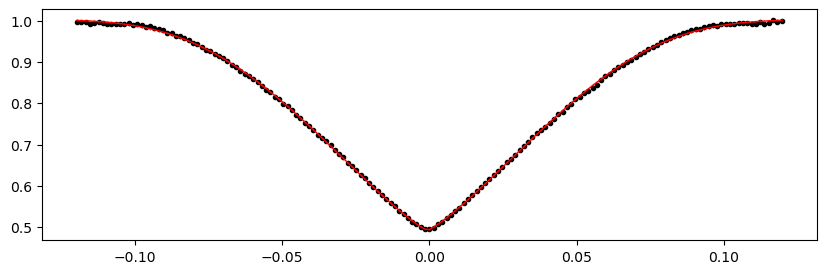

2437.701087712 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.39it/s]


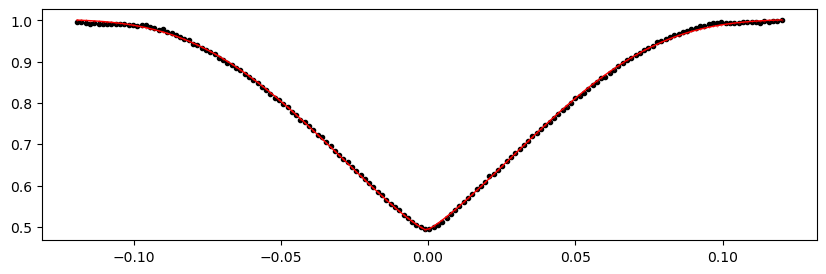

2438.653465348 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.40it/s]


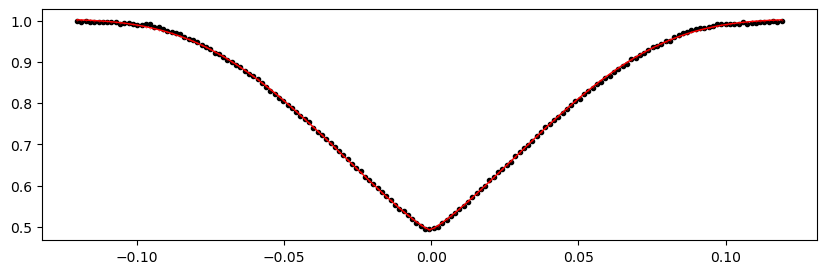

2439.605842984 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.53it/s]


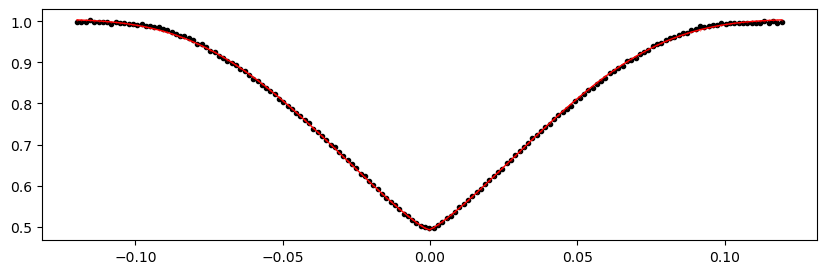

2440.5582206199997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.60it/s]


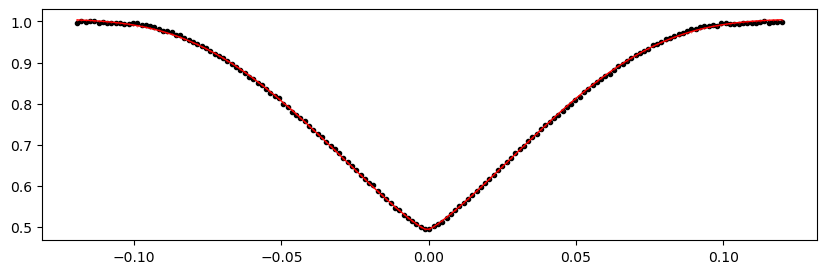

2441.510598256 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.97it/s]


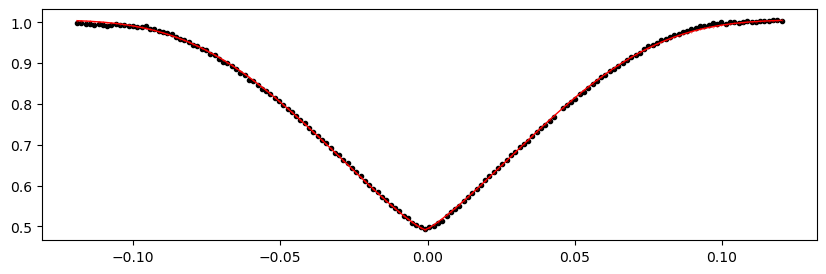

2442.462975892 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.64it/s]


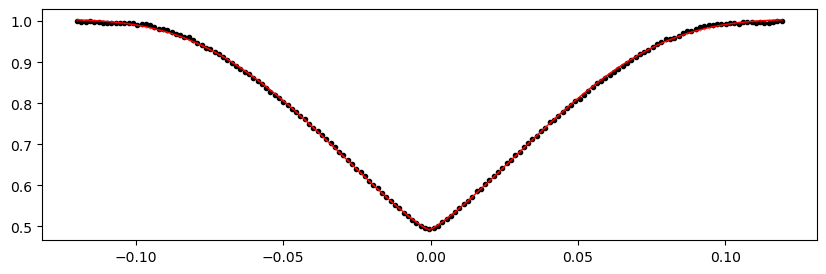

2443.415353528 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.63it/s]


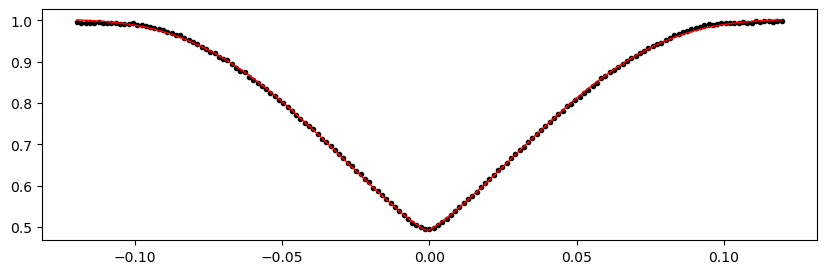

2444.367731164 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.60it/s]


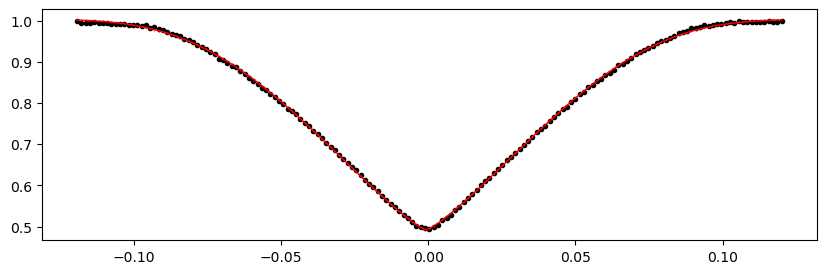

2445.3201088 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.43it/s]


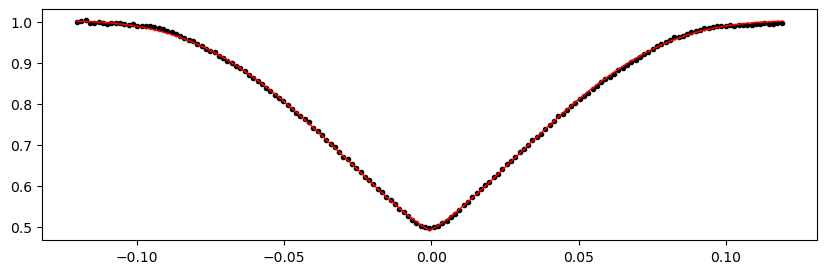

2446.272486436 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.39it/s]


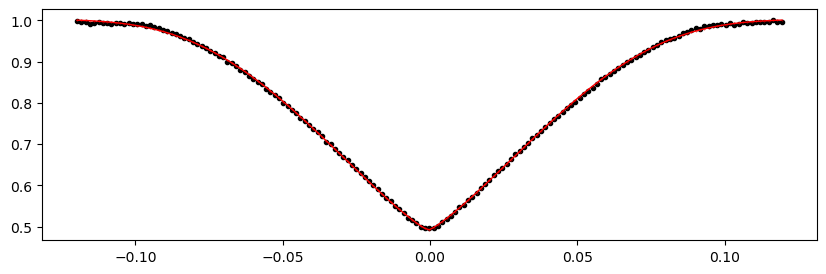

2770.080882676 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.58it/s]


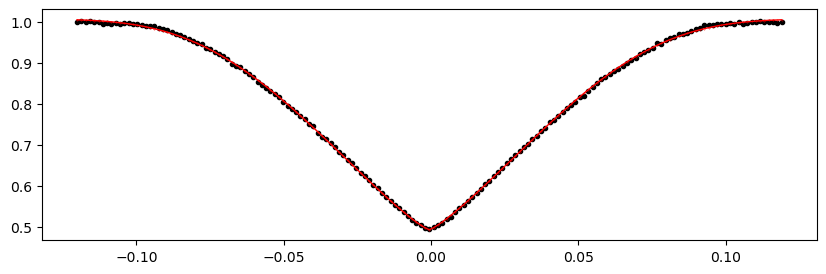

2771.0332603119996 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.62it/s]


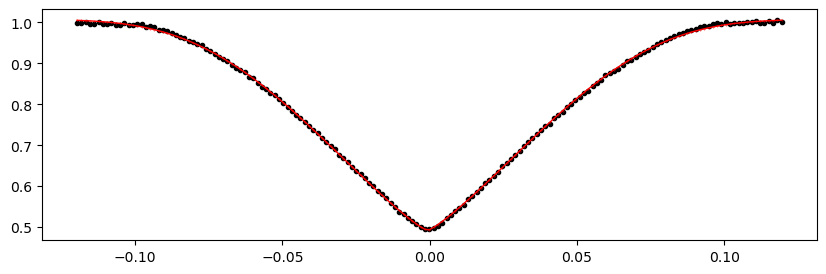

2771.9856379479997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.31it/s]


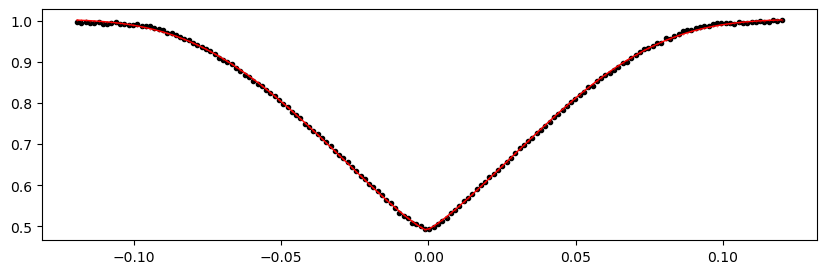

2772.938015584 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.47it/s]


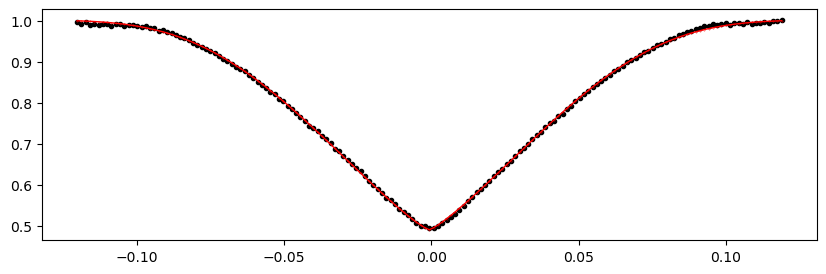

2773.89039322 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.90it/s]


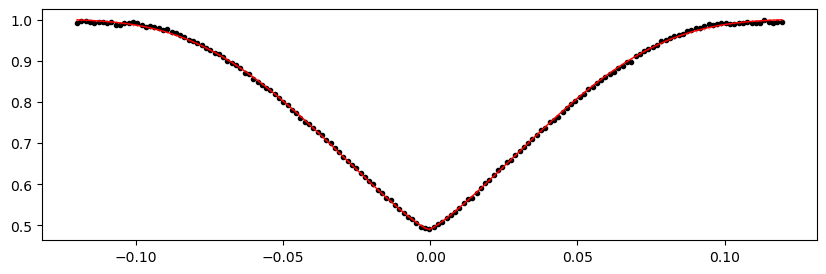

2774.8427708560002 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.42it/s]


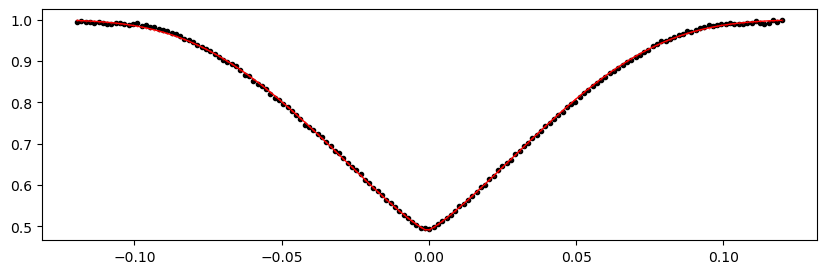

2775.795148492 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.22it/s]


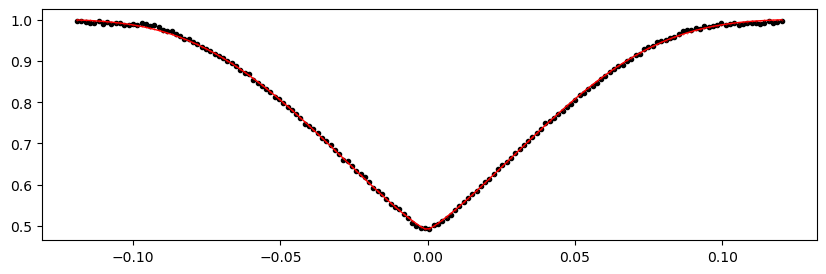

2776.7475261279997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.08it/s]


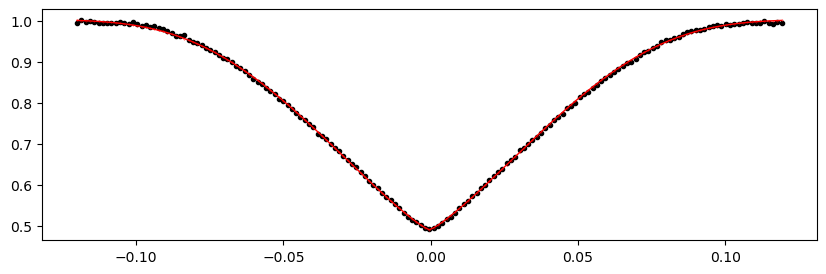

2777.699903764 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.23it/s]


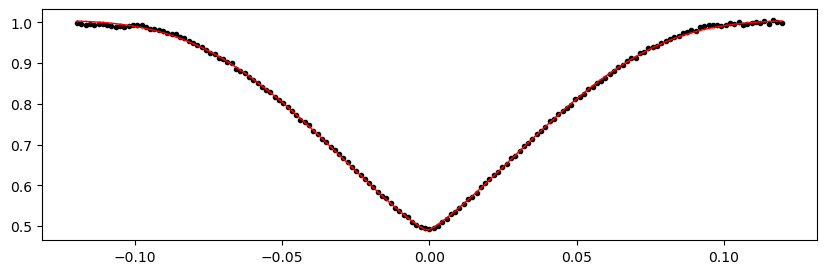

2778.6522814 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.78it/s]


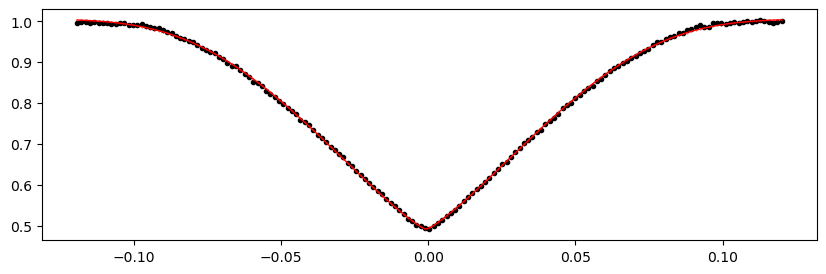

2779.604659036 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.05it/s]


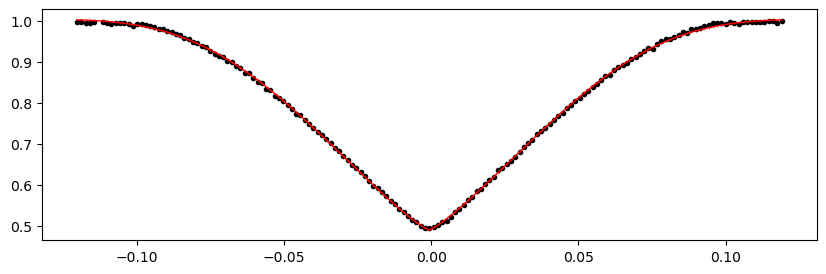

2780.557036672 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.22it/s]


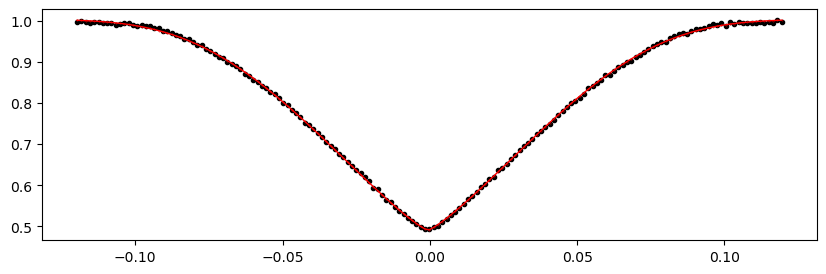

2781.509414308 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.17it/s]


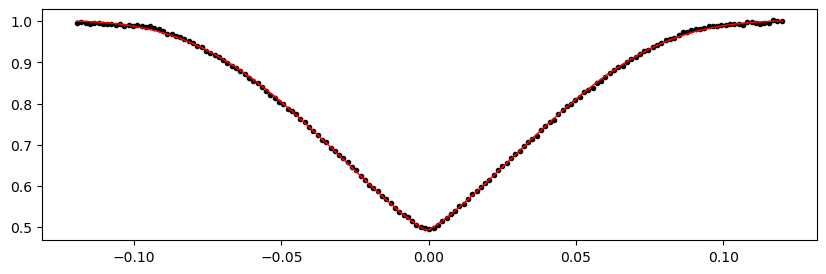

2784.366547216 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.86it/s]


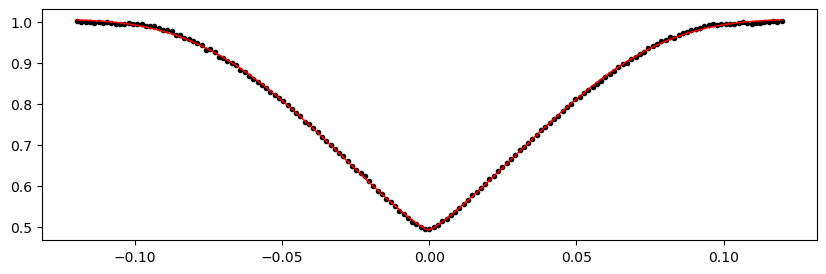

2785.3189248520002 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.60it/s]


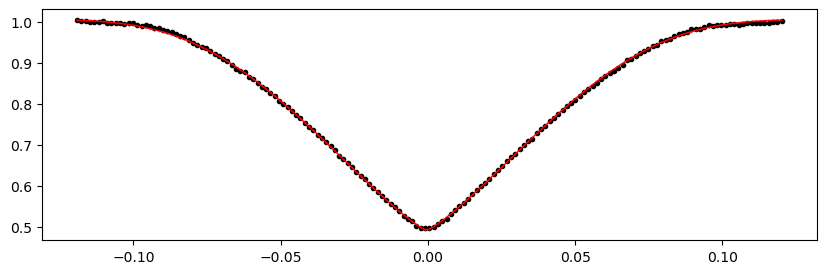

2786.271302488 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.41it/s]


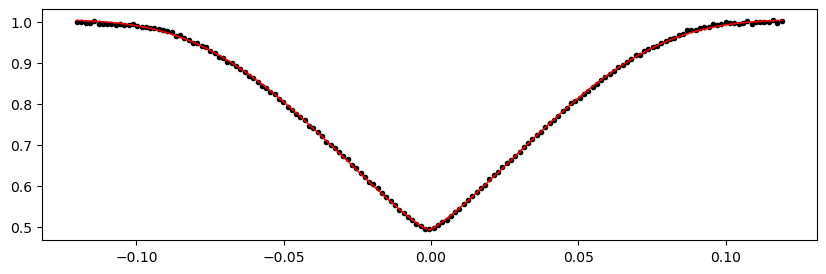

2787.2236801239997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.91it/s]


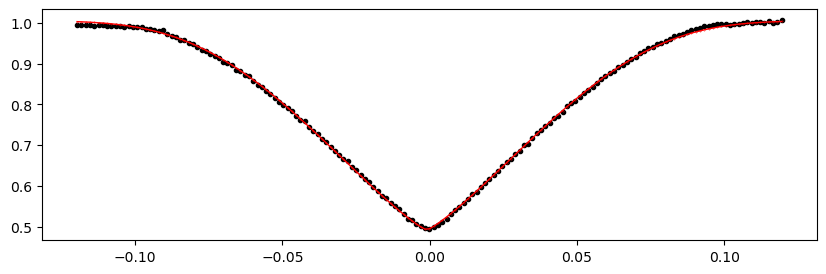

2788.17605776 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.50it/s]


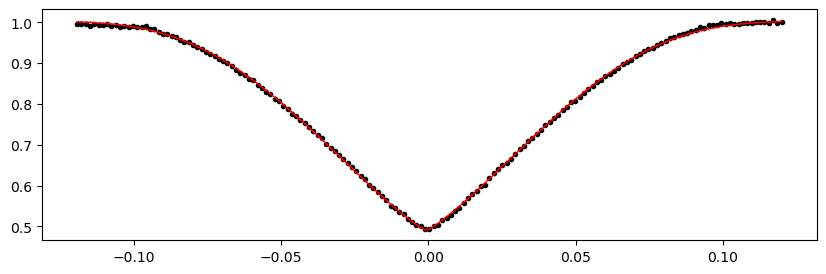

2789.128435396 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.45it/s]


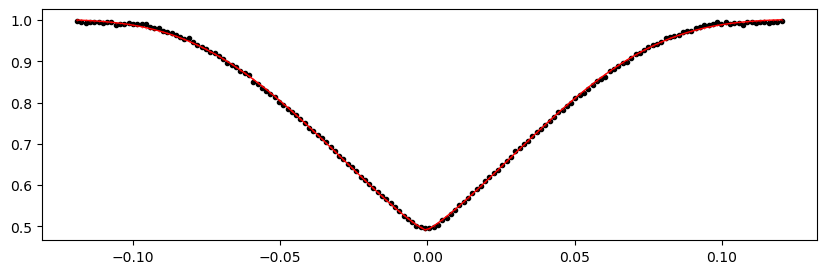

2790.080813032 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.42it/s]


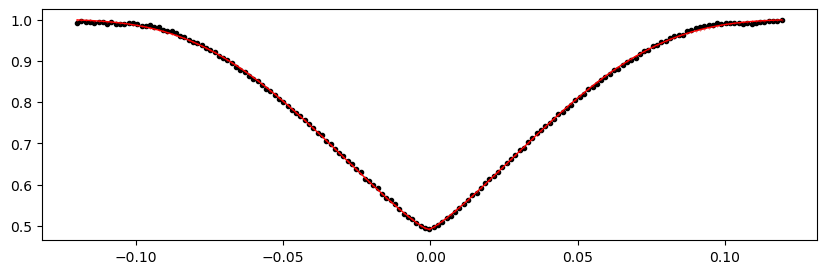

2791.033190668 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.27it/s]


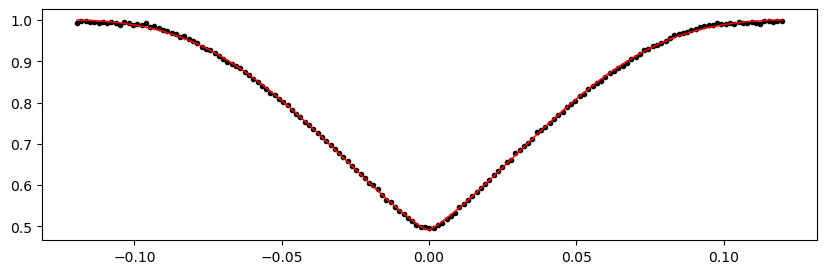

2791.985568304 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.83it/s]


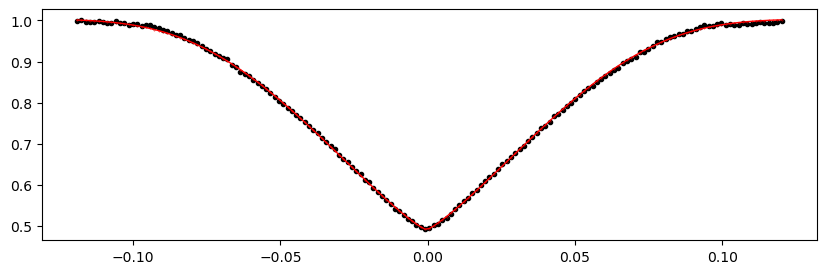

2792.9379459399997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.67it/s]


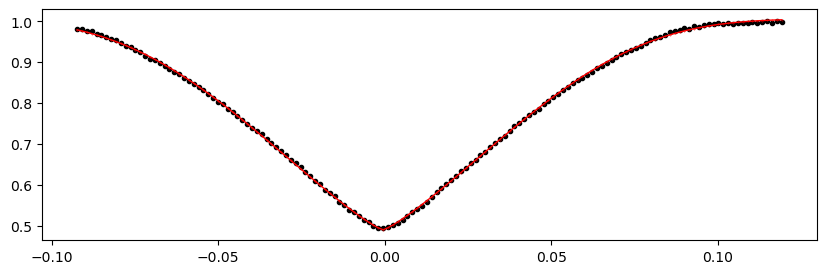

2793.890323576 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.41it/s]


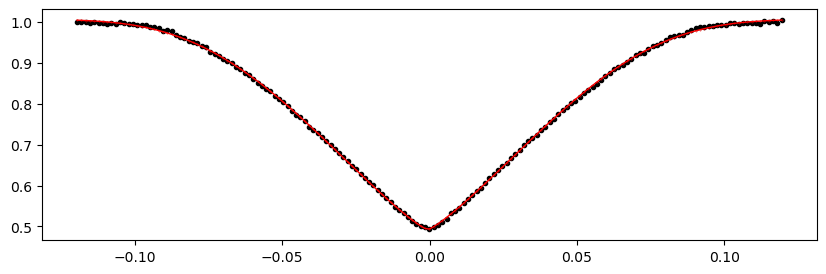

2794.842701212 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.21it/s]


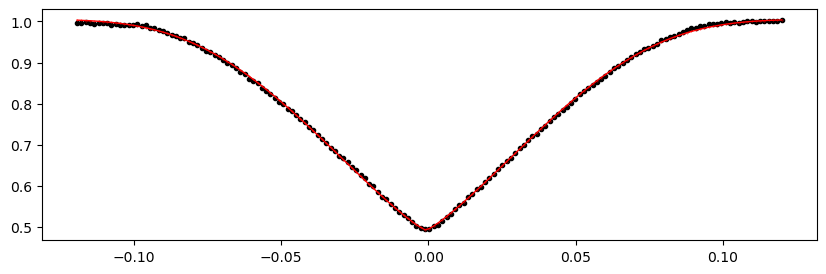

2795.7950788480002 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.10it/s]


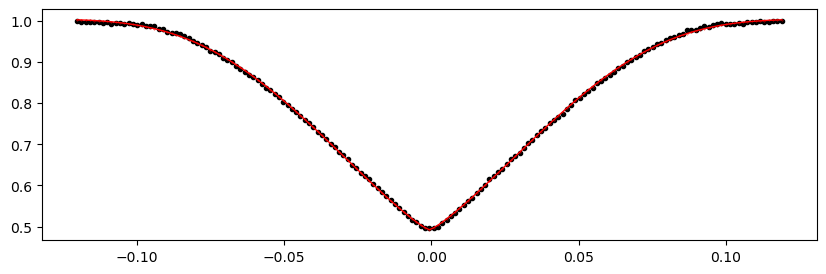

2797.6998341199997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.77it/s]


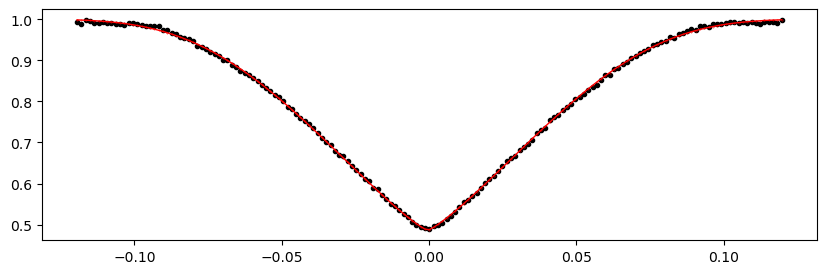

2798.652211756 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.47it/s]


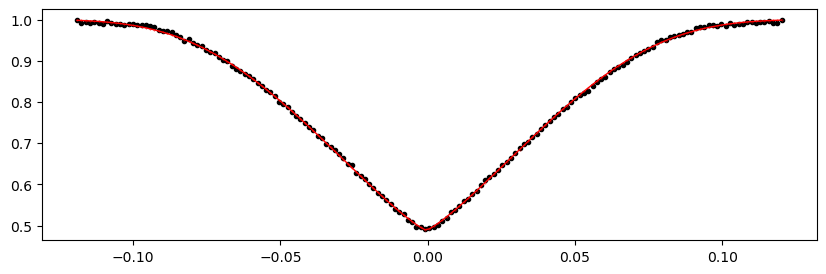

2799.604589392 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.38it/s]


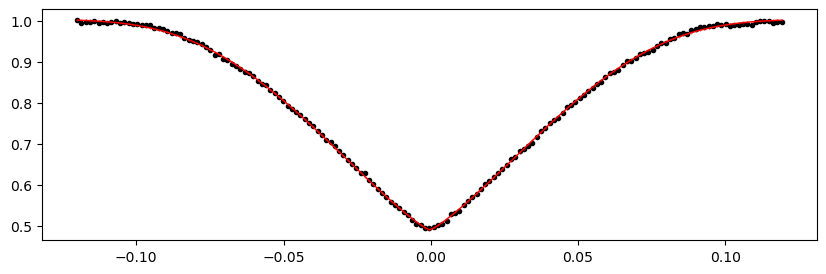

2800.556967028 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.59it/s]


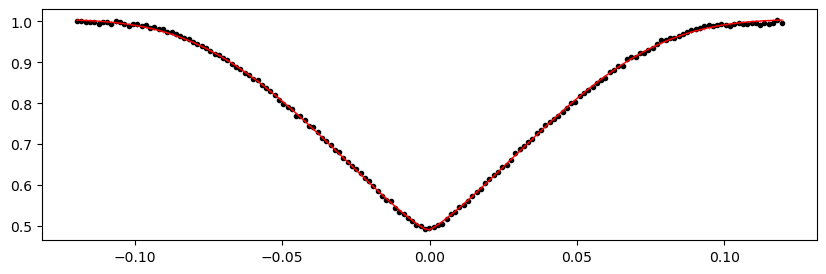

2801.509344664 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.10it/s]


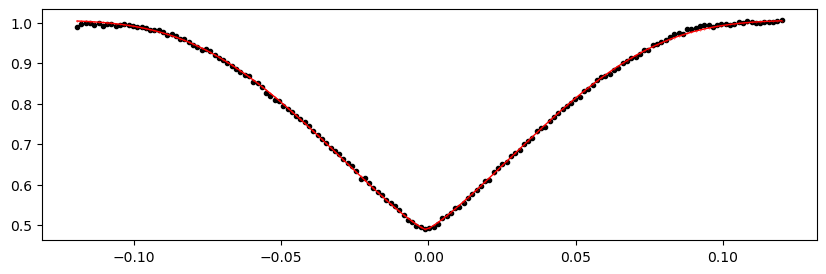

2802.4617223 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.96it/s]


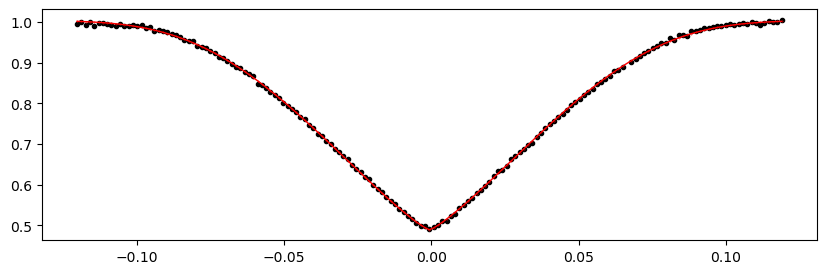

2803.4140999359997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.85it/s]


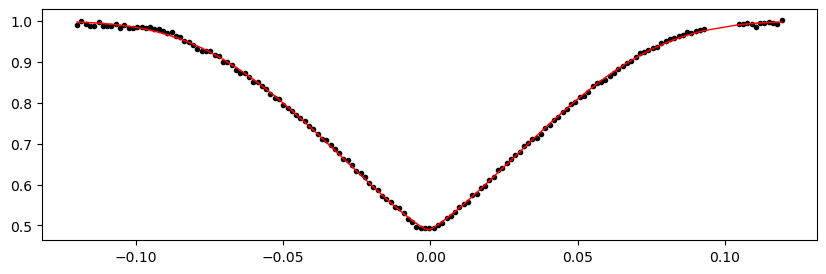

2804.366477572 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.64it/s]


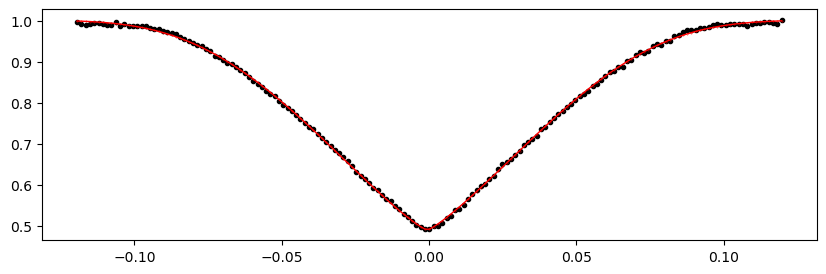

2805.318855208 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.37it/s]


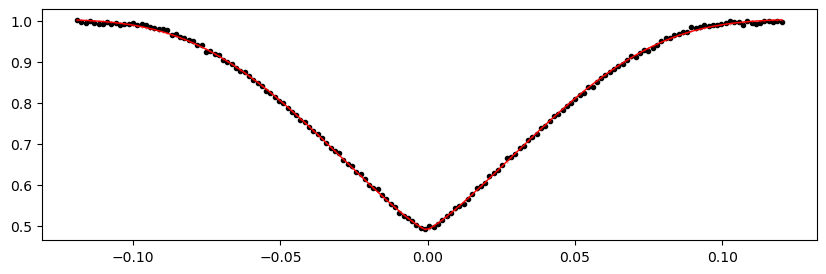

2806.271232844 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.19it/s]


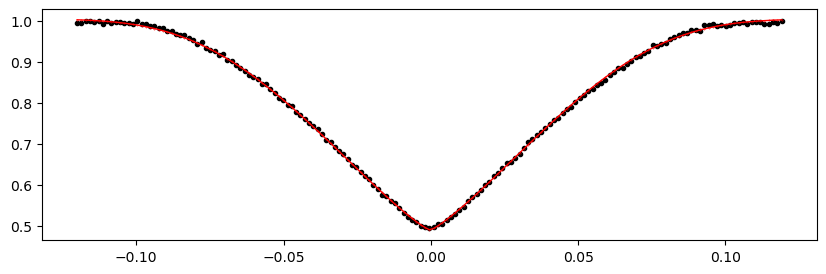

2807.22361048 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.00it/s]


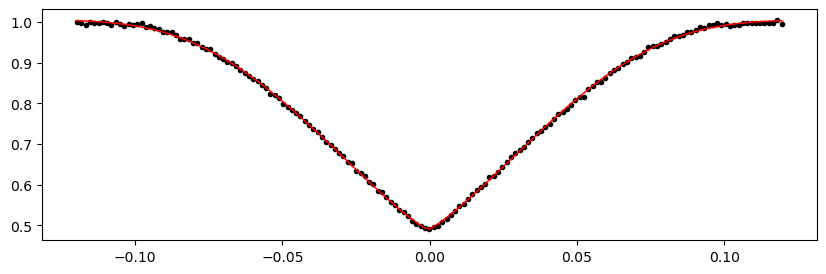

2808.1759881159996 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.83it/s]


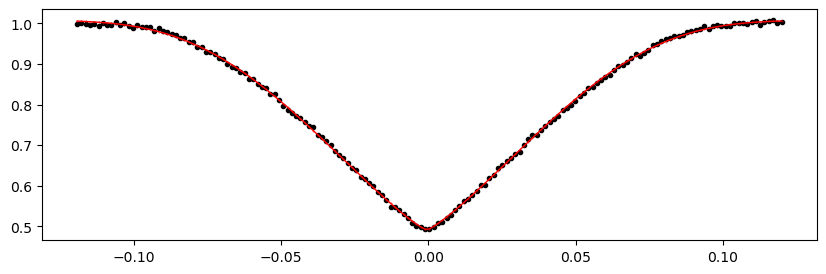

2809.128365752 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.04it/s]


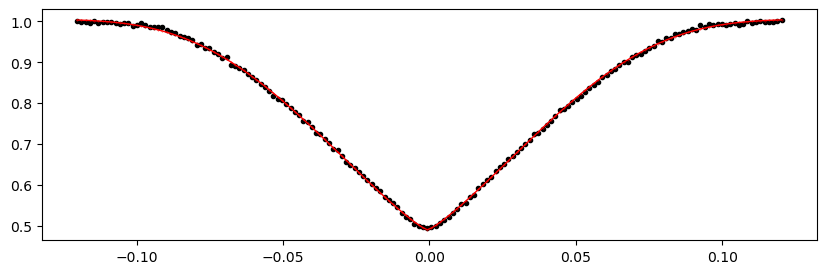

2811.033121024 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.79it/s]


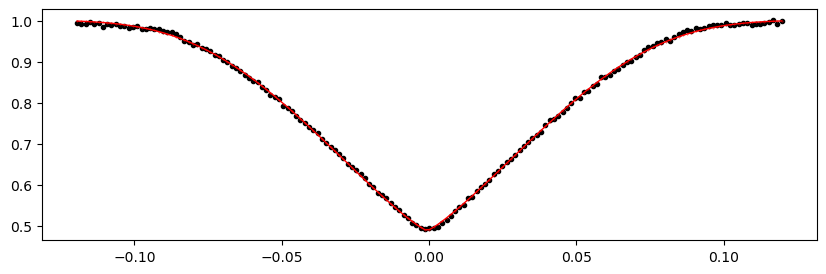

2811.98549866 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.14it/s]


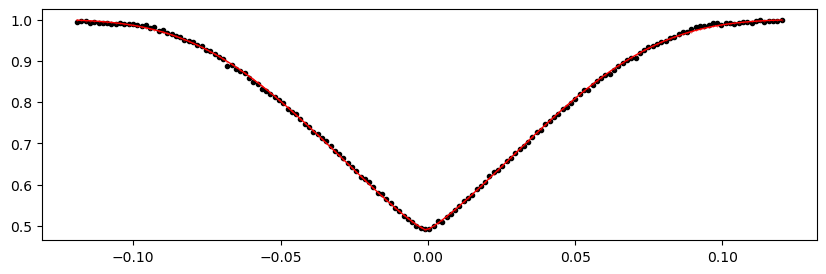

2812.937876296 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.77it/s]


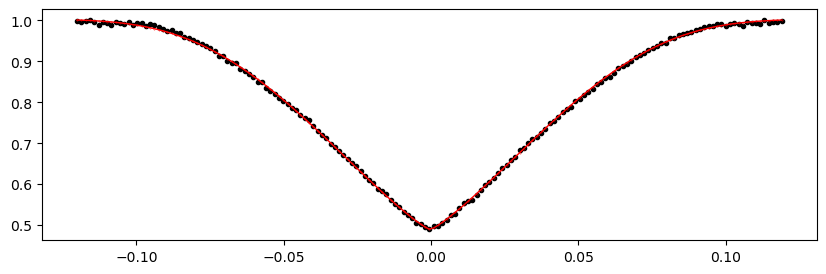

2813.8902539319997 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.68it/s]


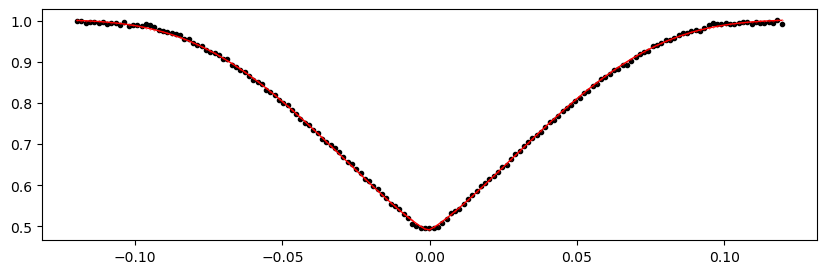

2814.842631568 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.81it/s]


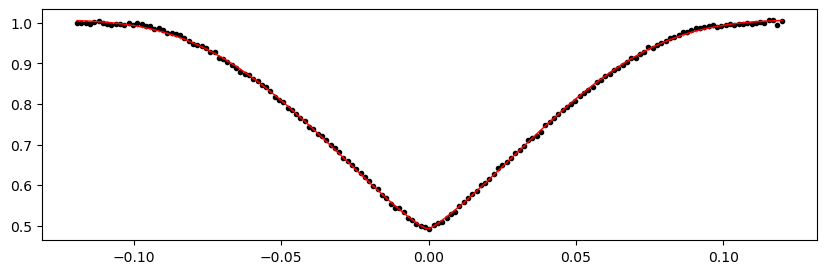

2815.795009204 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.56it/s]


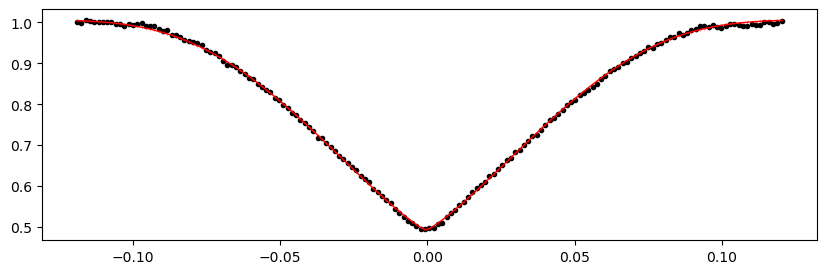

2816.74738684 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.45it/s]


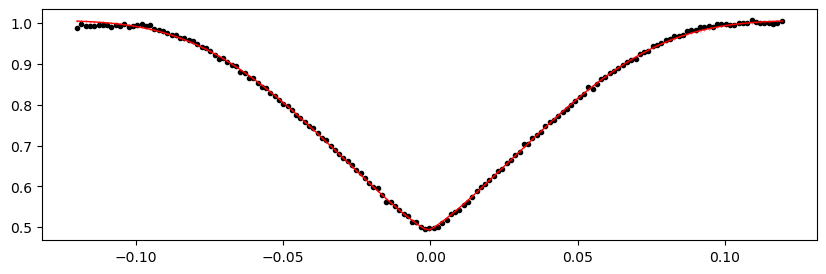

2817.699764476 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.39it/s]


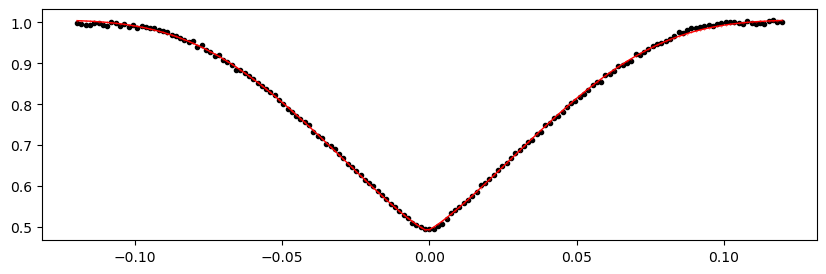

2818.6521421119996 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.04it/s]


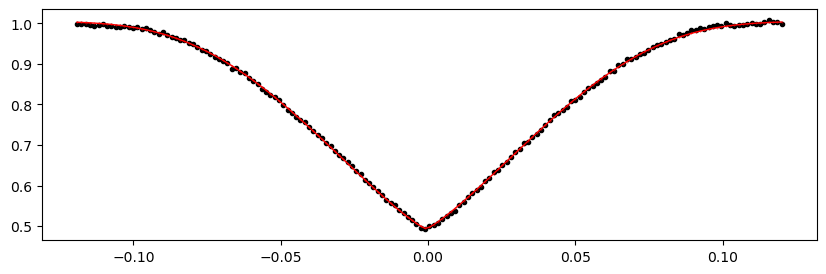

2819.604519748 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.44it/s]


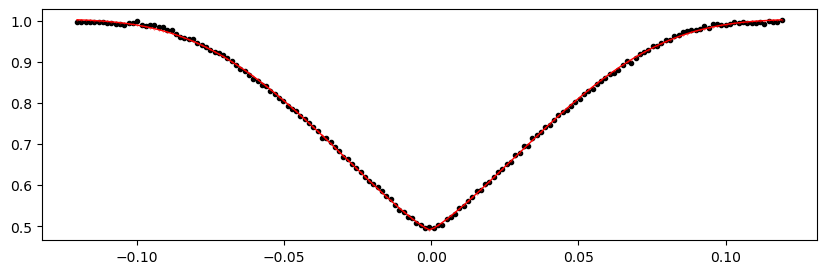

2820.556897384 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.98it/s]


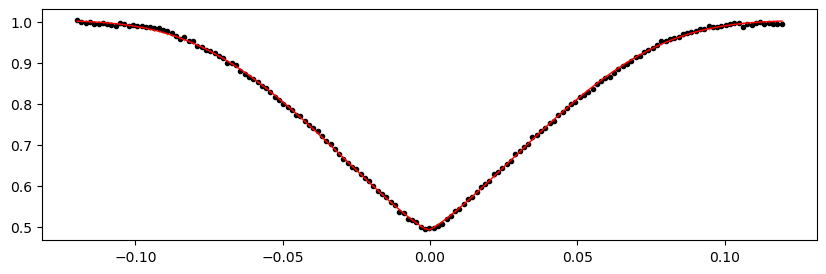

2821.50927502 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.70it/s]


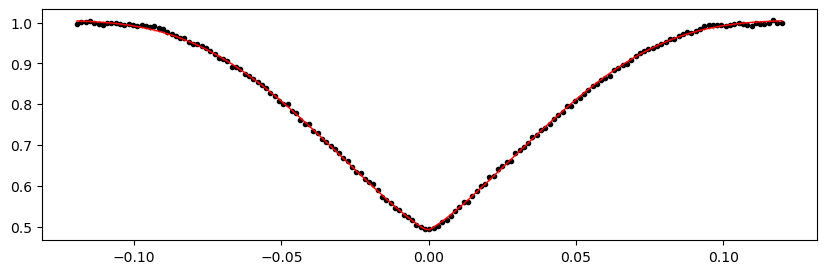

2822.461652656 1.0043642112402706 -0.5156728157898436 0.22443987809231702


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.41it/s]


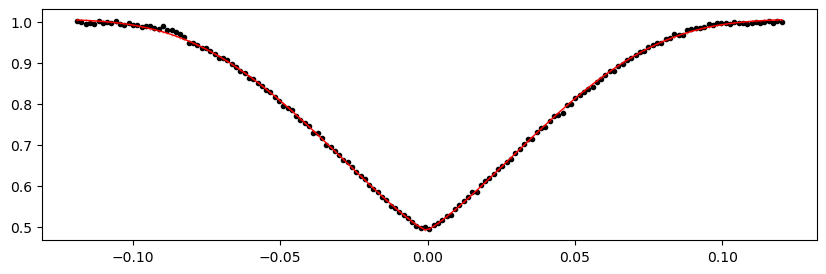

In [48]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=20, 
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
1691.513209906 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.80it/s]


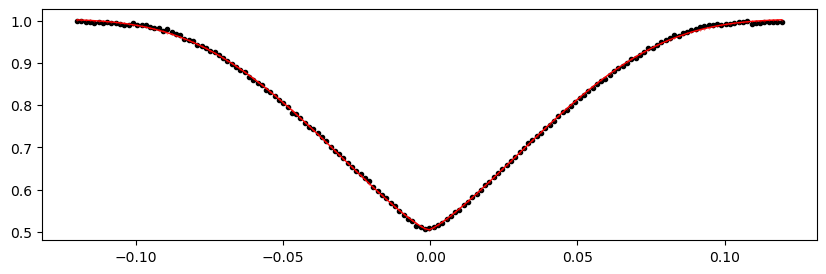

1692.4655875419999 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.34it/s]


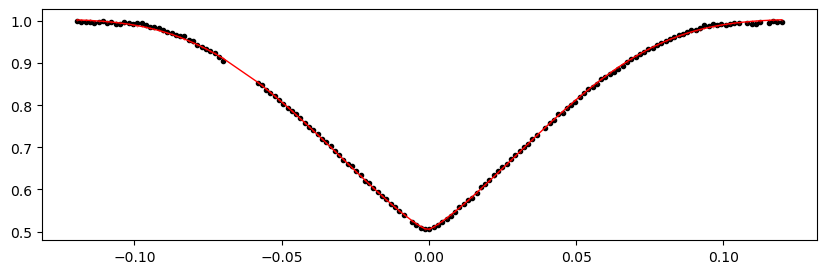

1693.417965178 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.90it/s]


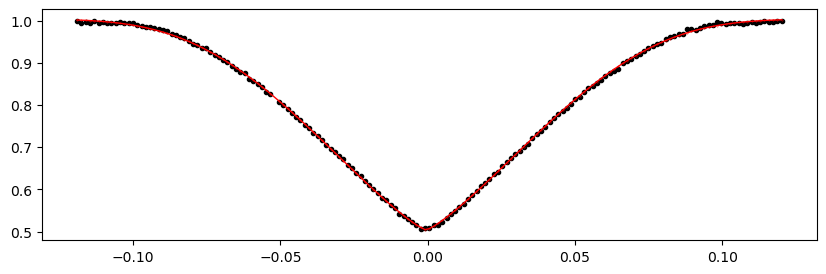

1694.370342814 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.82it/s]


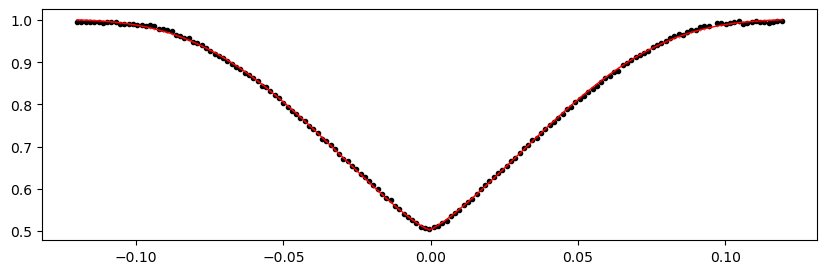

1695.32272045 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.83it/s]


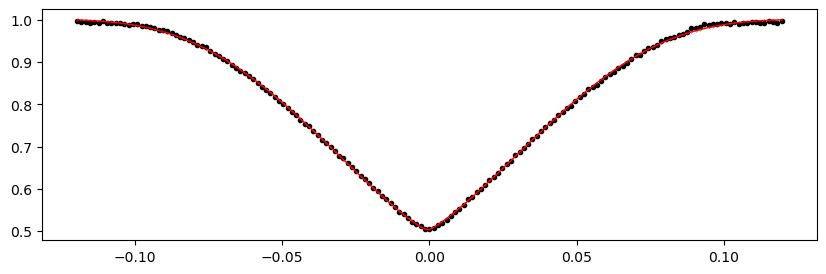

1696.275098086 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.58it/s]


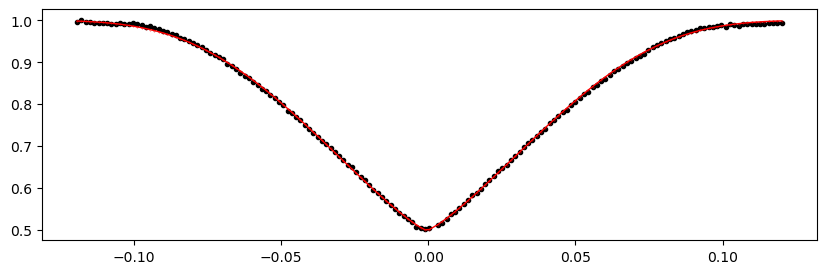

1698.179853358 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.74it/s]


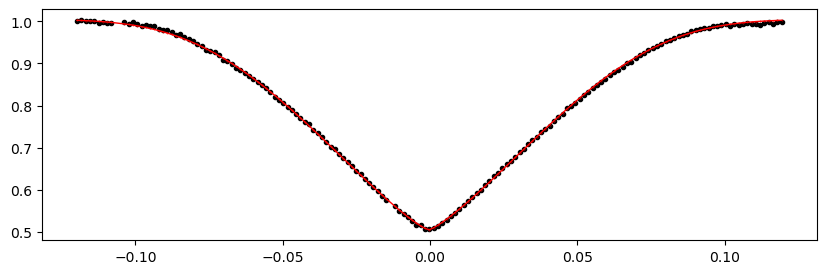

1699.1322309939999 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.38it/s]


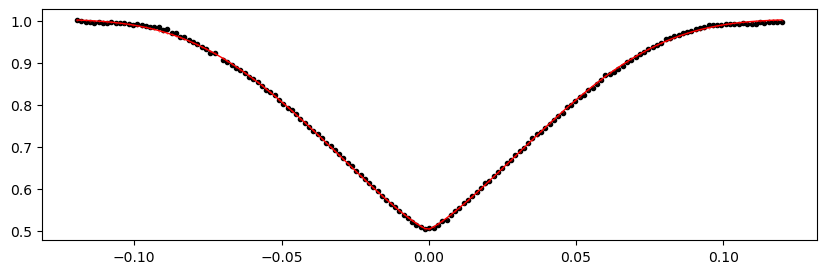

1700.08460863 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.60it/s]


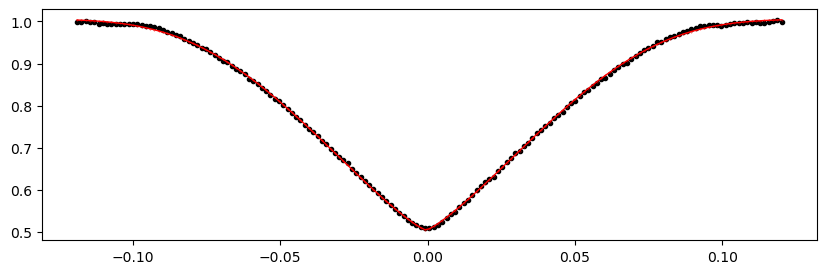

1701.036986266 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.48it/s]


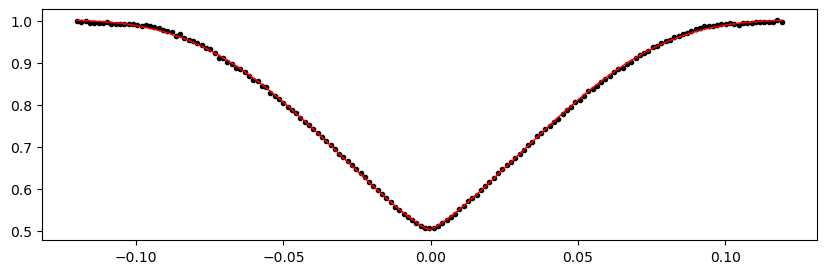

1701.989363902 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.22it/s]


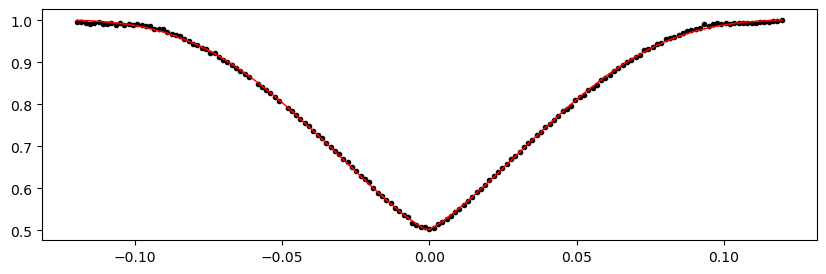

1702.9417415379999 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.62it/s]


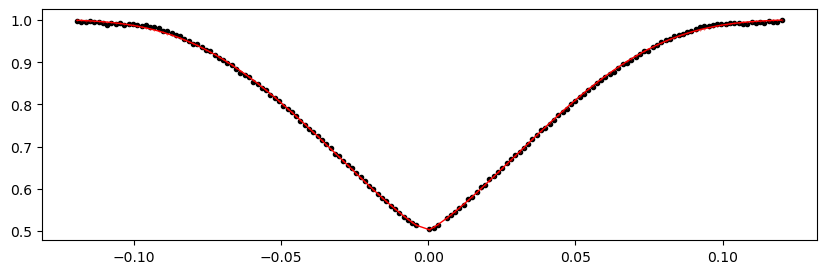

1703.894119174 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.85it/s]


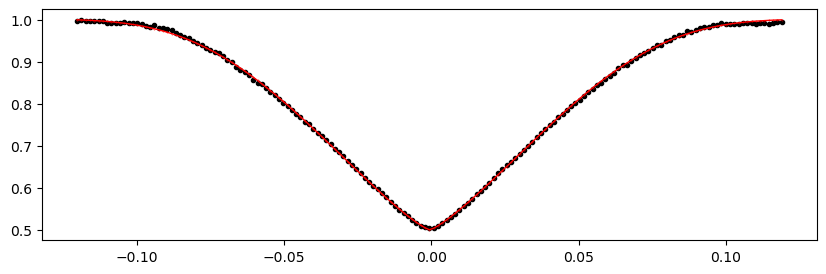

1704.84649681 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.62it/s]


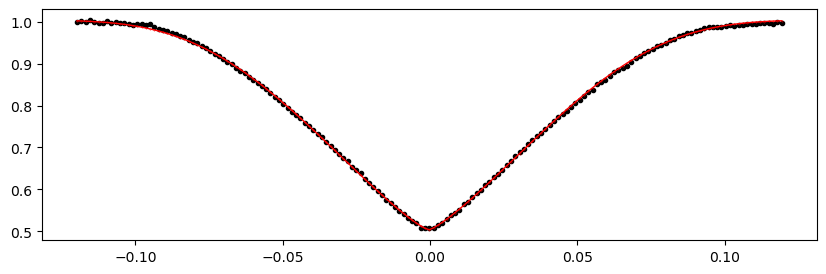

1705.798874446 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.32it/s]


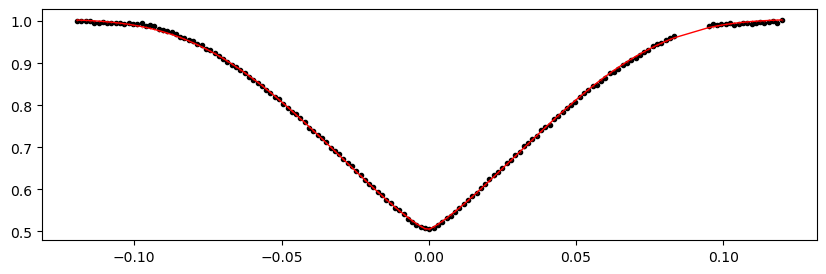

1706.751252082 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.09it/s]


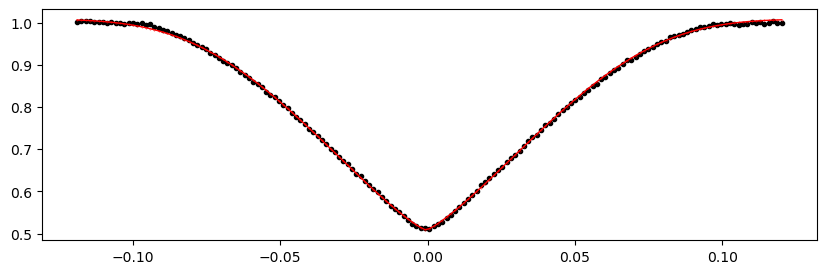

1707.703629718 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.71it/s]


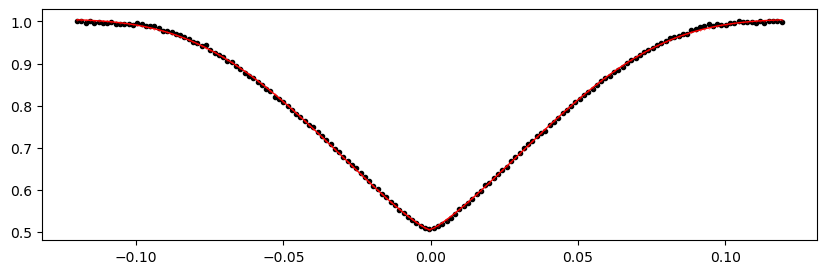

1708.656007354 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.85it/s]


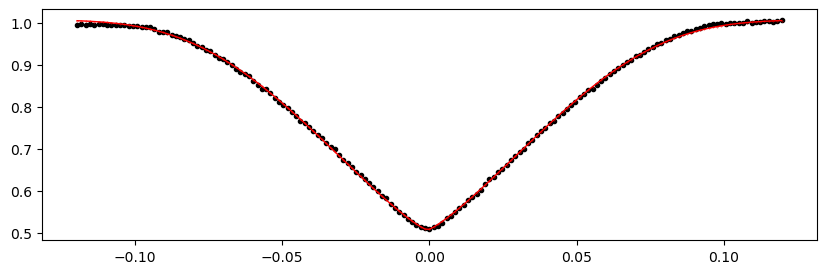

1709.6083849899999 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.43it/s]


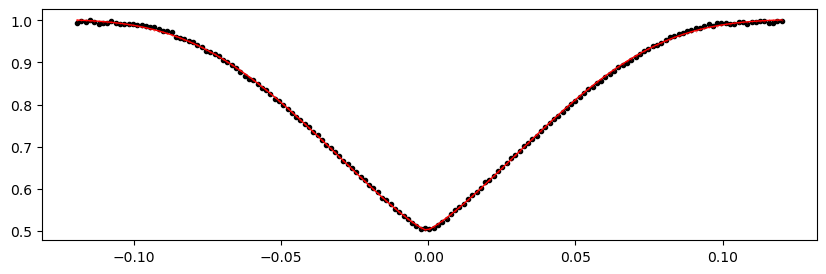

1711.513140262 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.47it/s]


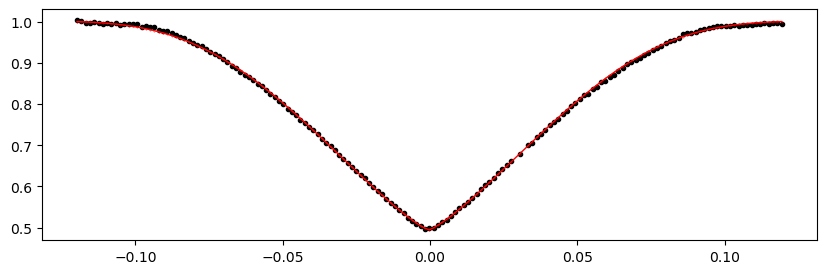

1712.465517898 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.30it/s]


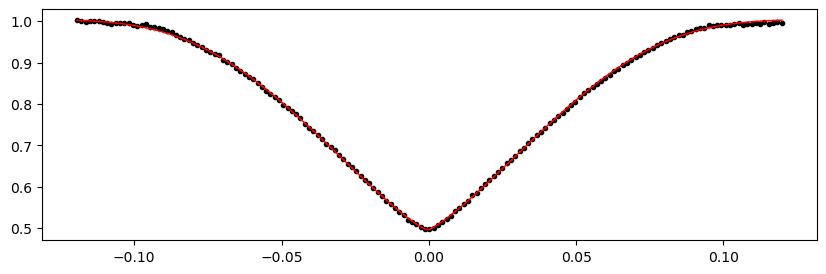

1713.417895534 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.28it/s]


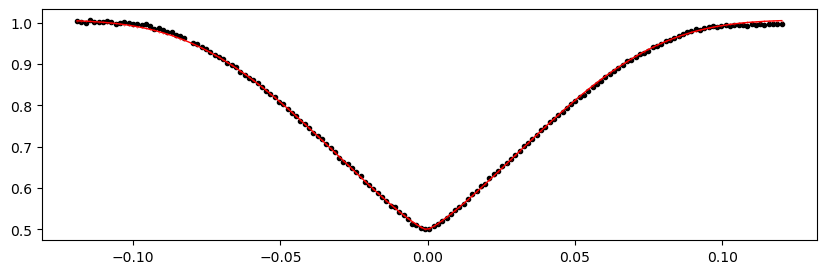

1714.37027317 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.82it/s]


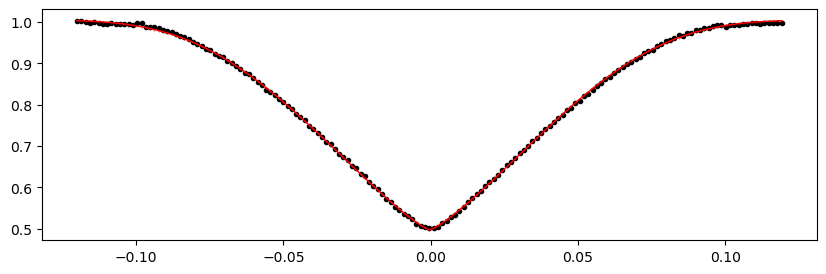

1715.322650806 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.09it/s]


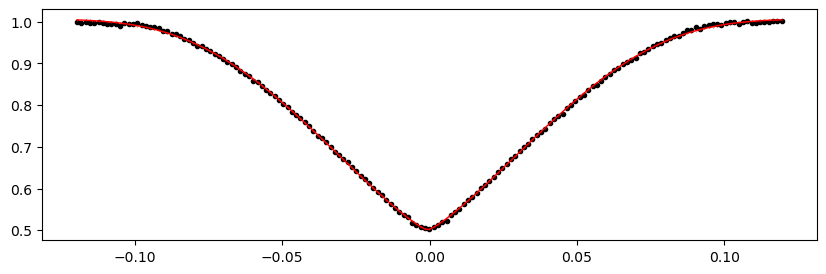

1716.275028442 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.45it/s]


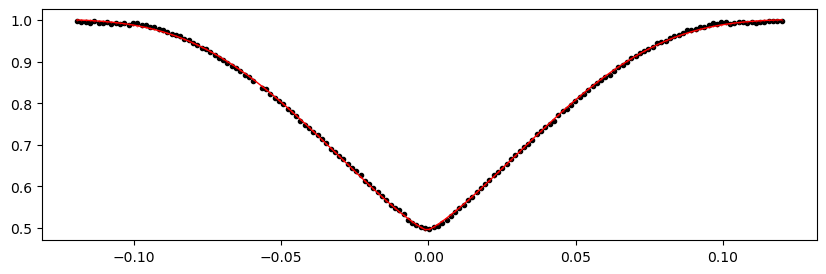

1717.227406078 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 351.14it/s]


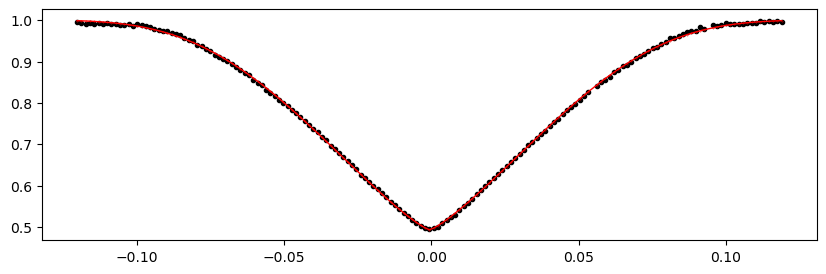

1718.179783714 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.92it/s]


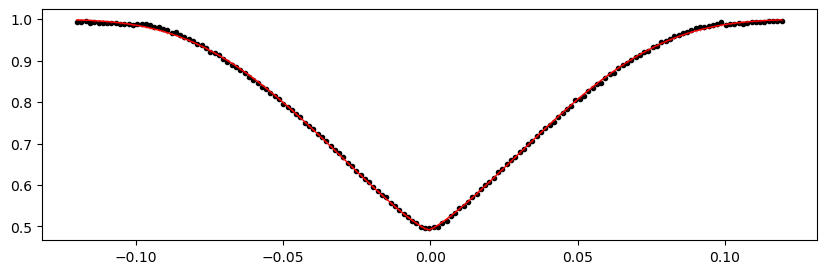

1719.13216135 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.78it/s]


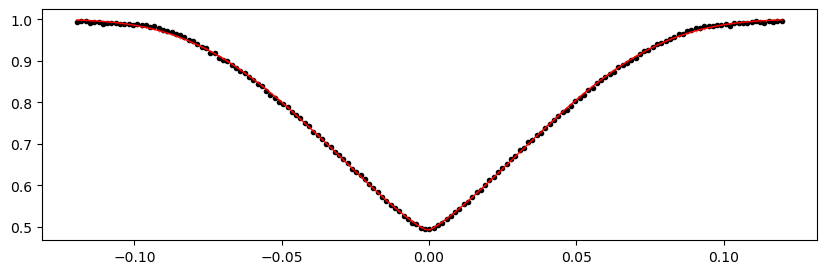

1720.0845389859999 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.07it/s]


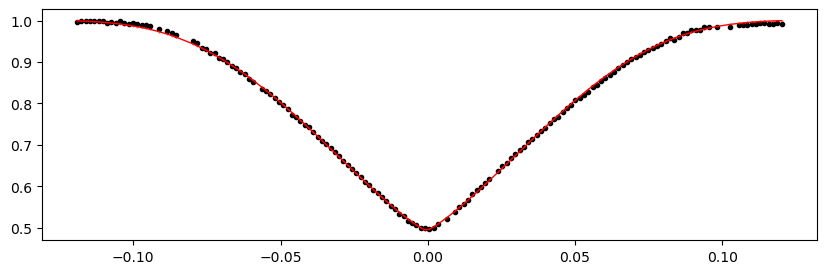

1721.036916622 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.04it/s]


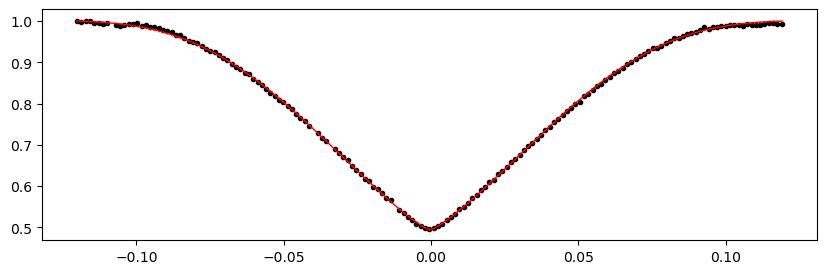

Time 1724.846427166 does not have enough data points: 13
1725.798804802 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.70it/s]


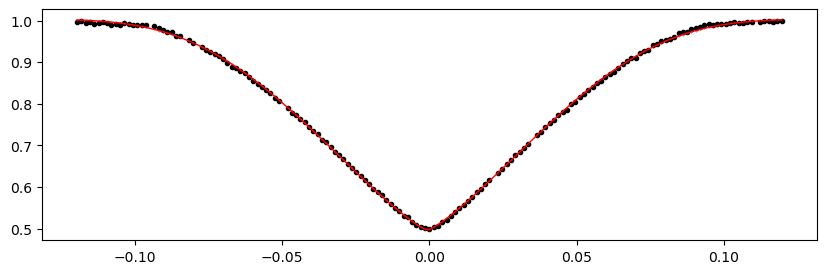

1726.751182438 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.44it/s]


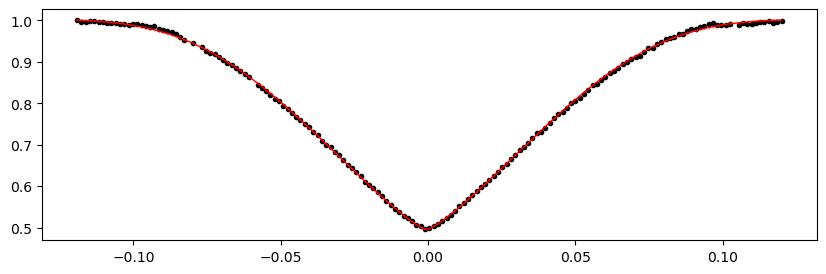

1727.703560074 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.80it/s]


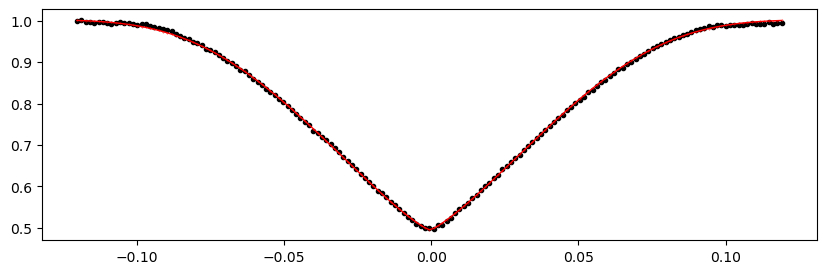

1728.65593771 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.04it/s]


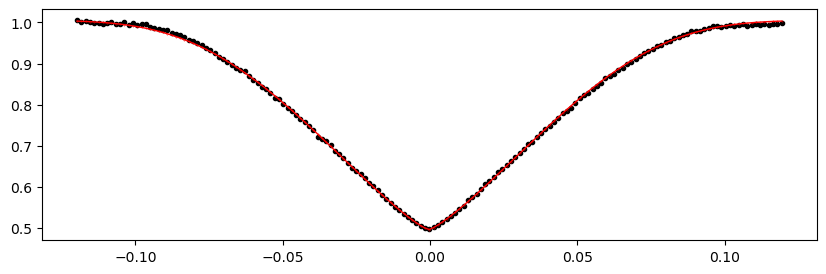

1729.608315346 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.79it/s]


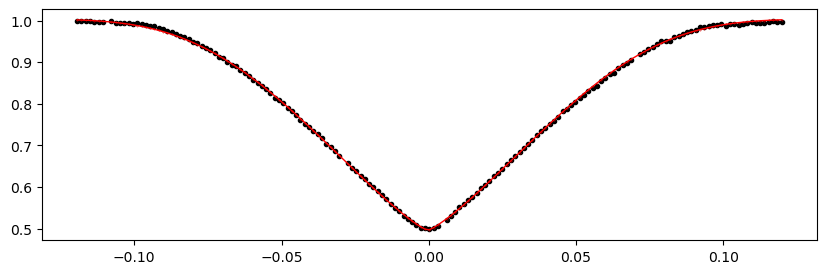

1730.560692982 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.18it/s]


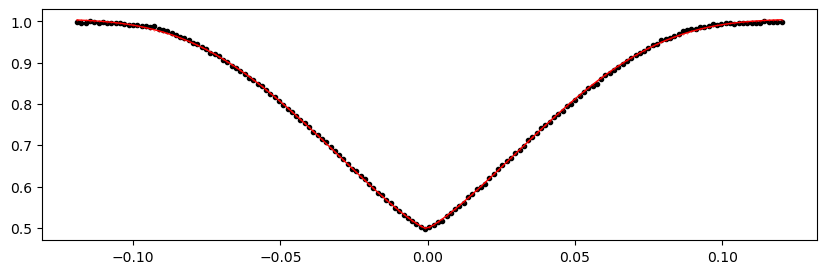

1731.513070618 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.85it/s]


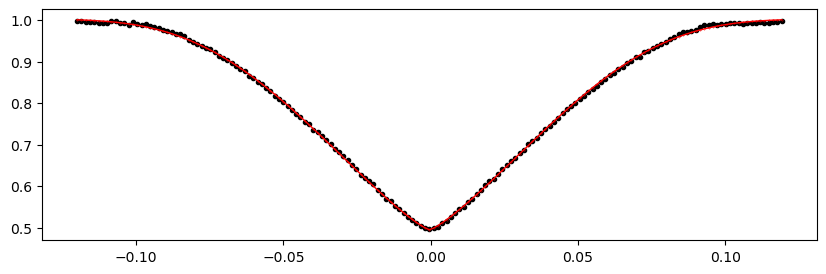

1732.465448254 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.59it/s]


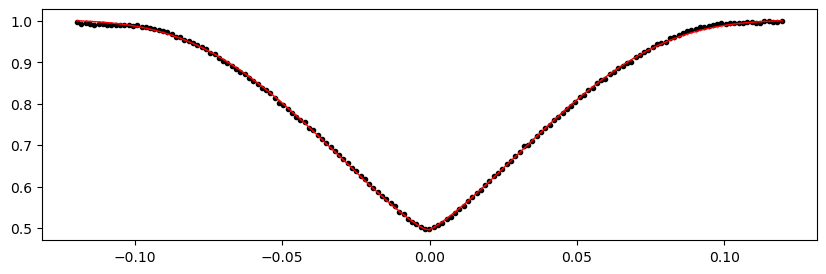

1733.41782589 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.00it/s]


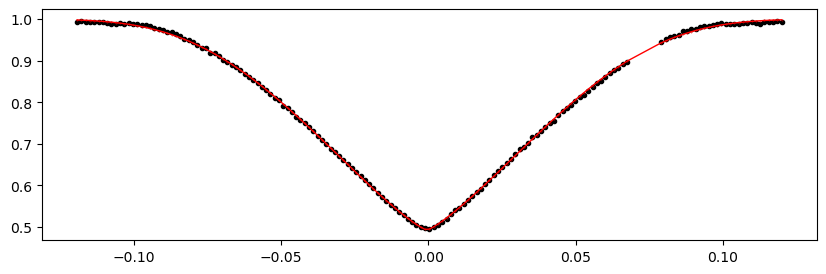

1734.370203526 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.38it/s]


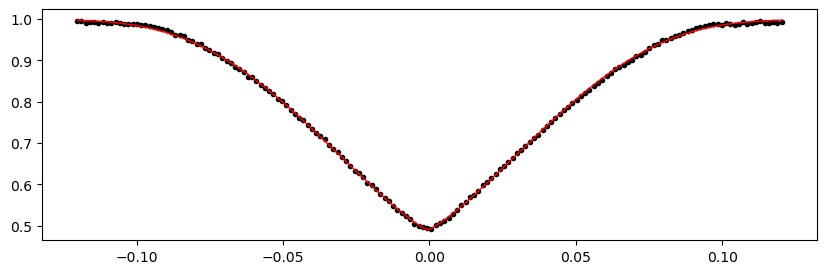

Time 2390.55839473 does not have enough data points: 13
2394.367905274 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.90it/s]


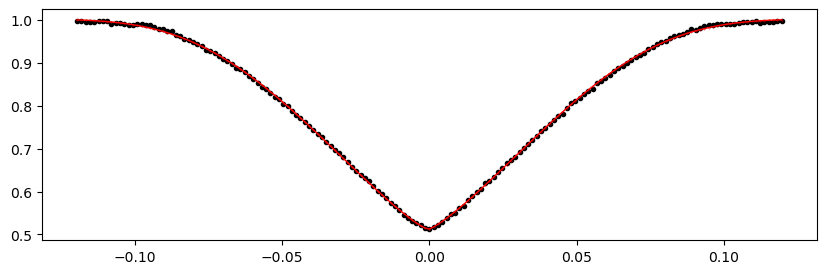

2395.32028291 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 350.79it/s]


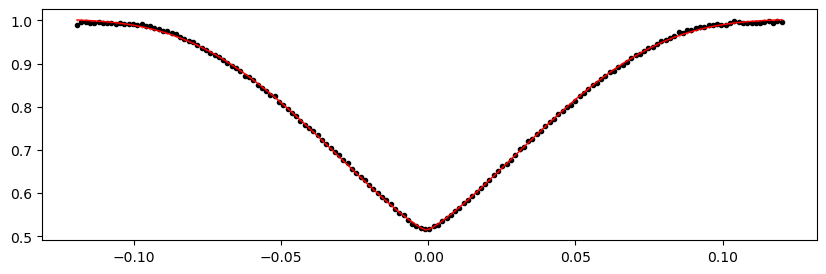

2396.272660546 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.19it/s]


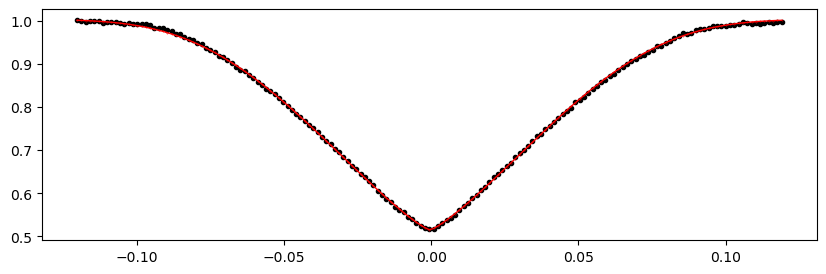

2397.225038182 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.58it/s]


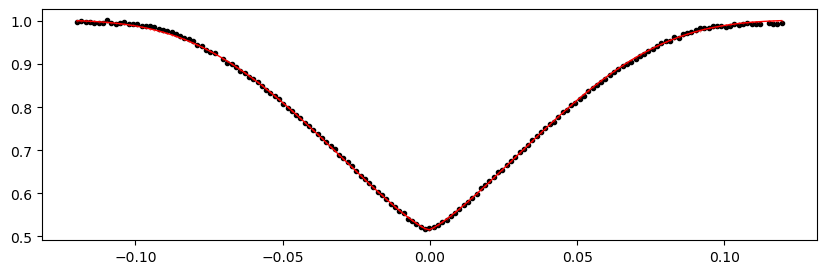

2398.177415818 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.29it/s]


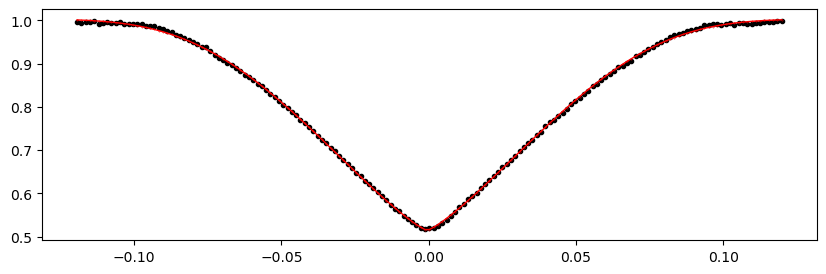

2399.129793454 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.50it/s]


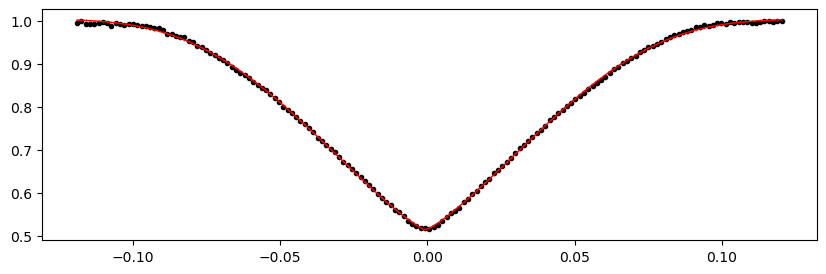

2400.08217109 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.19it/s]


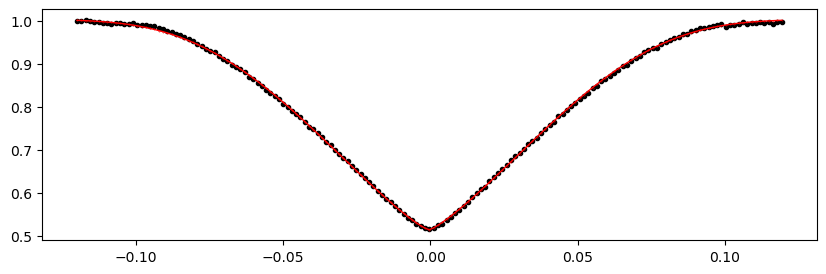

2401.034548726 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.32it/s]


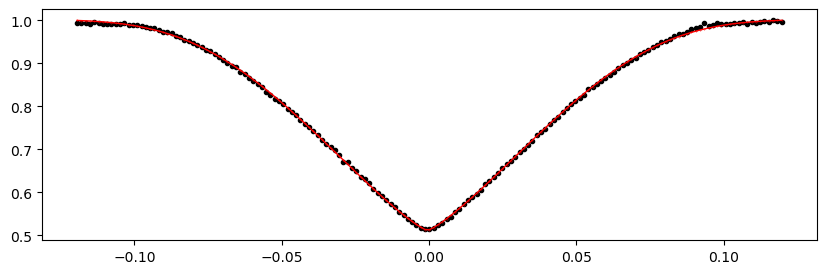

2401.986926362 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.59it/s]


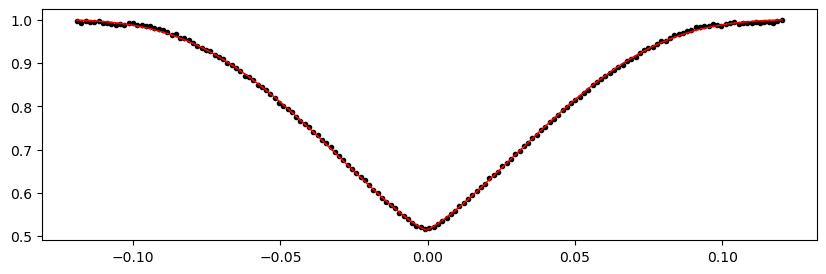

2402.939303998 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.71it/s]


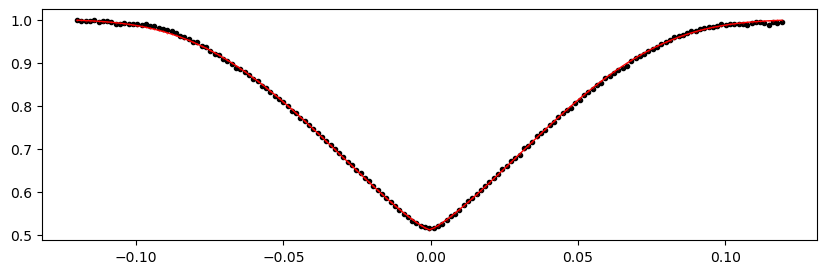

2403.8916816339997 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.41it/s]


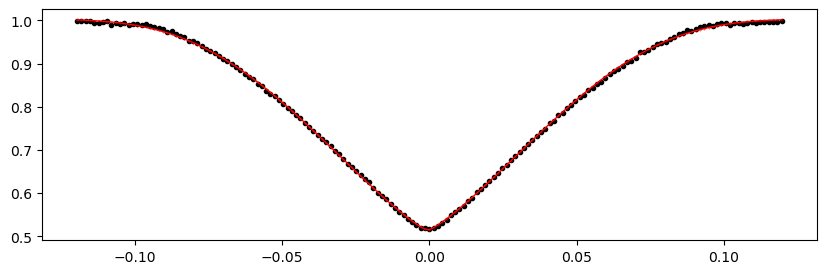

2408.653569814 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.04it/s]


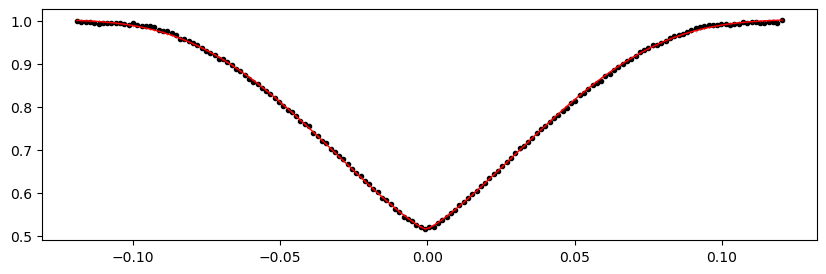

2409.60594745 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.90it/s]


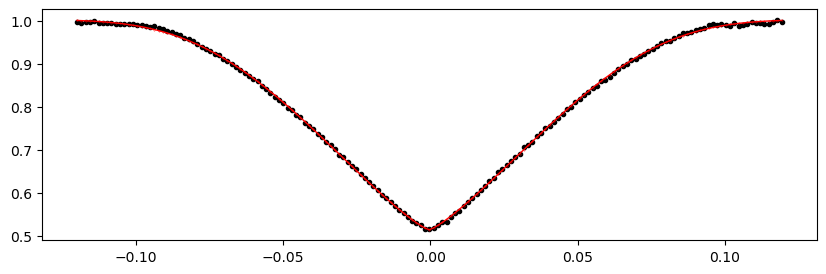

2410.558325086 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.75it/s]


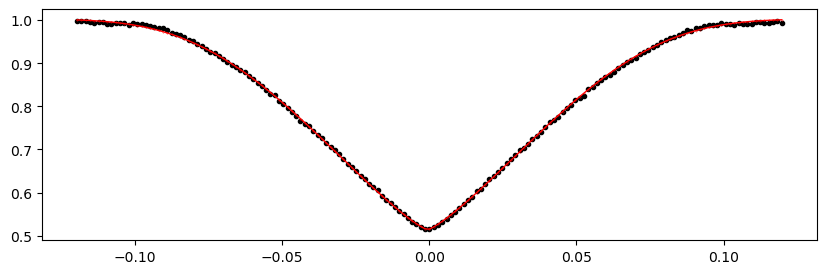

2411.510702722 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.46it/s]


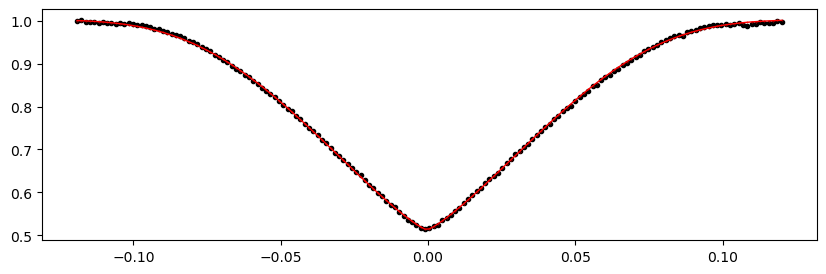

2412.463080358 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.96it/s]


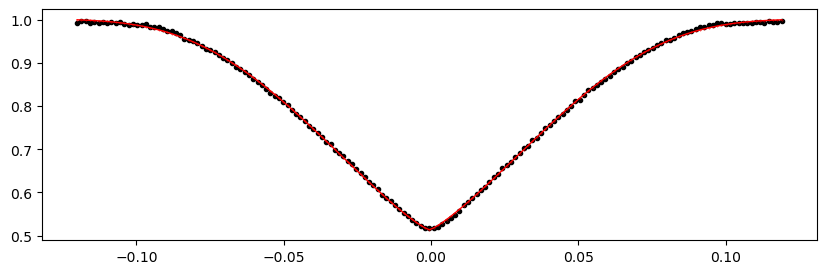

2413.415457994 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.62it/s]


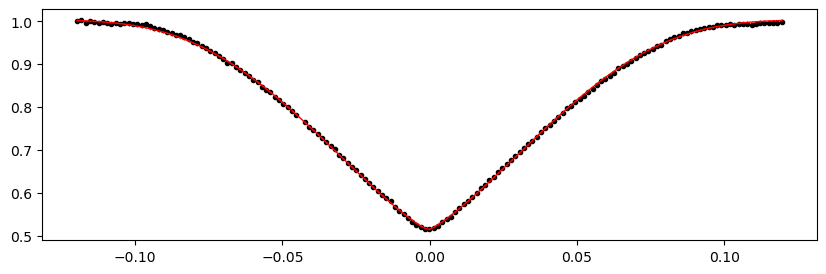

2414.3678356299997 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.73it/s]


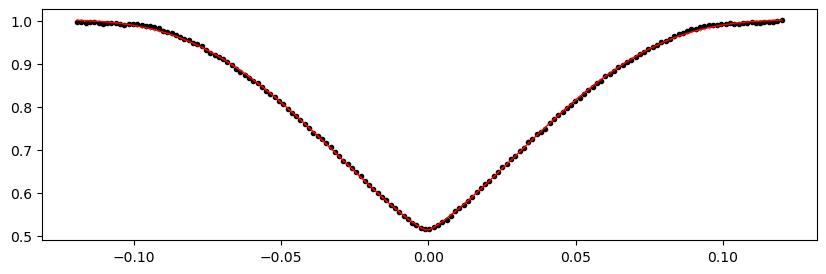

2415.320213266 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.24it/s]


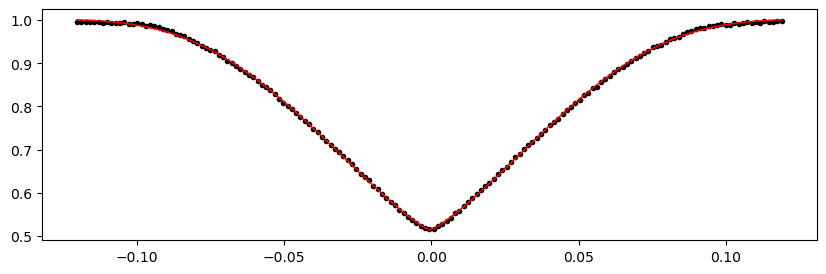

2416.272590902 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 263.73it/s]


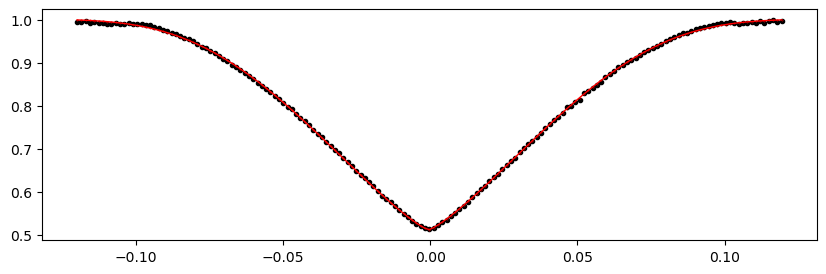

2417.224968538 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.22it/s]


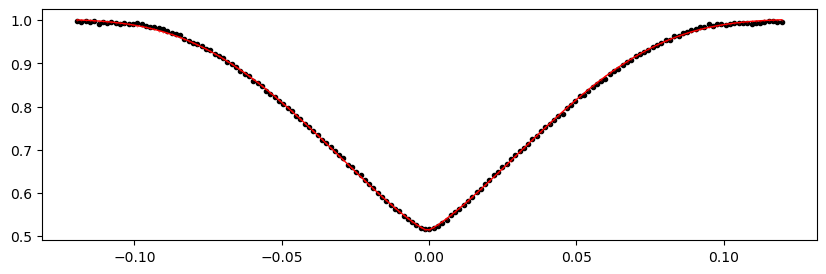

2418.177346174 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.51it/s]


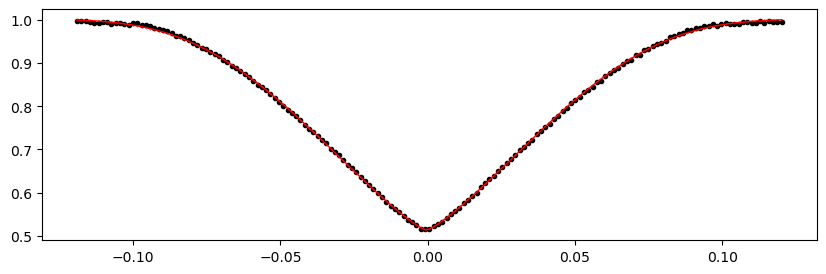

2420.082101446 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.73it/s]


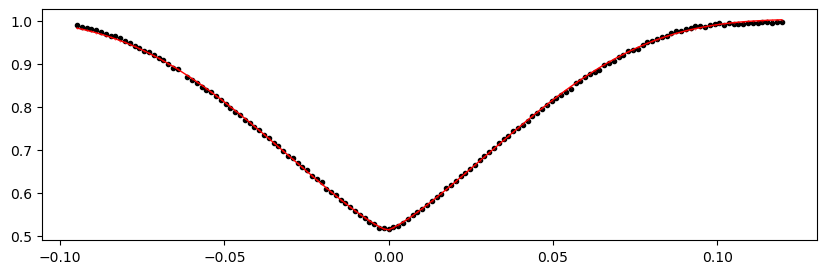

2421.034479082 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.30it/s]


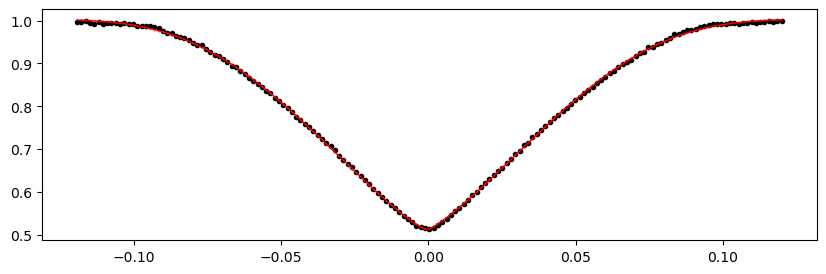

2421.986856718 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.09it/s]


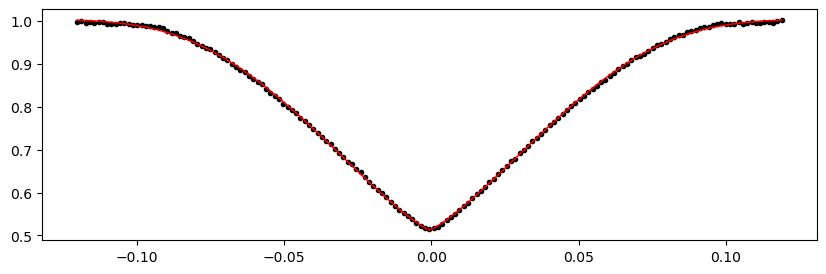

2422.939234354 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.24it/s]


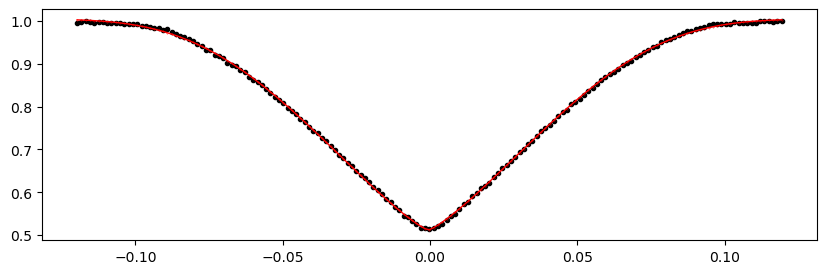

2423.89161199 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.28it/s]


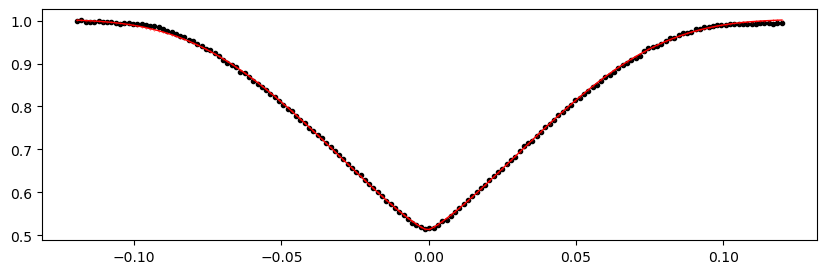

2424.843989626 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.28it/s]


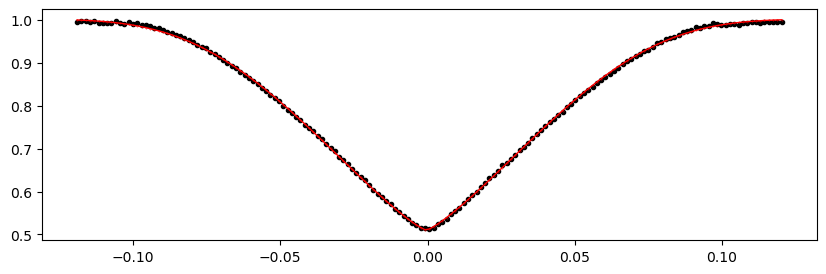

2425.796367262 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.62it/s]


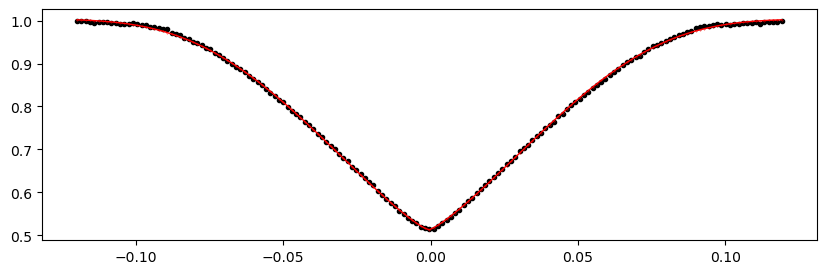

2426.748744898 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.26it/s]


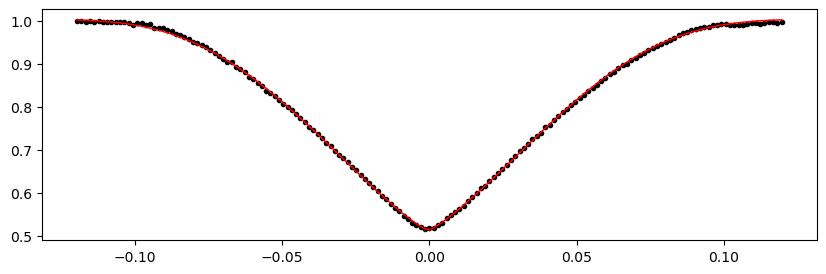

2427.701122534 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.67it/s]


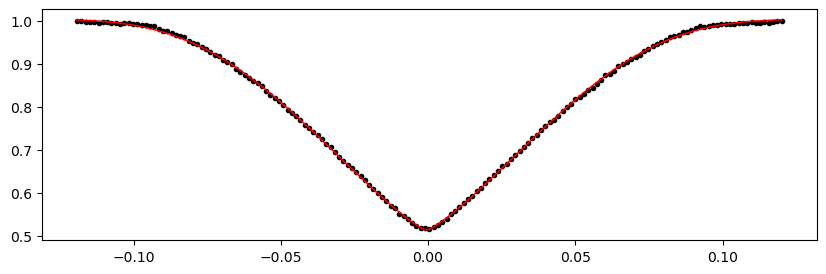

2428.65350017 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.56it/s]


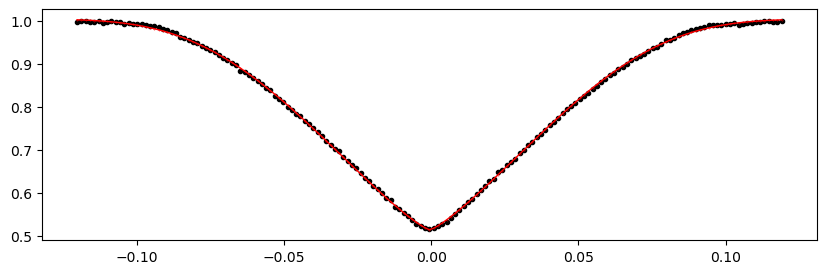

2429.605877806 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.56it/s]


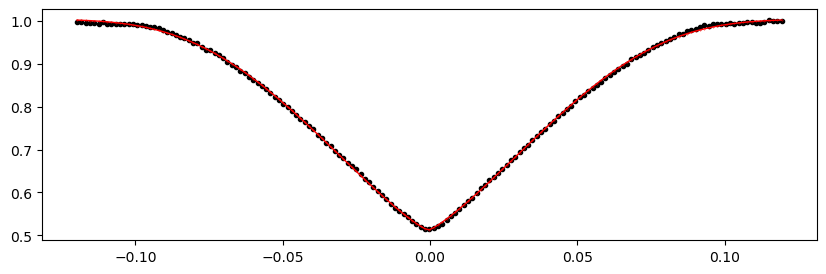

2430.558255442 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.80it/s]


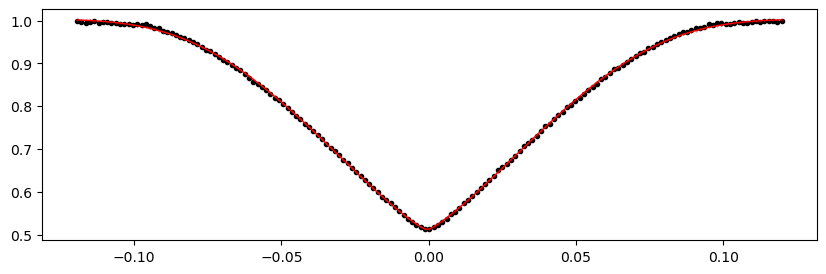

2431.510633078 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.41it/s]


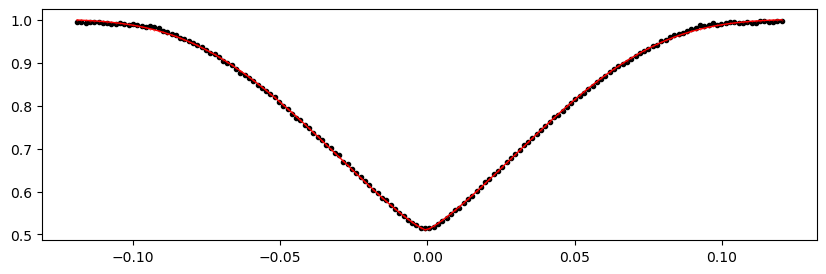

2432.463010714 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.37it/s]


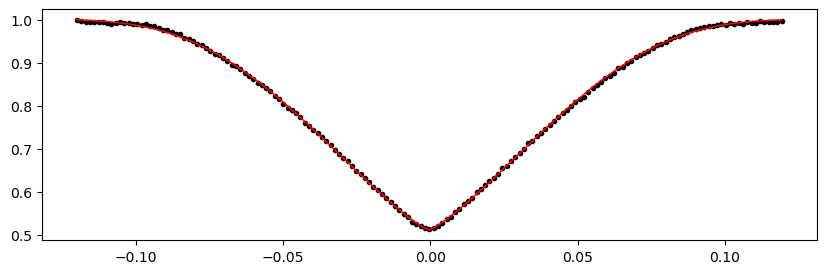

2434.367765986 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.54it/s]


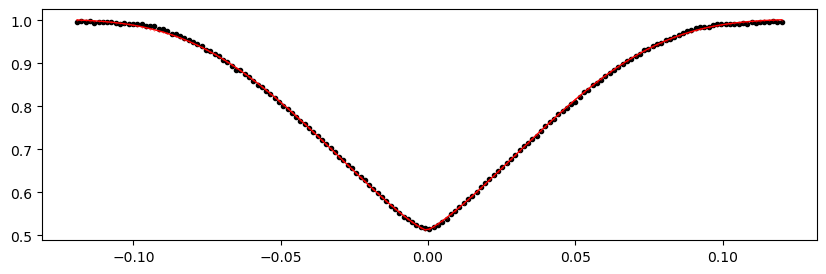

2435.320143622 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.24it/s]


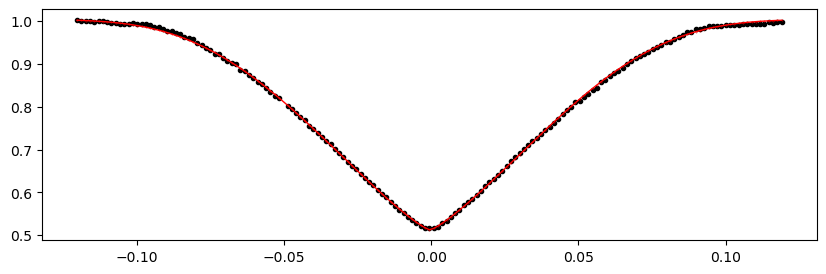

2436.272521258 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.65it/s]


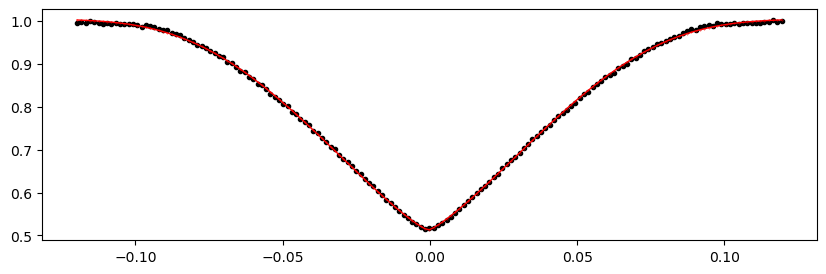

2437.224898894 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.04it/s]


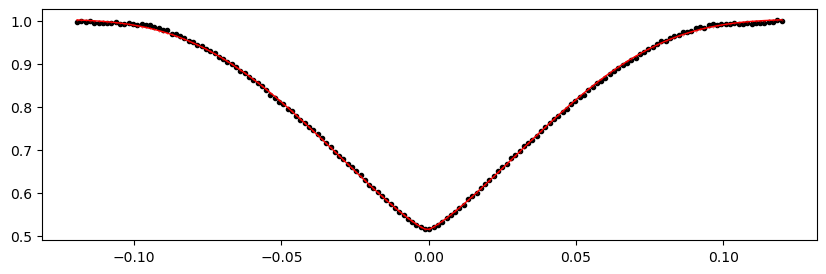

2438.17727653 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.46it/s]


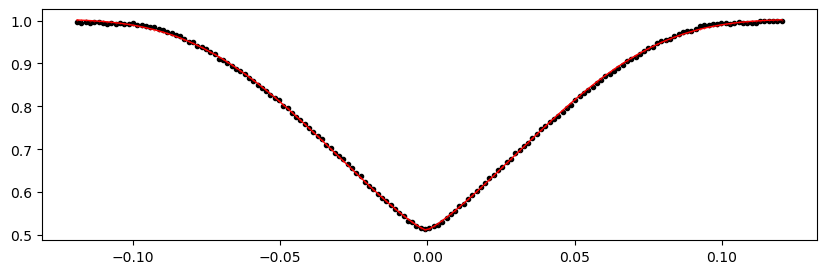

2439.129654166 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.80it/s]


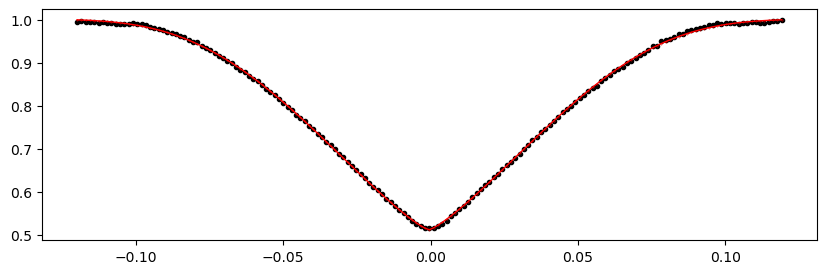

2440.082031802 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.67it/s]


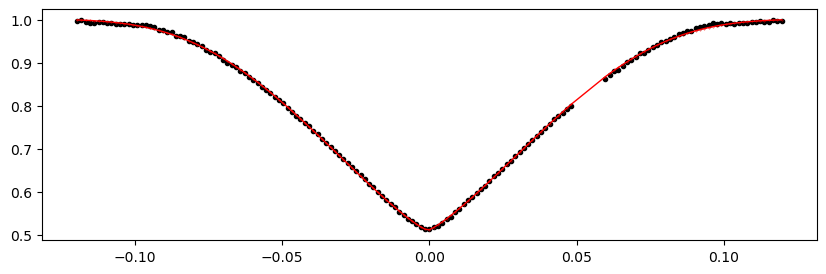

2441.034409438 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.81it/s]


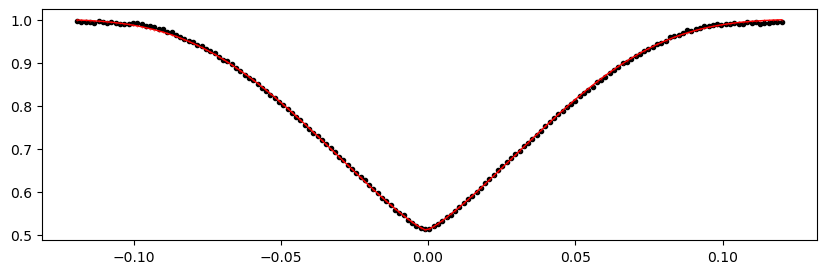

2441.986787074 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.71it/s]


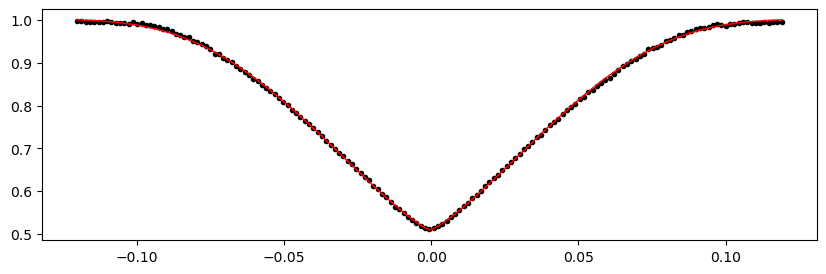

2442.93916471 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.72it/s]


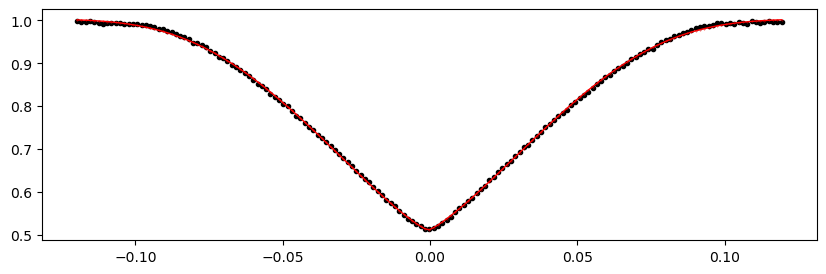

2443.8915423460003 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 344.89it/s]


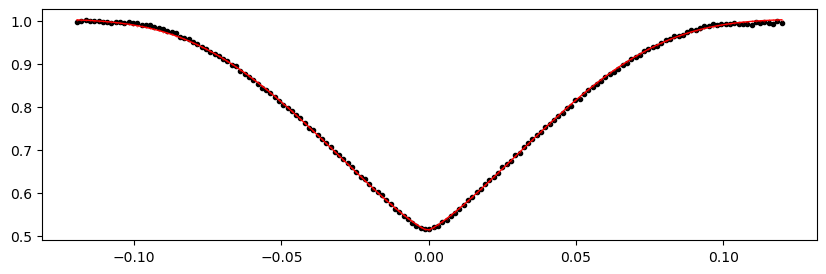

2444.843919982 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.50it/s]


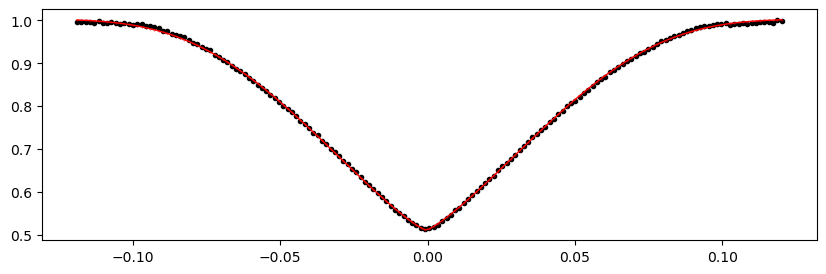

2445.796297618 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 316.54it/s]


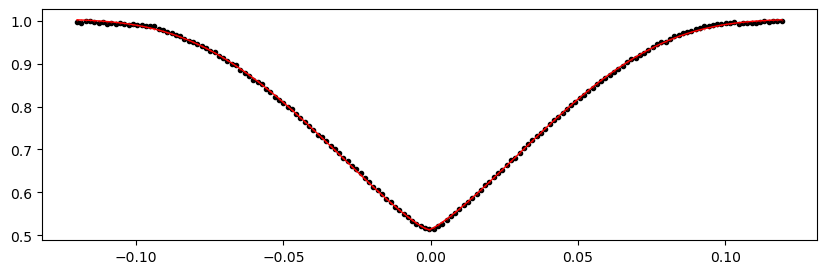

2770.557071494 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.95it/s]


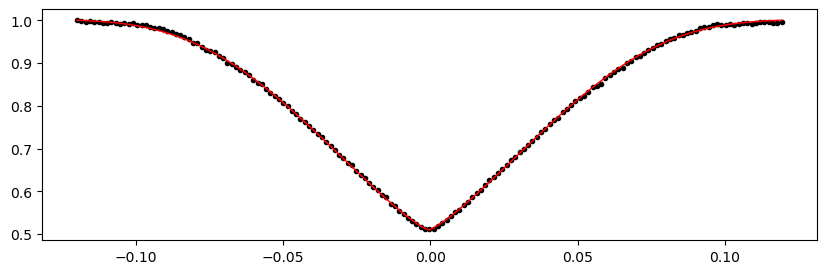

2771.5094491299997 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.08it/s]


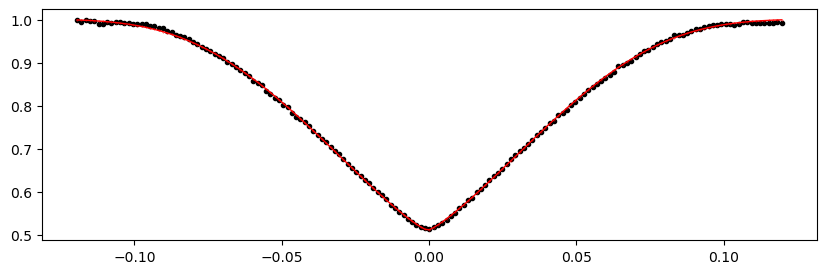

2772.461826766 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.71it/s]


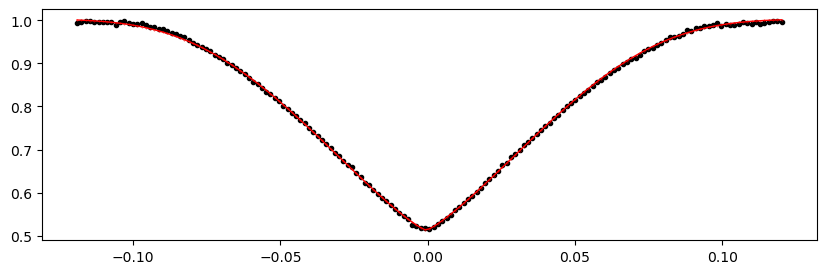

2773.414204402 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.77it/s]


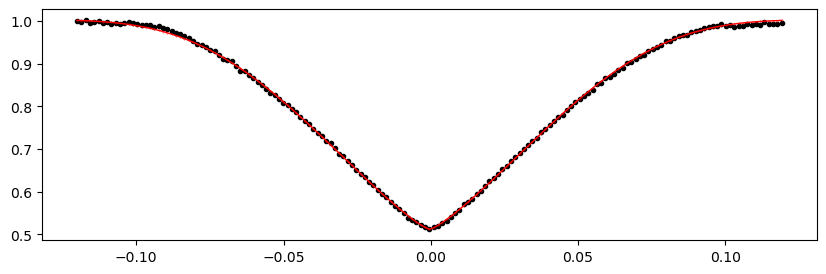

2774.366582038 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.50it/s]


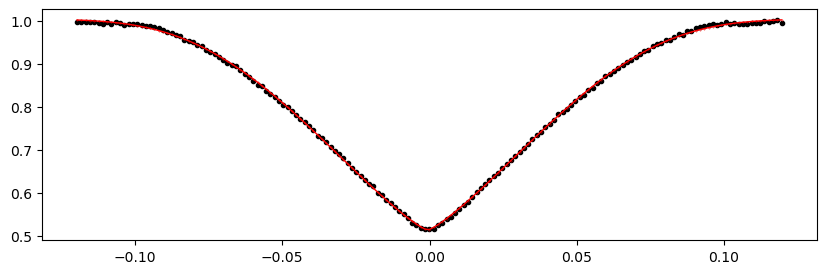

2775.3189596740003 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 349.05it/s]


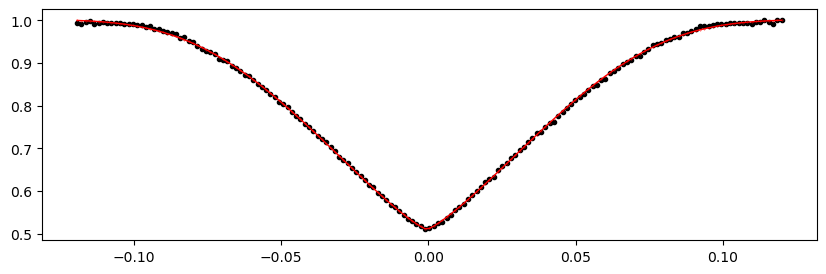

2776.27133731 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.22it/s]


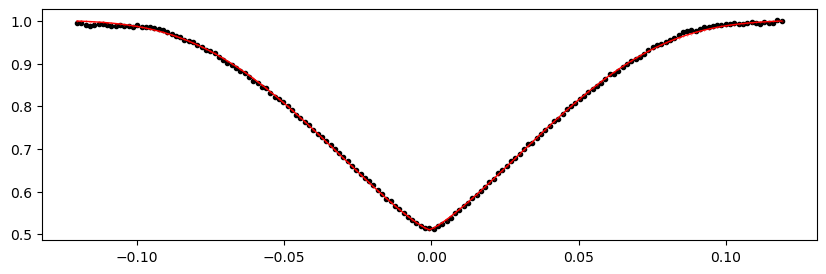

2777.2237149459997 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.66it/s]


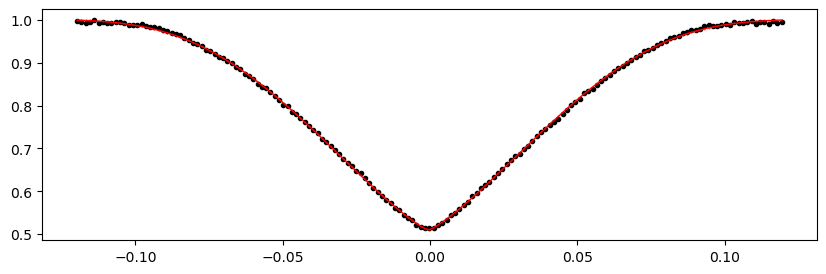

2778.176092582 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.68it/s]


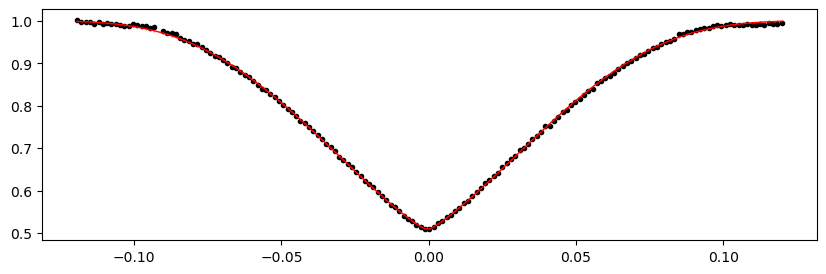

2779.128470218 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.37it/s]


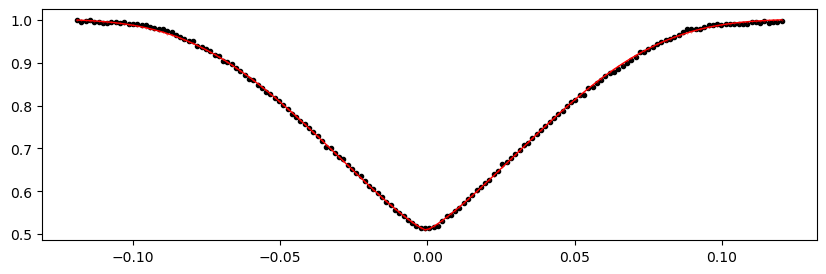

2780.0808478540002 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.90it/s]


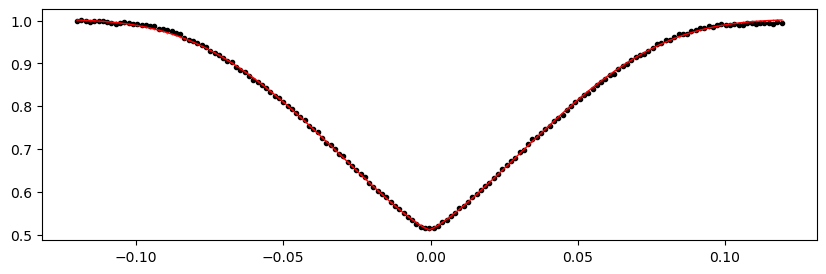

2781.03322549 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.18it/s]


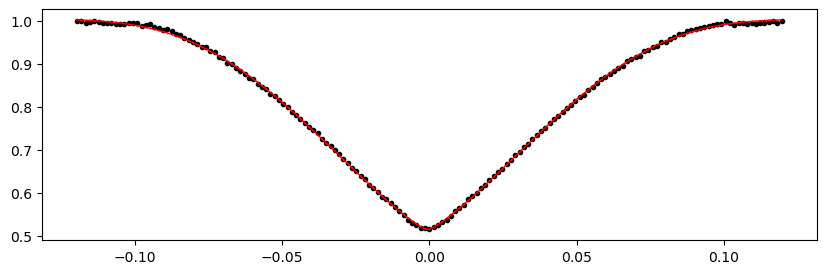

2781.985603126 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.58it/s]


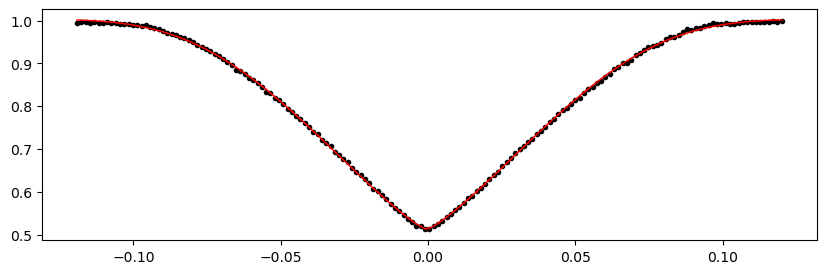

2783.890358398 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.02it/s]


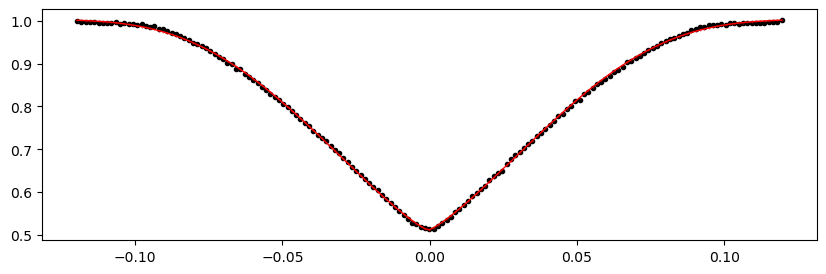

2784.842736034 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.00it/s]


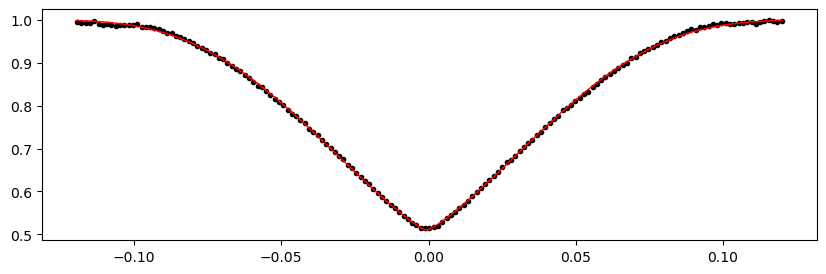

2785.7951136700003 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.25it/s]


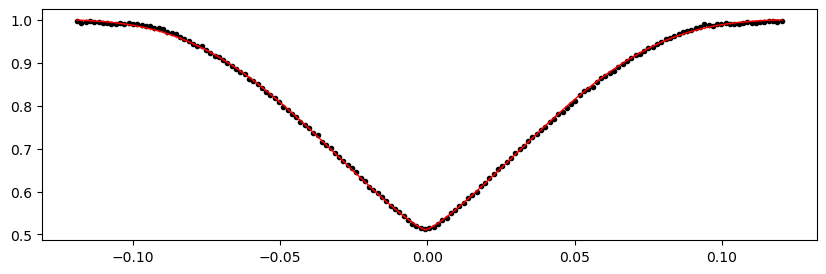

2786.747491306 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.72it/s]


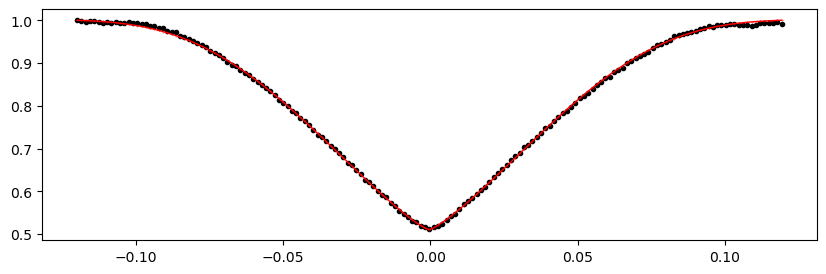

2787.6998689419997 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.85it/s]


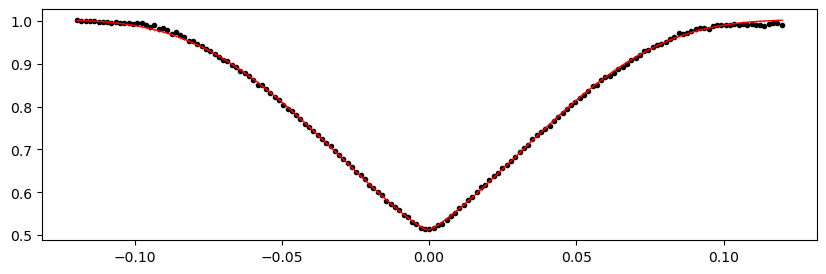

2788.652246578 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.31it/s]


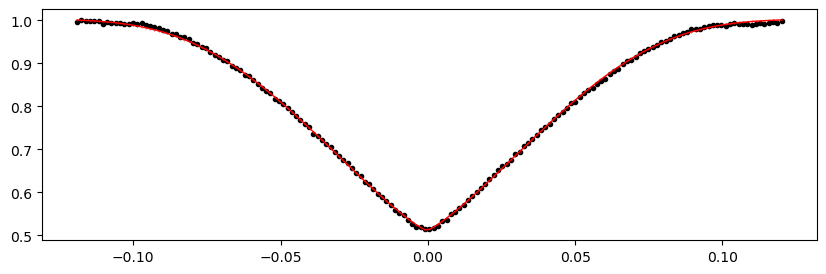

2789.604624214 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.47it/s]


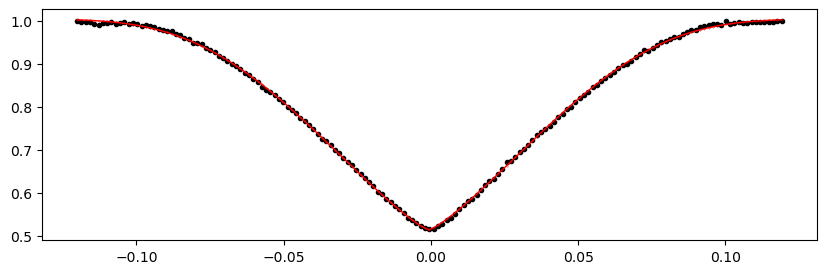

2790.5570018500002 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.47it/s]


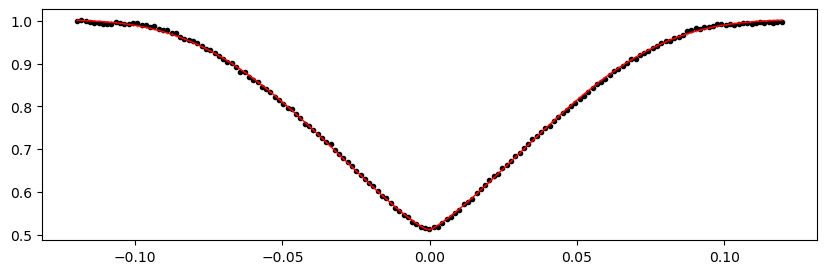

2791.509379486 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.01it/s]


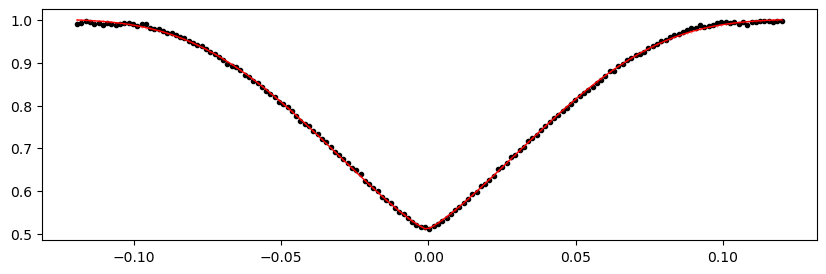

2792.461757122 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.47it/s]


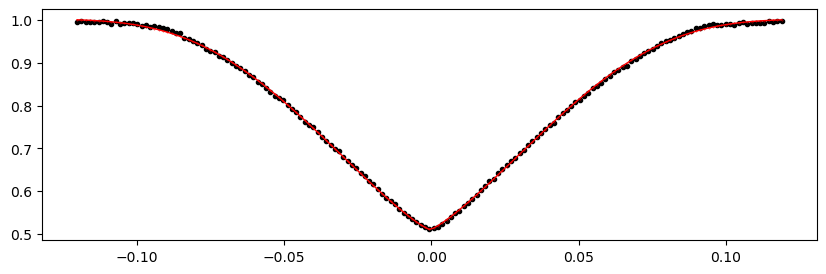

2793.414134758 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.52it/s]


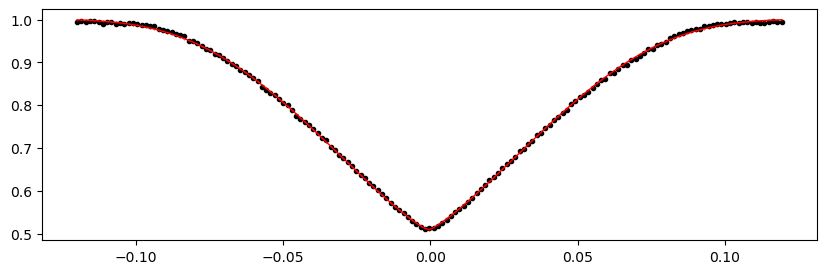

2794.366512394 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.32it/s]


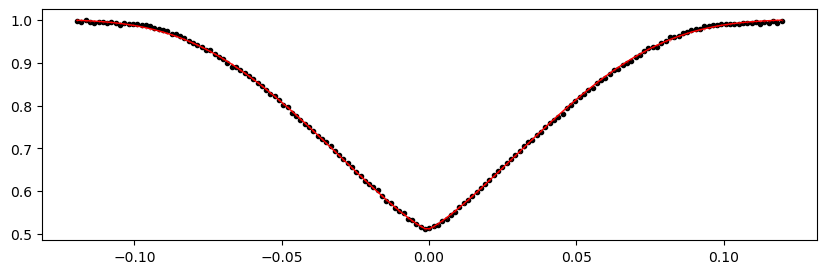

2795.31889003 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.47it/s]


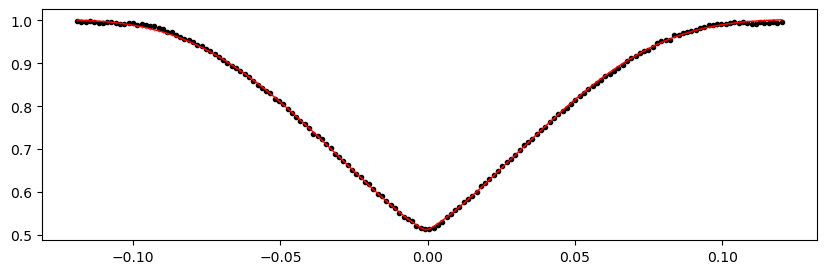

2797.223645302 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.68it/s]


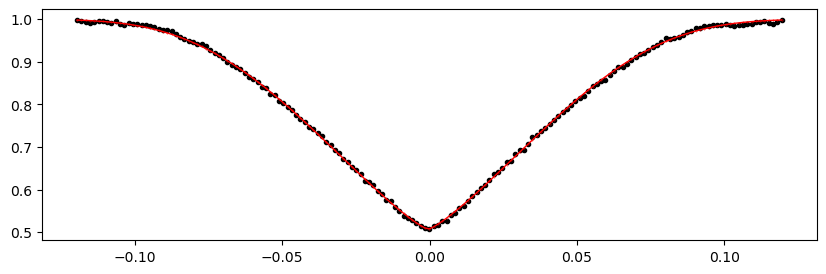

2798.1760229379997 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.88it/s]


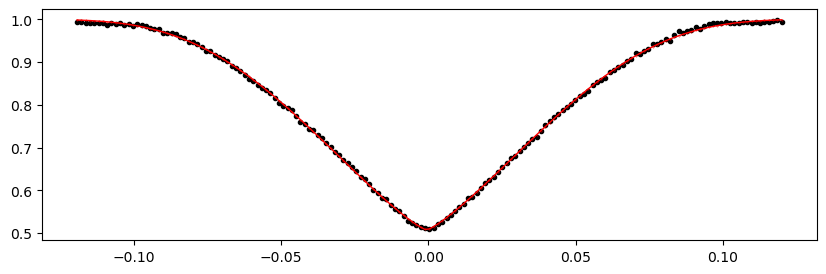

2799.128400574 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.00it/s]


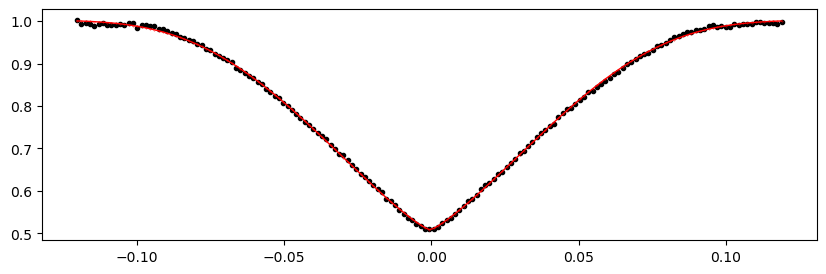

2800.08077821 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.53it/s]


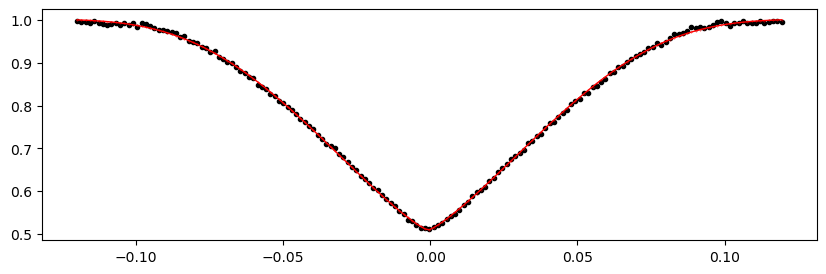

2801.033155846 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.59it/s]


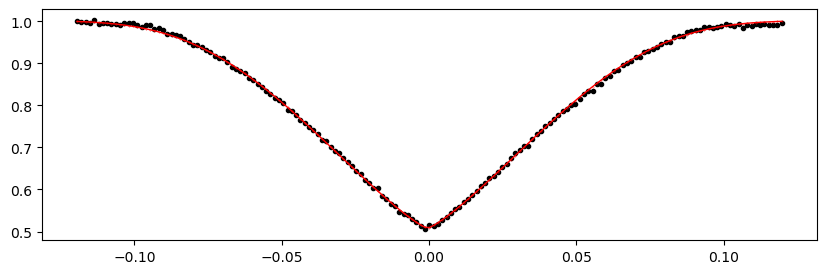

2801.985533482 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 310.92it/s]


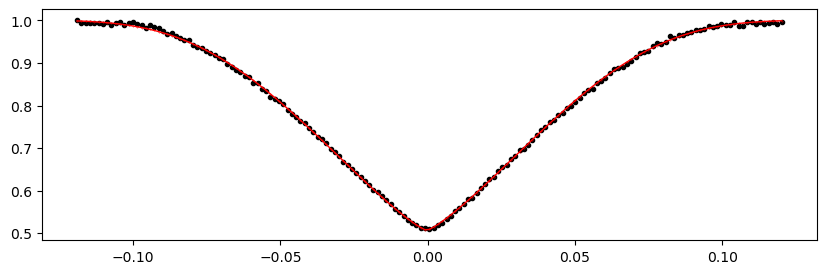

2802.937911118 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 311.09it/s]


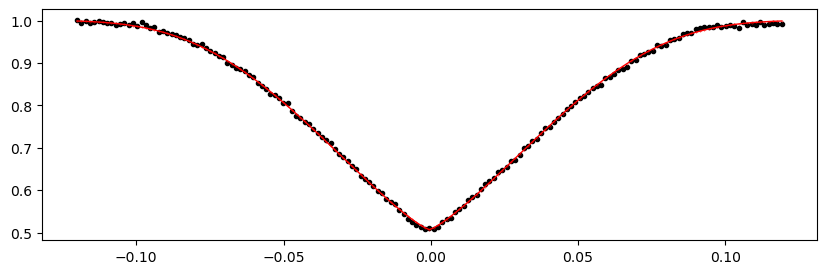

2803.890288754 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.88it/s]


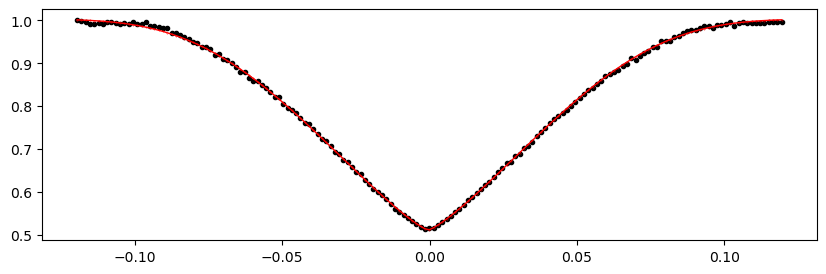

2804.84266639 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.96it/s]


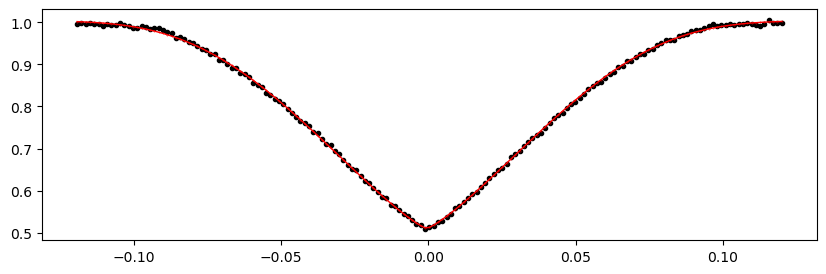

2805.795044026 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.77it/s]


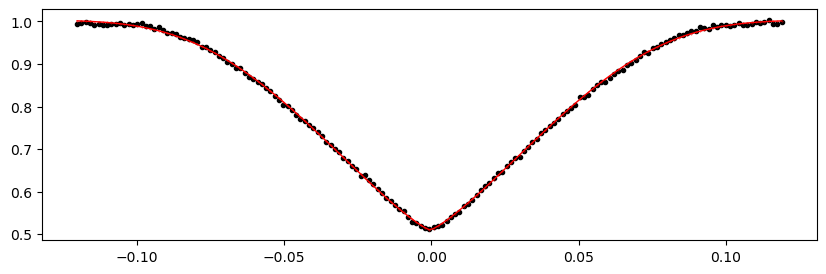

2806.7474216620003 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.12it/s]


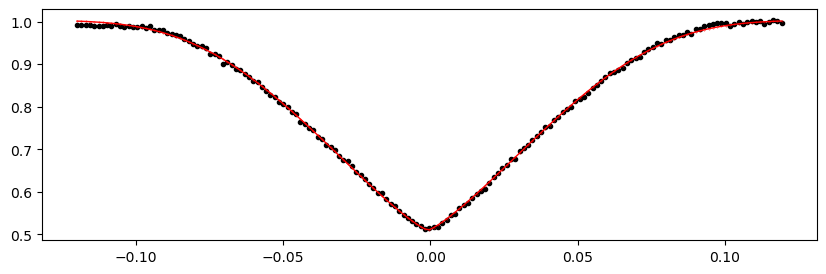

2807.699799298 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.39it/s]


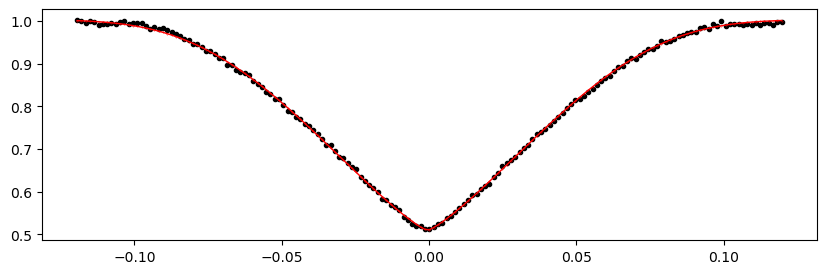

2808.6521769339997 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.30it/s]


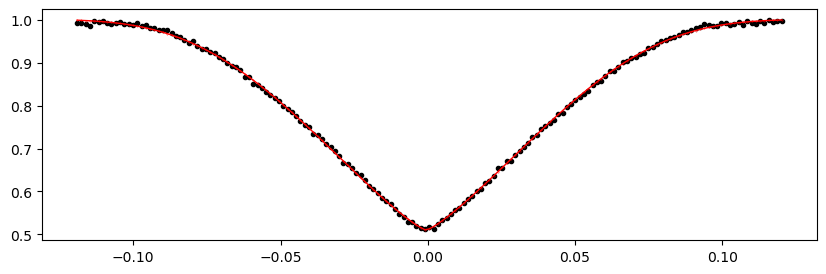

2809.60455457 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.18it/s]


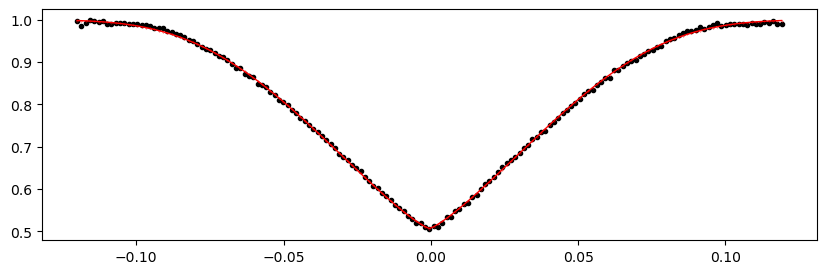

2811.509309842 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 344.83it/s]


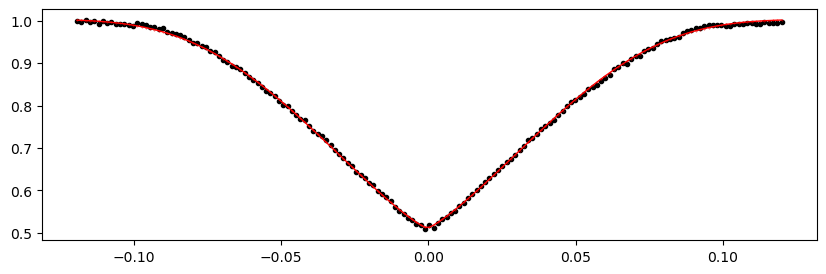

2812.461687478 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.66it/s]


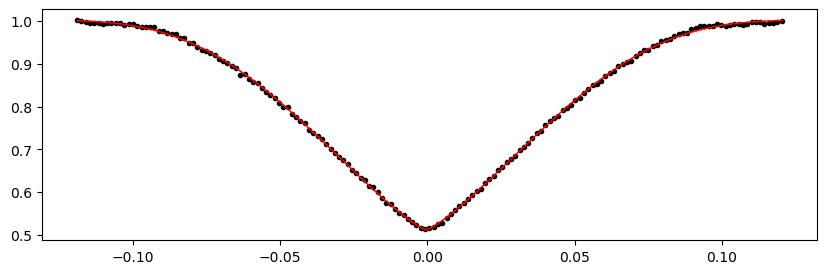

2813.414065114 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.28it/s]


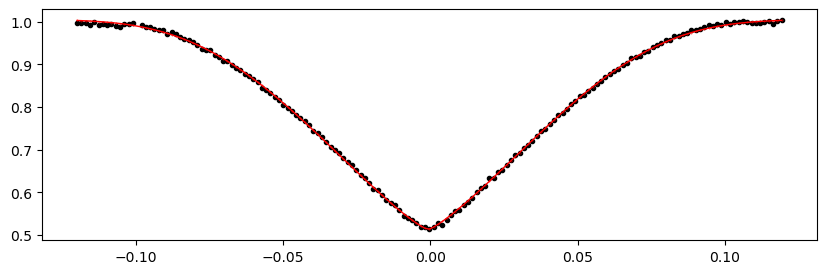

2814.36644275 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.48it/s]


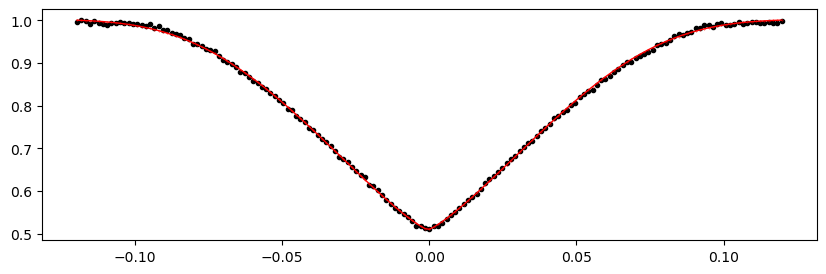

2815.318820386 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.40it/s]


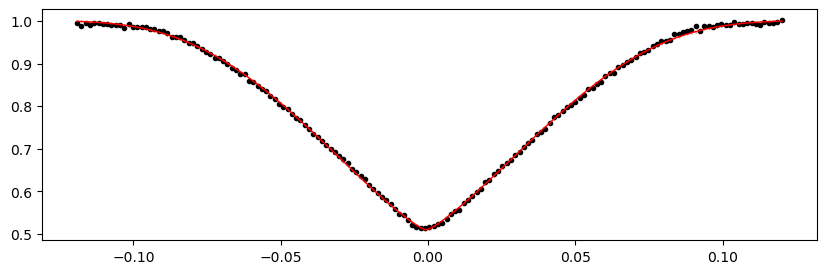

2816.271198022 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.01it/s]


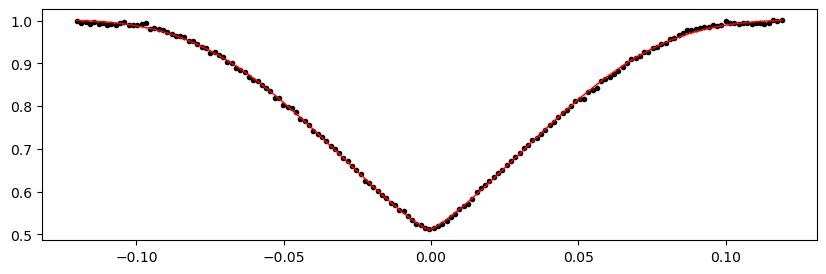

2817.2235756580003 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.78it/s]


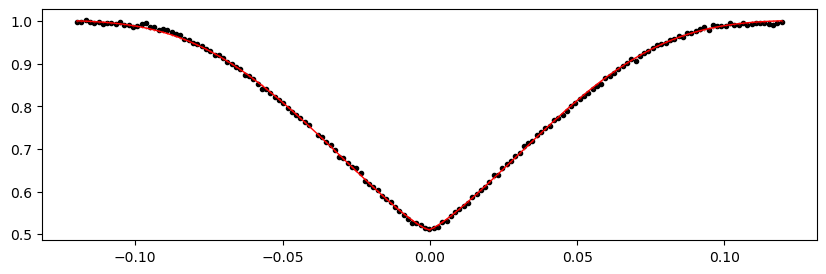

2818.175953294 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.25it/s]


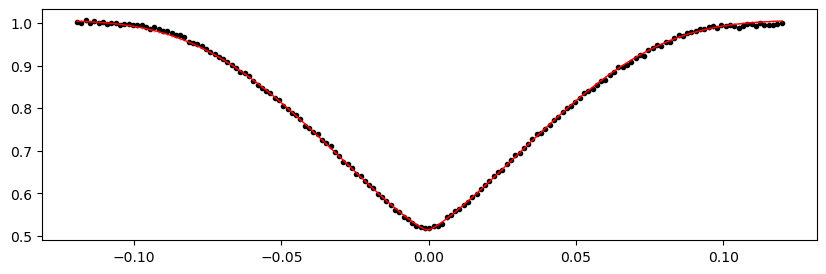

2819.1283309299997 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.41it/s]


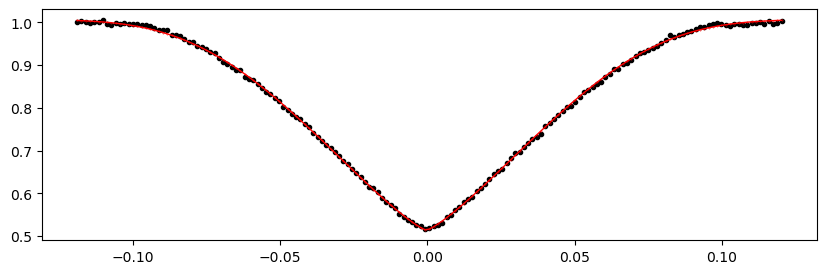

2820.080708566 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.98it/s]


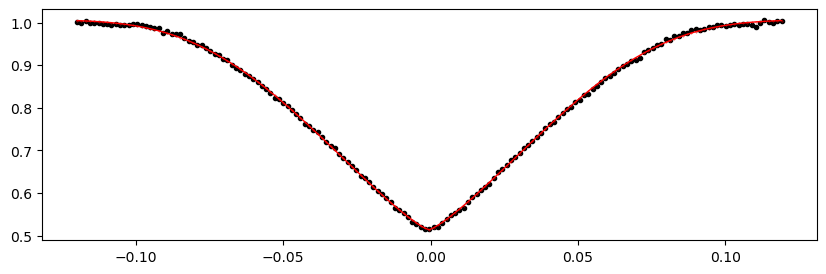

2821.033086202 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.83it/s]


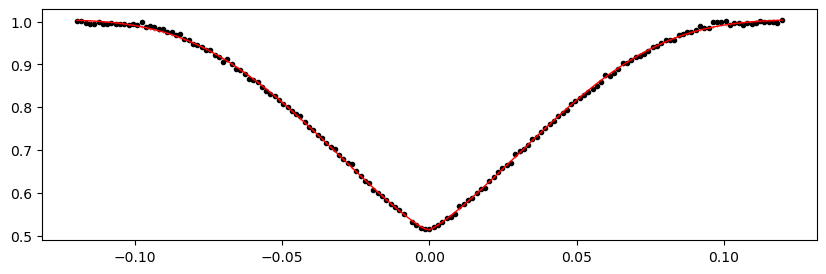

2821.985463838 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.70it/s]


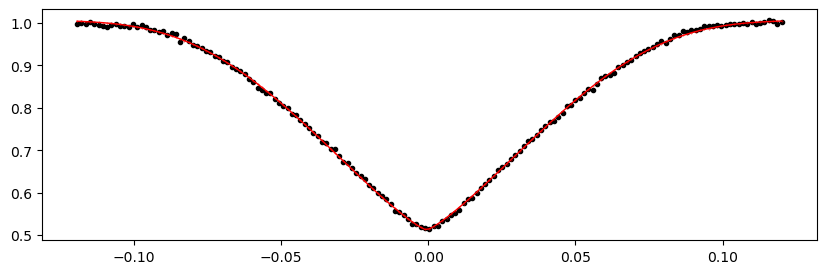

2822.937841474 1.002908556131359 -0.4944476052966029 -0.2754963204417742


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.83it/s]


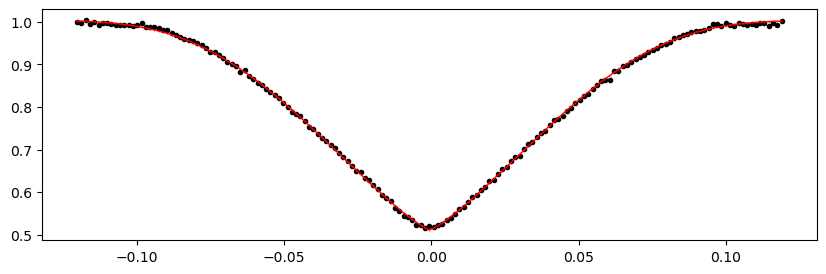

In [49]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=20, 
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

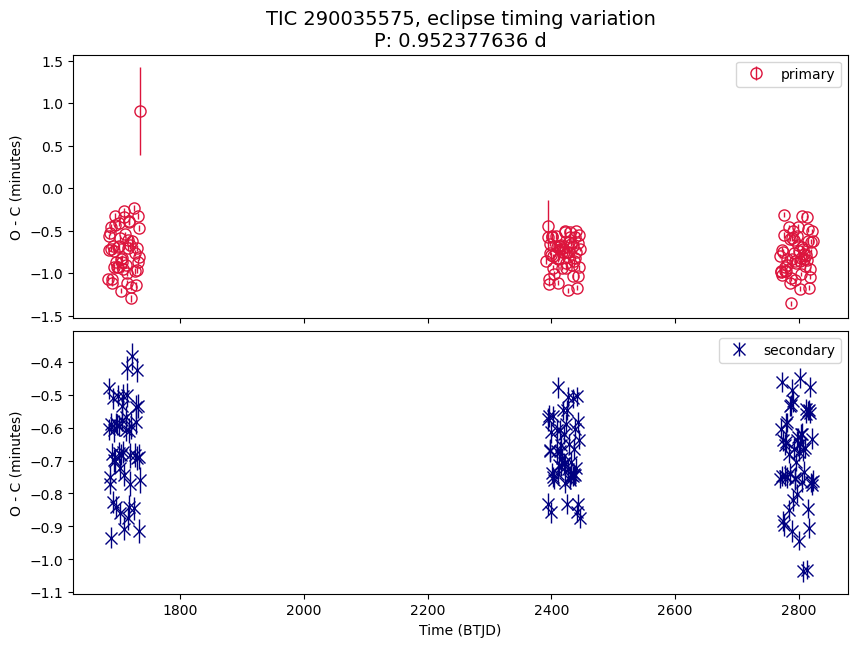

In [17]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60    
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful
    
    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

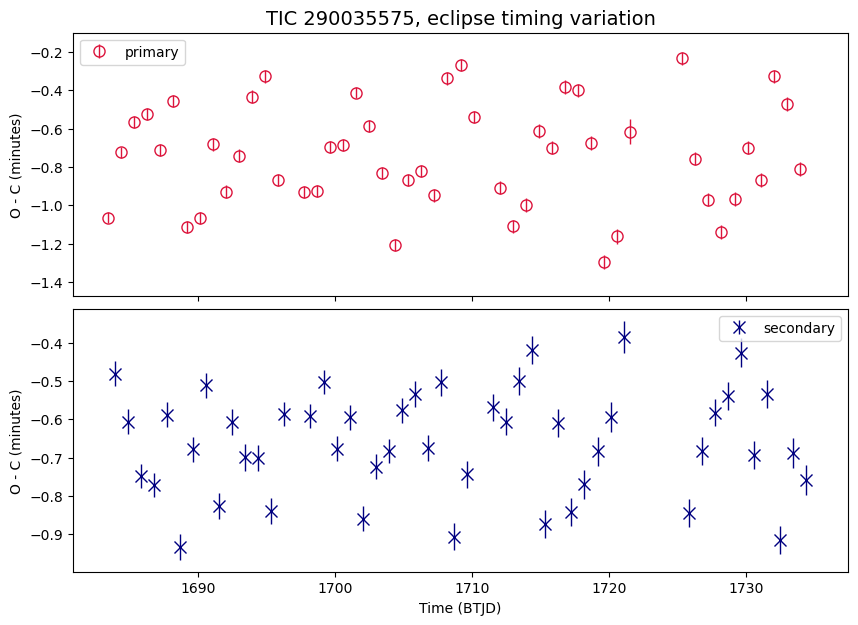

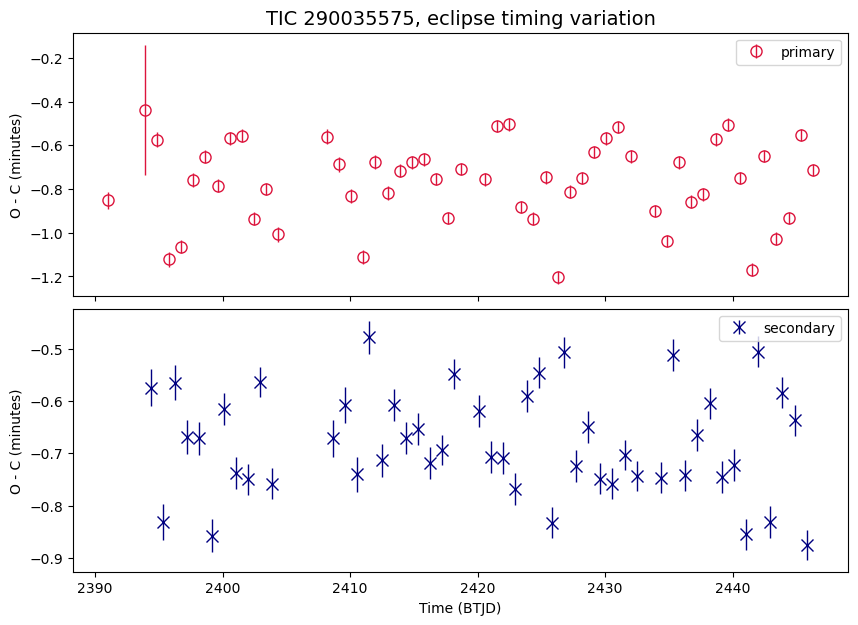

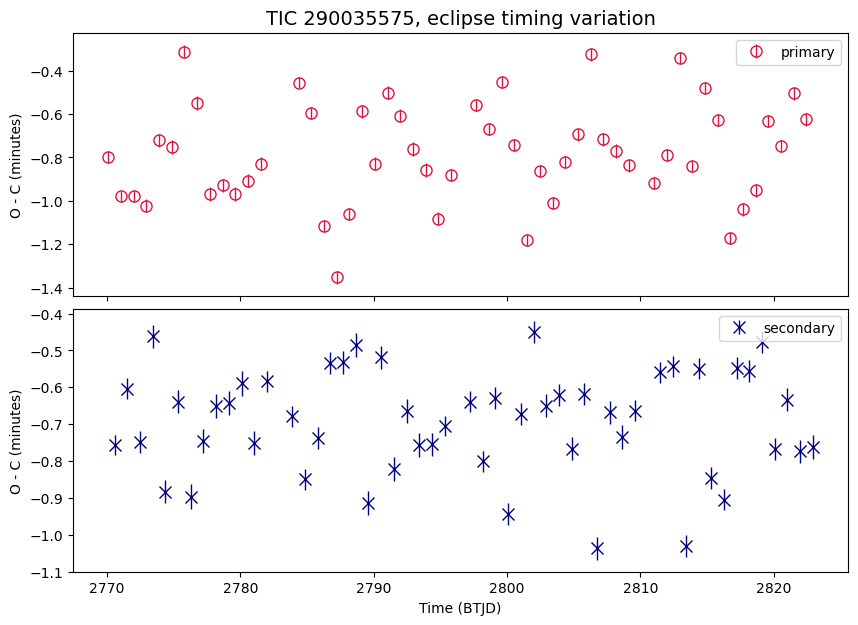

In [18]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1600, 1800),
    (2300, 2500),
    (2700, 2900),
]


def tweak_axs_list(axs_list):
    axs_list[0][0].set_ylim(None, -0.1);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

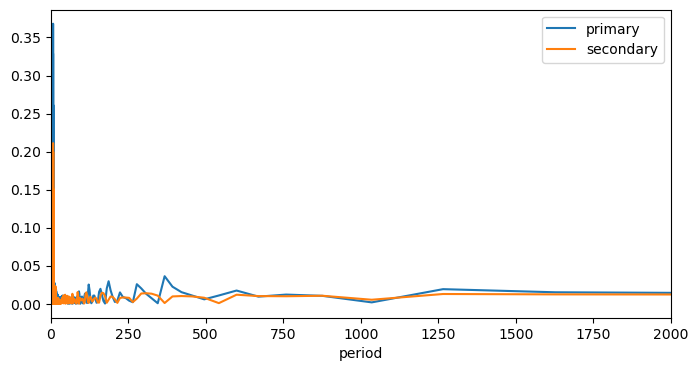

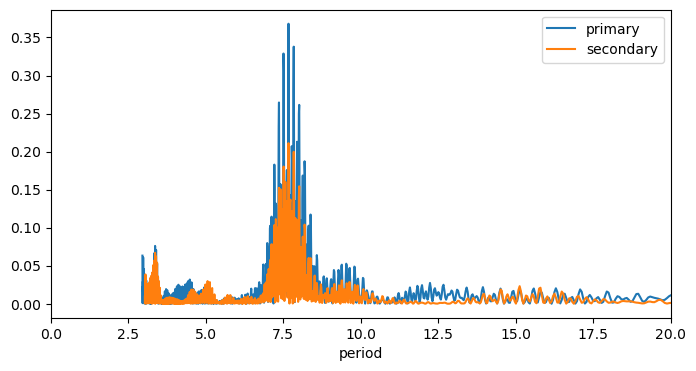

In [21]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 2000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 20)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

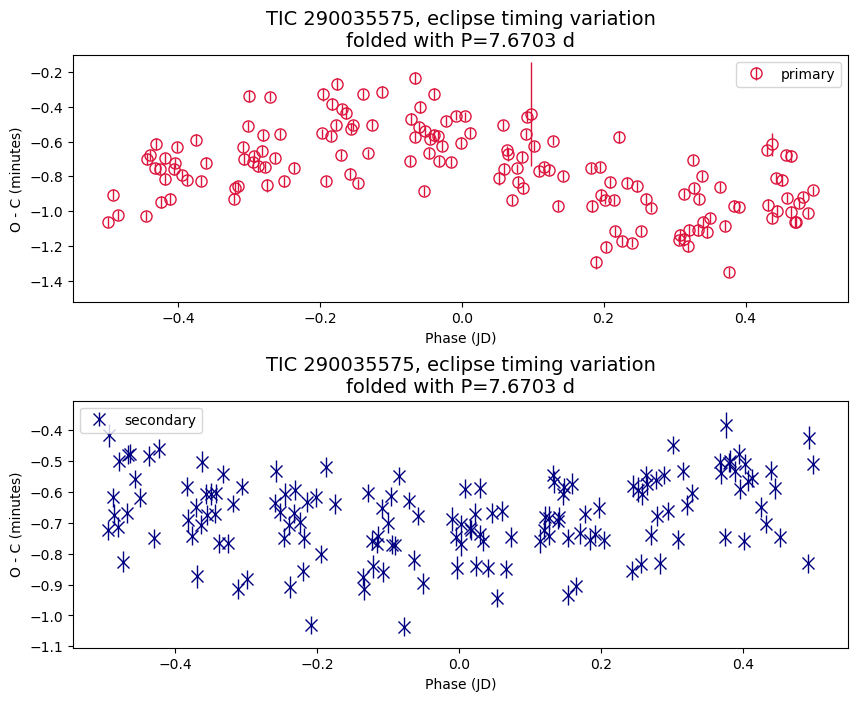

In [20]:
if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    def tweak_axs(axs):
        axs[0].set_ylim(None, -0.1);
        pass
    
    
    period_max_power = 1 / frequency[np.argmax(power)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period_max_power)
    # axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary");
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_max_power:.4f} d", fontsize=14)
    
    if in_df_secondary is not None:
        period_max_power_s = 1 / frequency_s[np.argmax(power_s)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_max_power_s)
        # axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_max_power_s:.4f} d", fontsize=14)
        
    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (JD)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    tweak_axs(axs)

## Results Summary

In [93]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "O-C suggests non-linear trend with a ~7.6 d period, amplitude ~1min. EB Period : SB Period ~= 9:10 ."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                     290035575
has_etv                                                                                                         Y
comments     O-C suggests non-linear trend with a ~7.6 d period, amplitude ~1min. EB Period : SB Period ~= 9:10 .
period                                                                                                   0.952378
depth_pct_p                                                                                                 51.57
depth_pct_s                                                                                                 49.44
epoch_p                                                                                                  1683.418
epoch_s                                                                                               1683.894189
num_sectors                                                                                                     6
time_span                                                                                                 1140.91
time_start                                                                                                1683.36
time_end                                                                                                  2824.26


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
290035575,Y,"O-C suggests non-linear trend with a ~7.6 d period, amplitude ~1min. EB Period : SB Period ~= 9:10 .",0.952377636,51.57,49.44,1683.418,1683.894188818,6,1140.91,1683.36,2824.26

